<a href="https://colab.research.google.com/github/Kazi-Rakib-Hasan-Jawwad/Histo-FSL/blob/master/few_shot_inference_bt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import torch
import torchvision
import os
import csv
import sys
from typing import Optional
from torch import nn
from torchvision.transforms import transforms  # Transformations we can perform on our dataset
from torch.utils.data import DataLoader  # Gives easier dataset managment and creates mini batchesFi
import seaborn as sns
from scipy.stats import mode
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, silhouette_score, adjusted_rand_score, normalized_mutual_info_score, v_measure_score, classification_report
from sklearn.manifold import TSNE

In [ ]:
from PIL import Image
import torch
#from transformers import AutoImageProcessor, ViTModel
from pathlib import Path

In [ ]:
from easyfsl.datasets import FeaturesDataset
from easyfsl.samplers import TaskSampler
from easyfsl.methods import PrototypicalNetworks
from easyfsl.utils import evaluate
from tqdm import tqdm

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define the colors in RGB format
gold = (255/255, 215/255, 0)  # RGB for gold
white = (1, 1, 1)  # RGB for white

# Create a custom colormap with just white and gold
colors = [white, gold]
cmap_name = 'WhiteGold'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

In [ ]:
# prompt: help me visualize the above colormap 'cm'

# Create a gradient of values from 0 to 1
gradient = np.linspace(0, 1, 256).reshape(1, -1)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(6, 1))

# Plot the gradient with the custom colormap
ax.imshow(gradient, cmap=cm)

# Turn off the axes and ticks
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

# Display the figure
plt.show()


In [ ]:
def load_encoder_weights(encoder, weights):
    model_dict = encoder.state_dict()
    weights = {k: v for k, v in weights.items() if k in model_dict}
    if weights == {}:
        print('No weight could be loaded..')
    model_dict.update(weights)
    encoder.load_state_dict(model_dict)
    return encoder

In [ ]:
# Function to evaluate clustering performance
def evaluate_clustering(data_labels, cluster_labels, save_path): #
    accuracy = accuracy_score(data_labels, cluster_labels)
    nmi = normalized_mutual_info_score(data_labels, cluster_labels)
    ari = adjusted_rand_score(data_labels, cluster_labels)

    results = {"NMI": nmi, "ARI": ari, "Accuracy": accuracy}
    with open(save_path, "w", newline="") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=["Metric", "Value"])
        writer.writeheader()
        for metric, value in results.items():
            writer.writerow({"Metric": metric, "Value": value})

    return nmi, ari, accuracy

def create_scatter_plot(embeddings_tsne, labels, output_path, title):
    # Map numeric labels to string labels
    string_labels = labels    #[classes[int(label)] for label in labels]
    # Plot feature map
    fig, ax = plt.subplots()
    sns.scatterplot(x=embeddings_tsne[:, 0], y=embeddings_tsne[:, 1], hue=string_labels, palette='tab10', s=6, alpha=0.4, ax=ax)
    ax.set_title(title)
    ax.set_aspect('equal')
    # Move the legend to a better position
    legend = ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    # Adjust legend orientation and spacing
    plt.setp(legend.get_title(), fontsize='small')
    legend.get_frame().set_alpha(None)
    legend.get_frame().set_facecolor('none')
    plt.tight_layout()
    fig.savefig(output_path, dpi=900, bbox_inches='tight')

def plot_and_save_confusion_matrix(cm, classes, output_path):
    fig, ax = plt.subplots()
    #cmap = sns.diverging_palette(220, 10, as_cmap=True)
    #cmap = sns.color_palette("YlGnBu", as_cmap=True)
    #cmap = 'YlGnBu'
    cmap=cm
    sns.heatmap(cm.T, ax=ax, square=False, annot=True, fmt='d', cbar=False, xticklabels=classes, yticklabels=classes, cmap=cmap)
    ax.set_xlabel('True label', fontsize=11)
    ax.set_ylabel('Predicted label', fontsize=11)
    ax.set_title('Confusion Matrix', fontsize=12)
    #ax.set_aspect('equal')
    # Adjust layout to prevent labels from getting cut off
    plt.tight_layout()
    fig.savefig(output_path, dpi=900, bbox_inches='tight')


In [ ]:
def predict_embeddings(
    dataloader: DataLoader,
    model: nn.Module,
    device: Optional[str] = None,
) -> pd.DataFrame:
    """
    Predict embeddings for a dataloader.
    Args:
        dataloader: dataloader to predict embeddings for. Must deliver tuples (images, class_names)
        model: model to use for prediction
        device: device to cast the images to. If none, no casting is performed. Must be the same as
            the device the model is on.
    Returns:
        dataframe with columns embedding and class_name
    """
    all_embeddings = []
    all_class_names = []
    with torch.no_grad():
        for images, class_names in tqdm(
            dataloader, unit="batch", desc="Predicting embeddings"
        ):
            if device is not None:
                images = images.to(device)
            all_embeddings.append(model(images).detach().cpu())
            if isinstance(class_names, torch.Tensor):
                all_class_names += class_names.tolist()
            else:
                all_class_names += class_names

    concatenated_embeddings = torch.cat(all_embeddings)

    return pd.DataFrame(
        {"embedding": list(concatenated_embeddings), "class_name": all_class_names}
    )

In [ ]:
def evaluate_few_shot_model(features_dataset, model, device, n_way, n_shots_range=[1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 24, 32], num_runs=20):
    """
    Evaluate a few-shot model using the Prototypical Networks approach.

    Args:
    - features_dataset: embeddings dataset.
    - model (torch.nn.Module): Pre-trained model for feature extraction.
    - device (str): Device to run the evaluation on ('cpu' or 'cuda').
    - n_shots_range (list): List of integers specifying the number of support examples per class.
    - num_runs (int): Number of evaluation runs.

    Returns:
    - pd.DataFrame: DataFrame containing the evaluation results.
    """
    # Create an empty DataFrame to store the results
    results_df = pd.DataFrame(columns=["n_shots", "accuracy"])

    # Move the model to the specified device
    #model.to(device)

    # Iterate over the specified number of runs
    for run in range(1, num_runs + 1):
        # Iterate over the range of n_shots
        for n_shots in n_shots_range:
            # Create the task sampler and data loader for the current n_shots
            task_sampler = TaskSampler(
                features_dataset,
                n_way=n_way,
                n_shot=n_shots,
                n_query=100,
                n_tasks=10,
            )
            features_loader = DataLoader(
                features_dataset,
                batch_sampler=task_sampler,
                num_workers=1,
                pin_memory=True,
                collate_fn=task_sampler.episodic_collate_fn,
            )

            # Create and evaluate the classifier
            few_shot_classifier = PrototypicalNetworks(backbone=nn.Identity())
            accuracy = evaluate(
                few_shot_classifier,
                features_loader,
                device=device,
            )

            # Print and save the accuracy for each run
            print(f"n_shots={n_shots}, Run={run}, Accuracy: {(100 * accuracy):.2f} %")

            # Append the results to the DataFrame
            results_df = results_df._append({"n_shots": n_shots, "accuracy": accuracy}, ignore_index=True)

    return results_df

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load barlow-twins
encoder = torchvision.models.__dict__['resnet50'](pretrained=False)
path = "/home/rakib/models/paper_benchmarking_ssl_diverse_pathology/bt_rn50_ep200.torch"
state_dict = torch.load(path, map_location='cuda:0')
#state_dict = state['state_dict']
encoder.fc = torch.nn.Identity()
model = load_encoder_weights(encoder, state_dict)

model.to(device)
model.eval()

/home/rakib/project-6/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rakib/project-6/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 2

In [ ]:
output_directory_k = Path("/home/rakib/models/paper_benchmarking_ssl_diverse_pathology/inference/kather/bt/2")

data_to_test = Path("/home/rakib/data/kather_texture/")
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor()])
testset = torchvision.datasets.ImageFolder(data_to_test, transform=transform)

classes = testset.classes
print(classes)
dataloader = DataLoader(testset, batch_size=128, shuffle=False, drop_last=False)
kather_emb_df = predict_embeddings(dataloader, model, device=device)
kather_emb_dataset = FeaturesDataset.from_dataframe(kather_emb_df)
kather_results_df = evaluate_few_shot_model(kather_emb_dataset, model, device=device, n_way=3)
kather_results_df.sort_values(["n_shots", "accuracy"])

mean_accuracies_k = kather_results_df.groupby("n_shots")["accuracy"].mean().reset_index()
mean_accuracies_k.rename(columns={"accuracy": "mean"}, inplace=True)
std_accuracies_k = kather_results_df.groupby("n_shots")["accuracy"].std().reset_index()
std_accuracies_k.rename(columns={"accuracy": "std"}, inplace=True)
# Merge the two DataFrames based on the 'n_shots' column
merged_df_k = pd.merge(mean_accuracies_k, std_accuracies_k, on="n_shots")

# Save the average accuracy information in a separate CSV file
acc_csv_filename = "3way_average_accuracy_kather_bt.csv"
merged_df_k.to_csv(os.path.join(output_directory_k, acc_csv_filename), index=False)

['adipose', 'complex', 'debris', 'empty', 'lympho', 'mucosa', 'stroma', 'tumor']


100%|██████████████████████████| 10/10 [00:00<00:00, 100.14it/s, accuracy=0.758]

n_shots=1, Run=1, Accuracy: 75.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.56it/s, accuracy=0.893]

n_shots=2, Run=1, Accuracy: 89.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.45it/s, accuracy=0.929]

n_shots=3, Run=1, Accuracy: 92.93 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.54it/s, accuracy=0.933]

n_shots=4, Run=1, Accuracy: 93.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.93it/s, accuracy=0.918]

n_shots=5, Run=1, Accuracy: 91.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.12it/s, accuracy=0.933]

n_shots=6, Run=1, Accuracy: 93.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.22it/s, accuracy=0.941]

n_shots=8, Run=1, Accuracy: 94.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 107.24it/s, accuracy=0.94]

n_shots=10, Run=1, Accuracy: 93.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.88it/s, accuracy=0.954]

n_shots=12, Run=1, Accuracy: 95.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.50it/s, accuracy=0.947]

n_shots=16, Run=1, Accuracy: 94.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.96it/s, accuracy=0.949]

n_shots=24, Run=1, Accuracy: 94.93 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.38it/s, accuracy=0.949]

n_shots=32, Run=1, Accuracy: 94.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.52it/s, accuracy=0.846]

n_shots=1, Run=2, Accuracy: 84.60 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.32it/s, accuracy=0.864]

n_shots=2, Run=2, Accuracy: 86.37 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.82it/s, accuracy=0.887]

n_shots=3, Run=2, Accuracy: 88.70 %



100%|███████████████████████████| 10/10 [00:00<00:00, 106.68it/s, accuracy=0.92]

n_shots=4, Run=2, Accuracy: 92.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.93it/s, accuracy=0.918]

n_shots=5, Run=2, Accuracy: 91.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.06it/s, accuracy=0.932]

n_shots=6, Run=2, Accuracy: 93.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 102.45it/s, accuracy=0.945]

n_shots=8, Run=2, Accuracy: 94.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.45it/s, accuracy=0.949]

n_shots=10, Run=2, Accuracy: 94.87 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.09it/s, accuracy=0.932]

n_shots=12, Run=2, Accuracy: 93.23 %



100%|███████████████████████████| 10/10 [00:00<00:00, 90.41it/s, accuracy=0.942]

n_shots=16, Run=2, Accuracy: 94.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.54it/s, accuracy=0.948]

n_shots=24, Run=2, Accuracy: 94.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.71it/s, accuracy=0.932]

n_shots=32, Run=2, Accuracy: 93.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.67it/s, accuracy=0.811]

n_shots=1, Run=3, Accuracy: 81.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.41it/s, accuracy=0.838]


n_shots=2, Run=3, Accuracy: 83.83 %


100%|████████████████████████████| 10/10 [00:00<00:00, 111.51it/s, accuracy=0.9]

n_shots=3, Run=3, Accuracy: 90.00 %



100%|███████████████████████████| 10/10 [00:00<00:00, 104.69it/s, accuracy=0.93]

n_shots=4, Run=3, Accuracy: 92.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.02it/s, accuracy=0.924]

n_shots=5, Run=3, Accuracy: 92.37 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.50it/s, accuracy=0.904]

n_shots=6, Run=3, Accuracy: 90.37 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.62it/s, accuracy=0.917]

n_shots=8, Run=3, Accuracy: 91.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.09it/s, accuracy=0.938]

n_shots=10, Run=3, Accuracy: 93.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.05it/s, accuracy=0.955]

n_shots=12, Run=3, Accuracy: 95.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.81it/s, accuracy=0.963]

n_shots=16, Run=3, Accuracy: 96.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.43it/s, accuracy=0.935]

n_shots=24, Run=3, Accuracy: 93.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.13it/s, accuracy=0.946]

n_shots=32, Run=3, Accuracy: 94.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.28it/s, accuracy=0.816]

n_shots=1, Run=4, Accuracy: 81.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.67it/s, accuracy=0.859]

n_shots=2, Run=4, Accuracy: 85.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.85it/s, accuracy=0.897]

n_shots=3, Run=4, Accuracy: 89.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.44it/s, accuracy=0.923]

n_shots=4, Run=4, Accuracy: 92.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.07it/s, accuracy=0.942]

n_shots=5, Run=4, Accuracy: 94.20 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.41it/s, accuracy=0.934]

n_shots=6, Run=4, Accuracy: 93.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.13it/s, accuracy=0.939]

n_shots=8, Run=4, Accuracy: 93.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.86it/s, accuracy=0.918]

n_shots=10, Run=4, Accuracy: 91.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.84it/s, accuracy=0.931]

n_shots=12, Run=4, Accuracy: 93.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.12it/s, accuracy=0.957]

n_shots=16, Run=4, Accuracy: 95.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 102.64it/s, accuracy=0.961]

n_shots=24, Run=4, Accuracy: 96.13 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.52it/s, accuracy=0.962]

n_shots=32, Run=4, Accuracy: 96.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.96it/s, accuracy=0.831]

n_shots=1, Run=5, Accuracy: 83.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.49it/s, accuracy=0.882]

n_shots=2, Run=5, Accuracy: 88.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.77it/s, accuracy=0.932]

n_shots=3, Run=5, Accuracy: 93.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.37it/s, accuracy=0.924]

n_shots=4, Run=5, Accuracy: 92.37 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.78it/s, accuracy=0.921]

n_shots=5, Run=5, Accuracy: 92.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.42it/s, accuracy=0.936]

n_shots=6, Run=5, Accuracy: 93.63 %



100%|███████████████████████████| 10/10 [00:00<00:00, 105.48it/s, accuracy=0.94]

n_shots=8, Run=5, Accuracy: 94.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.15it/s, accuracy=0.959]

n_shots=10, Run=5, Accuracy: 95.87 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.47it/s, accuracy=0.928]

n_shots=12, Run=5, Accuracy: 92.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.20it/s, accuracy=0.947]

n_shots=16, Run=5, Accuracy: 94.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.93it/s, accuracy=0.948]

n_shots=24, Run=5, Accuracy: 94.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.75it/s, accuracy=0.911]

n_shots=32, Run=5, Accuracy: 91.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.37it/s, accuracy=0.832]

n_shots=1, Run=6, Accuracy: 83.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.23it/s, accuracy=0.921]

n_shots=2, Run=6, Accuracy: 92.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.59it/s, accuracy=0.904]

n_shots=3, Run=6, Accuracy: 90.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.79it/s, accuracy=0.931]

n_shots=4, Run=6, Accuracy: 93.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.50it/s, accuracy=0.948]

n_shots=5, Run=6, Accuracy: 94.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.20it/s, accuracy=0.911]

n_shots=6, Run=6, Accuracy: 91.07 %



100%|███████████████████████████| 10/10 [00:00<00:00, 104.23it/s, accuracy=0.92]

n_shots=8, Run=6, Accuracy: 92.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.69it/s, accuracy=0.948]

n_shots=10, Run=6, Accuracy: 94.80 %



100%|███████████████████████████| 10/10 [00:00<00:00, 92.91it/s, accuracy=0.937]

n_shots=12, Run=6, Accuracy: 93.70 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.90it/s, accuracy=0.949]

n_shots=16, Run=6, Accuracy: 94.93 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.44it/s, accuracy=0.967]

n_shots=24, Run=6, Accuracy: 96.67 %



100%|███████████████████████████| 10/10 [00:00<00:00, 105.54it/s, accuracy=0.93]

n_shots=32, Run=6, Accuracy: 93.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.20it/s, accuracy=0.812]

n_shots=1, Run=7, Accuracy: 81.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.93it/s, accuracy=0.885]

n_shots=2, Run=7, Accuracy: 88.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.36it/s, accuracy=0.918]

n_shots=3, Run=7, Accuracy: 91.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 102.46it/s, accuracy=0.905]

n_shots=4, Run=7, Accuracy: 90.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.49it/s, accuracy=0.941]

n_shots=5, Run=7, Accuracy: 94.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.72it/s, accuracy=0.937]

n_shots=6, Run=7, Accuracy: 93.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.97it/s, accuracy=0.955]

n_shots=8, Run=7, Accuracy: 95.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.31it/s, accuracy=0.931]

n_shots=10, Run=7, Accuracy: 93.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.19it/s, accuracy=0.924]

n_shots=12, Run=7, Accuracy: 92.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.03it/s, accuracy=0.942]

n_shots=16, Run=7, Accuracy: 94.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.03it/s, accuracy=0.941]

n_shots=24, Run=7, Accuracy: 94.07 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.06it/s, accuracy=0.958]

n_shots=32, Run=7, Accuracy: 95.83 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.54it/s, accuracy=0.774]

n_shots=1, Run=8, Accuracy: 77.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 102.81it/s, accuracy=0.911]

n_shots=2, Run=8, Accuracy: 91.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.60it/s, accuracy=0.884]

n_shots=3, Run=8, Accuracy: 88.37 %



100%|████████████████████████████| 10/10 [00:00<00:00, 102.99it/s, accuracy=0.9]

n_shots=4, Run=8, Accuracy: 89.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.26it/s, accuracy=0.923]

n_shots=5, Run=8, Accuracy: 92.27 %



100%|███████████████████████████| 10/10 [00:00<00:00, 88.76it/s, accuracy=0.916]

n_shots=6, Run=8, Accuracy: 91.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.10it/s, accuracy=0.953]

n_shots=8, Run=8, Accuracy: 95.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.44it/s, accuracy=0.931]

n_shots=10, Run=8, Accuracy: 93.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.64it/s, accuracy=0.936]

n_shots=12, Run=8, Accuracy: 93.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.65it/s, accuracy=0.928]

n_shots=16, Run=8, Accuracy: 92.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.87it/s, accuracy=0.959]

n_shots=24, Run=8, Accuracy: 95.87 %



100%|██████████████████████████| 10/10 [00:00<00:00, 102.60it/s, accuracy=0.959]

n_shots=32, Run=8, Accuracy: 95.93 %



100%|███████████████████████████| 10/10 [00:00<00:00, 104.90it/s, accuracy=0.79]

n_shots=1, Run=9, Accuracy: 79.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.83it/s, accuracy=0.849]

n_shots=2, Run=9, Accuracy: 84.93 %



100%|██████████████████████████| 10/10 [00:00<00:00, 112.14it/s, accuracy=0.893]

n_shots=3, Run=9, Accuracy: 89.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.94it/s, accuracy=0.918]

n_shots=4, Run=9, Accuracy: 91.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.76it/s, accuracy=0.907]

n_shots=5, Run=9, Accuracy: 90.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.47it/s, accuracy=0.954]

n_shots=6, Run=9, Accuracy: 95.37 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.97it/s, accuracy=0.929]

n_shots=8, Run=9, Accuracy: 92.93 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.40it/s, accuracy=0.966]

n_shots=10, Run=9, Accuracy: 96.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.23it/s, accuracy=0.945]

n_shots=12, Run=9, Accuracy: 94.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.98it/s, accuracy=0.943]

n_shots=16, Run=9, Accuracy: 94.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.78it/s, accuracy=0.954]

n_shots=24, Run=9, Accuracy: 95.43 %



100%|███████████████████████████| 10/10 [00:00<00:00, 105.37it/s, accuracy=0.95]

n_shots=32, Run=9, Accuracy: 95.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.14it/s, accuracy=0.784]

n_shots=1, Run=10, Accuracy: 78.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.24it/s, accuracy=0.802]

n_shots=2, Run=10, Accuracy: 80.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.95it/s, accuracy=0.924]

n_shots=3, Run=10, Accuracy: 92.37 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.28it/s, accuracy=0.957]

n_shots=4, Run=10, Accuracy: 95.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.39it/s, accuracy=0.944]

n_shots=5, Run=10, Accuracy: 94.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.51it/s, accuracy=0.939]

n_shots=6, Run=10, Accuracy: 93.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 102.27it/s, accuracy=0.943]

n_shots=8, Run=10, Accuracy: 94.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.34it/s, accuracy=0.923]

n_shots=10, Run=10, Accuracy: 92.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 102.75it/s, accuracy=0.925]

n_shots=12, Run=10, Accuracy: 92.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.28it/s, accuracy=0.953]

n_shots=16, Run=10, Accuracy: 95.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.98it/s, accuracy=0.952]

n_shots=24, Run=10, Accuracy: 95.17 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.35it/s, accuracy=0.952]

n_shots=32, Run=10, Accuracy: 95.20 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.43it/s, accuracy=0.865]

n_shots=1, Run=11, Accuracy: 86.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.11it/s, accuracy=0.922]

n_shots=2, Run=11, Accuracy: 92.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.67it/s, accuracy=0.871]

n_shots=3, Run=11, Accuracy: 87.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.34it/s, accuracy=0.909]

n_shots=4, Run=11, Accuracy: 90.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.77it/s, accuracy=0.931]

n_shots=5, Run=11, Accuracy: 93.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.73it/s, accuracy=0.961]

n_shots=6, Run=11, Accuracy: 96.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.95it/s, accuracy=0.932]

n_shots=8, Run=11, Accuracy: 93.23 %



100%|███████████████████████████| 10/10 [00:00<00:00, 91.06it/s, accuracy=0.948]

n_shots=10, Run=11, Accuracy: 94.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.55it/s, accuracy=0.934]

n_shots=12, Run=11, Accuracy: 93.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.53it/s, accuracy=0.948]

n_shots=16, Run=11, Accuracy: 94.83 %



100%|███████████████████████████| 10/10 [00:00<00:00, 105.08it/s, accuracy=0.96]

n_shots=24, Run=11, Accuracy: 96.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.55it/s, accuracy=0.956]

n_shots=32, Run=11, Accuracy: 95.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.29it/s, accuracy=0.789]

n_shots=1, Run=12, Accuracy: 78.93 %



100%|███████████████████████████| 10/10 [00:00<00:00, 107.77it/s, accuracy=0.84]

n_shots=2, Run=12, Accuracy: 83.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.26it/s, accuracy=0.954]

n_shots=3, Run=12, Accuracy: 95.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.13it/s, accuracy=0.925]

n_shots=4, Run=12, Accuracy: 92.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.63it/s, accuracy=0.935]

n_shots=5, Run=12, Accuracy: 93.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.61it/s, accuracy=0.956]

n_shots=6, Run=12, Accuracy: 95.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.81it/s, accuracy=0.944]

n_shots=8, Run=12, Accuracy: 94.37 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.79it/s, accuracy=0.928]

n_shots=10, Run=12, Accuracy: 92.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.27it/s, accuracy=0.922]

n_shots=12, Run=12, Accuracy: 92.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 102.87it/s, accuracy=0.954]

n_shots=16, Run=12, Accuracy: 95.37 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.05it/s, accuracy=0.954]

n_shots=24, Run=12, Accuracy: 95.40 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.36it/s, accuracy=0.943]

n_shots=32, Run=12, Accuracy: 94.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.41it/s, accuracy=0.765]

n_shots=1, Run=13, Accuracy: 76.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.89it/s, accuracy=0.935]

n_shots=2, Run=13, Accuracy: 93.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 112.41it/s, accuracy=0.904]

n_shots=3, Run=13, Accuracy: 90.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.57it/s, accuracy=0.909]

n_shots=4, Run=13, Accuracy: 90.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 111.31it/s, accuracy=0.95]

n_shots=5, Run=13, Accuracy: 94.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.84it/s, accuracy=0.928]

n_shots=6, Run=13, Accuracy: 92.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.13it/s, accuracy=0.956]

n_shots=8, Run=13, Accuracy: 95.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.21it/s, accuracy=0.949]

n_shots=10, Run=13, Accuracy: 94.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.91it/s, accuracy=0.922]

n_shots=12, Run=13, Accuracy: 92.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.83it/s, accuracy=0.952]

n_shots=16, Run=13, Accuracy: 95.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.06it/s, accuracy=0.964]

n_shots=24, Run=13, Accuracy: 96.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.37it/s, accuracy=0.958]

n_shots=32, Run=13, Accuracy: 95.80 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.39it/s, accuracy=0.866]

n_shots=1, Run=14, Accuracy: 86.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.89it/s, accuracy=0.917]

n_shots=2, Run=14, Accuracy: 91.67 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.43it/s, accuracy=0.878]

n_shots=3, Run=14, Accuracy: 87.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.13it/s, accuracy=0.906]

n_shots=4, Run=14, Accuracy: 90.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.83it/s, accuracy=0.926]

n_shots=5, Run=14, Accuracy: 92.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.93it/s, accuracy=0.915]

n_shots=6, Run=14, Accuracy: 91.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 112.21it/s, accuracy=0.931]

n_shots=8, Run=14, Accuracy: 93.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.69it/s, accuracy=0.921]

n_shots=10, Run=14, Accuracy: 92.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.06it/s, accuracy=0.942]

n_shots=12, Run=14, Accuracy: 94.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.23it/s, accuracy=0.948]

n_shots=16, Run=14, Accuracy: 94.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.32it/s, accuracy=0.952]

n_shots=24, Run=14, Accuracy: 95.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.65it/s, accuracy=0.951]

n_shots=32, Run=14, Accuracy: 95.07 %



100%|███████████████████████████| 10/10 [00:00<00:00, 105.53it/s, accuracy=0.83]

n_shots=1, Run=15, Accuracy: 83.03 %



100%|████████████████████████████| 10/10 [00:00<00:00, 107.81it/s, accuracy=0.9]

n_shots=2, Run=15, Accuracy: 89.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.13it/s, accuracy=0.897]

n_shots=3, Run=15, Accuracy: 89.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.94it/s, accuracy=0.929]

n_shots=4, Run=15, Accuracy: 92.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.01it/s, accuracy=0.941]

n_shots=5, Run=15, Accuracy: 94.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.25it/s, accuracy=0.936]

n_shots=6, Run=15, Accuracy: 93.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.16it/s, accuracy=0.923]

n_shots=8, Run=15, Accuracy: 92.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.92it/s, accuracy=0.949]

n_shots=10, Run=15, Accuracy: 94.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.12it/s, accuracy=0.921]

n_shots=12, Run=15, Accuracy: 92.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.81it/s, accuracy=0.931]

n_shots=16, Run=15, Accuracy: 93.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.19it/s, accuracy=0.937]

n_shots=24, Run=15, Accuracy: 93.67 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.55it/s, accuracy=0.936]

n_shots=32, Run=15, Accuracy: 93.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.05it/s, accuracy=0.794]

n_shots=1, Run=16, Accuracy: 79.37 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.41it/s, accuracy=0.854]

n_shots=2, Run=16, Accuracy: 85.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.32it/s, accuracy=0.944]

n_shots=3, Run=16, Accuracy: 94.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.22it/s, accuracy=0.905]

n_shots=4, Run=16, Accuracy: 90.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.63it/s, accuracy=0.937]

n_shots=5, Run=16, Accuracy: 93.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.27it/s, accuracy=0.941]

n_shots=6, Run=16, Accuracy: 94.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.96it/s, accuracy=0.944]

n_shots=8, Run=16, Accuracy: 94.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.62it/s, accuracy=0.923]

n_shots=10, Run=16, Accuracy: 92.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.79it/s, accuracy=0.943]

n_shots=12, Run=16, Accuracy: 94.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.34it/s, accuracy=0.948]

n_shots=16, Run=16, Accuracy: 94.77 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.49it/s, accuracy=0.927]

n_shots=24, Run=16, Accuracy: 92.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.39it/s, accuracy=0.928]

n_shots=32, Run=16, Accuracy: 92.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 102.46it/s, accuracy=0.817]

n_shots=1, Run=17, Accuracy: 81.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.29it/s, accuracy=0.904]

n_shots=2, Run=17, Accuracy: 90.37 %



100%|███████████████████████████| 10/10 [00:00<00:00, 101.68it/s, accuracy=0.93]

n_shots=3, Run=17, Accuracy: 93.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.66it/s, accuracy=0.926]

n_shots=4, Run=17, Accuracy: 92.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.29it/s, accuracy=0.905]

n_shots=5, Run=17, Accuracy: 90.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.70it/s, accuracy=0.908]

n_shots=6, Run=17, Accuracy: 90.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.93it/s, accuracy=0.942]

n_shots=8, Run=17, Accuracy: 94.23 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.96it/s, accuracy=0.931]

n_shots=10, Run=17, Accuracy: 93.10 %



100%|████████████████████████████| 10/10 [00:00<00:00, 99.60it/s, accuracy=0.93]

n_shots=12, Run=17, Accuracy: 93.00 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.45it/s, accuracy=0.945]

n_shots=16, Run=17, Accuracy: 94.47 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.61it/s, accuracy=0.941]

n_shots=24, Run=17, Accuracy: 94.13 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.04it/s, accuracy=0.946]

n_shots=32, Run=17, Accuracy: 94.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.19it/s, accuracy=0.799]

n_shots=1, Run=18, Accuracy: 79.87 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.67it/s, accuracy=0.875]

n_shots=2, Run=18, Accuracy: 87.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.49it/s, accuracy=0.874]

n_shots=3, Run=18, Accuracy: 87.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.66it/s, accuracy=0.927]

n_shots=4, Run=18, Accuracy: 92.67 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.69it/s, accuracy=0.939]

n_shots=5, Run=18, Accuracy: 93.87 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.33it/s, accuracy=0.912]

n_shots=6, Run=18, Accuracy: 91.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.01it/s, accuracy=0.943]

n_shots=8, Run=18, Accuracy: 94.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.83it/s, accuracy=0.936]

n_shots=10, Run=18, Accuracy: 93.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.76it/s, accuracy=0.937]

n_shots=12, Run=18, Accuracy: 93.67 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.53it/s, accuracy=0.957]

n_shots=16, Run=18, Accuracy: 95.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.47it/s, accuracy=0.956]

n_shots=24, Run=18, Accuracy: 95.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.31it/s, accuracy=0.965]

n_shots=32, Run=18, Accuracy: 96.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.18it/s, accuracy=0.823]

n_shots=1, Run=19, Accuracy: 82.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.69it/s, accuracy=0.899]

n_shots=2, Run=19, Accuracy: 89.87 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.27it/s, accuracy=0.947]

n_shots=3, Run=19, Accuracy: 94.67 %



100%|██████████████████████████| 10/10 [00:00<00:00, 112.04it/s, accuracy=0.896]


n_shots=4, Run=19, Accuracy: 89.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 107.37it/s, accuracy=0.938]

n_shots=5, Run=19, Accuracy: 93.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.15it/s, accuracy=0.926]

n_shots=6, Run=19, Accuracy: 92.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.20it/s, accuracy=0.956]

n_shots=8, Run=19, Accuracy: 95.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.45it/s, accuracy=0.949]

n_shots=10, Run=19, Accuracy: 94.87 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.84it/s, accuracy=0.932]

n_shots=12, Run=19, Accuracy: 93.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.77it/s, accuracy=0.926]

n_shots=16, Run=19, Accuracy: 92.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.26it/s, accuracy=0.963]

n_shots=24, Run=19, Accuracy: 96.33 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.81it/s, accuracy=0.933]

n_shots=32, Run=19, Accuracy: 93.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.38it/s, accuracy=0.812]

n_shots=1, Run=20, Accuracy: 81.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.41it/s, accuracy=0.898]

n_shots=2, Run=20, Accuracy: 89.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 112.80it/s, accuracy=0.879]

n_shots=3, Run=20, Accuracy: 87.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 104.27it/s, accuracy=0.93]

n_shots=4, Run=20, Accuracy: 92.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.37it/s, accuracy=0.888]

n_shots=5, Run=20, Accuracy: 88.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.75it/s, accuracy=0.954]

n_shots=6, Run=20, Accuracy: 95.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.22it/s, accuracy=0.936]

n_shots=8, Run=20, Accuracy: 93.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.09it/s, accuracy=0.955]

n_shots=10, Run=20, Accuracy: 95.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.39it/s, accuracy=0.966]

n_shots=12, Run=20, Accuracy: 96.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.77it/s, accuracy=0.933]

n_shots=16, Run=20, Accuracy: 93.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.78it/s, accuracy=0.942]

n_shots=24, Run=20, Accuracy: 94.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.58it/s, accuracy=0.949]

n_shots=32, Run=20, Accuracy: 94.90 %


In [ ]:
output_directory_n = Path("/home/rakib/models/paper_benchmarking_ssl_diverse_pathology/inference/nct0/bt/2")
#data_to_test = "/home/rakib/data/TIGER"
data_to_test = Path("/home/rakib/data/CRC-VAL-HE-7K/")
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor()])
testset = torchvision.datasets.ImageFolder(data_to_test, transform=transform)

classes = testset.classes

print(classes)
dataloader = DataLoader(testset, batch_size=128, shuffle=False, drop_last=False)
nct_emb_df = predict_embeddings(dataloader, model, device=device)
nct_emb_dataset = FeaturesDataset.from_dataframe(nct_emb_df)
nct_results_df = evaluate_few_shot_model(nct_emb_dataset, model, device=device, n_way=3)
nct_results_df.sort_values(["n_shots", "accuracy"])

mean_accuracies_nct = nct_results_df.groupby("n_shots")["accuracy"].mean().reset_index()
mean_accuracies_nct.rename(columns={"accuracy": "mean"}, inplace=True)
std_accuracies_nct = nct_results_df.groupby("n_shots")["accuracy"].std().reset_index()
std_accuracies_nct.rename(columns={"accuracy": "std"}, inplace=True)
# Merge the two DataFrames based on the 'n_shots' column
merged_df_nct = pd.merge(mean_accuracies_nct, std_accuracies_nct, on="n_shots")

# Save the average accuracy information in a separate CSV file
acc_csv_filename = "3way_average_accuracy_nct_bt.csv"
merged_df_nct.to_csv(os.path.join(output_directory_n, acc_csv_filename), index=False)

['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']


100%|███████████████████████████| 10/10 [00:00<00:00, 104.10it/s, accuracy=0.91]

n_shots=1, Run=1, Accuracy: 90.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.89it/s, accuracy=0.865]

n_shots=2, Run=1, Accuracy: 86.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 106.25it/s, accuracy=0.94]

n_shots=3, Run=1, Accuracy: 94.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.04it/s, accuracy=0.961]

n_shots=4, Run=1, Accuracy: 96.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.38it/s, accuracy=0.985]

n_shots=5, Run=1, Accuracy: 98.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.68it/s, accuracy=0.961]

n_shots=6, Run=1, Accuracy: 96.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.09it/s, accuracy=0.956]

n_shots=8, Run=1, Accuracy: 95.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.56it/s, accuracy=0.965]

n_shots=10, Run=1, Accuracy: 96.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.77it/s, accuracy=0.996]

n_shots=12, Run=1, Accuracy: 99.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.34it/s, accuracy=0.993]

n_shots=16, Run=1, Accuracy: 99.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.61it/s, accuracy=0.979]

n_shots=24, Run=1, Accuracy: 97.93 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.57it/s, accuracy=0.954]

n_shots=32, Run=1, Accuracy: 95.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.99it/s, accuracy=0.864]

n_shots=1, Run=2, Accuracy: 86.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.36it/s, accuracy=0.945]

n_shots=2, Run=2, Accuracy: 94.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.88it/s, accuracy=0.926]

n_shots=3, Run=2, Accuracy: 92.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.38it/s, accuracy=0.948]

n_shots=4, Run=2, Accuracy: 94.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.87it/s, accuracy=0.971]

n_shots=5, Run=2, Accuracy: 97.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.98it/s, accuracy=0.991]

n_shots=6, Run=2, Accuracy: 99.07 %



100%|███████████████████████████| 10/10 [00:00<00:00, 108.95it/s, accuracy=0.97]

n_shots=8, Run=2, Accuracy: 97.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.71it/s, accuracy=0.988]

n_shots=10, Run=2, Accuracy: 98.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.98it/s, accuracy=0.974]

n_shots=12, Run=2, Accuracy: 97.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 102.71it/s, accuracy=0.987]

n_shots=16, Run=2, Accuracy: 98.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.39it/s, accuracy=0.984]

n_shots=24, Run=2, Accuracy: 98.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.53it/s, accuracy=0.985]

n_shots=32, Run=2, Accuracy: 98.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 105.62it/s, accuracy=0.88]

n_shots=1, Run=3, Accuracy: 87.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.33it/s, accuracy=0.965]

n_shots=2, Run=3, Accuracy: 96.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.47it/s, accuracy=0.948]

n_shots=3, Run=3, Accuracy: 94.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.82it/s, accuracy=0.983]

n_shots=4, Run=3, Accuracy: 98.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.63it/s, accuracy=0.968]

n_shots=5, Run=3, Accuracy: 96.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.16it/s, accuracy=0.956]

n_shots=6, Run=3, Accuracy: 95.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.72it/s, accuracy=0.975]

n_shots=8, Run=3, Accuracy: 97.53 %



100%|███████████████████████████| 10/10 [00:00<00:00, 105.75it/s, accuracy=0.99]

n_shots=10, Run=3, Accuracy: 98.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.10it/s, accuracy=0.971]

n_shots=12, Run=3, Accuracy: 97.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 107.68it/s, accuracy=0.98]

n_shots=16, Run=3, Accuracy: 98.03 %



100%|███████████████████████████| 10/10 [00:00<00:00, 102.84it/s, accuracy=0.98]

n_shots=24, Run=3, Accuracy: 97.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.96it/s, accuracy=0.972]

n_shots=32, Run=3, Accuracy: 97.17 %



100%|███████████████████████████| 10/10 [00:00<00:00, 103.15it/s, accuracy=0.84]

n_shots=1, Run=4, Accuracy: 83.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.43it/s, accuracy=0.908]

n_shots=2, Run=4, Accuracy: 90.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.89it/s, accuracy=0.928]

n_shots=3, Run=4, Accuracy: 92.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.30it/s, accuracy=0.955]

n_shots=4, Run=4, Accuracy: 95.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.37it/s, accuracy=0.982]

n_shots=5, Run=4, Accuracy: 98.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.79it/s, accuracy=0.993]

n_shots=6, Run=4, Accuracy: 99.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 109.22it/s, accuracy=0.97]

n_shots=8, Run=4, Accuracy: 97.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.54it/s, accuracy=0.991]

n_shots=10, Run=4, Accuracy: 99.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.46it/s, accuracy=0.986]

n_shots=12, Run=4, Accuracy: 98.63 %



100%|███████████████████████████| 10/10 [00:00<00:00, 106.68it/s, accuracy=0.98]

n_shots=16, Run=4, Accuracy: 98.03 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.35it/s, accuracy=0.973]

n_shots=24, Run=4, Accuracy: 97.27 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.90it/s, accuracy=0.976]

n_shots=32, Run=4, Accuracy: 97.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.68it/s, accuracy=0.772]

n_shots=1, Run=5, Accuracy: 77.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.34it/s, accuracy=0.908]

n_shots=2, Run=5, Accuracy: 90.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.52it/s, accuracy=0.898]

n_shots=3, Run=5, Accuracy: 89.80 %



100%|███████████████████████████| 10/10 [00:00<00:00, 103.62it/s, accuracy=0.98]

n_shots=4, Run=5, Accuracy: 97.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 112.01it/s, accuracy=0.981]

n_shots=5, Run=5, Accuracy: 98.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.73it/s, accuracy=0.982]

n_shots=6, Run=5, Accuracy: 98.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.43it/s, accuracy=0.945]

n_shots=8, Run=5, Accuracy: 94.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.51it/s, accuracy=0.948]

n_shots=10, Run=5, Accuracy: 94.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.17it/s, accuracy=0.969]

n_shots=12, Run=5, Accuracy: 96.93 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.54it/s, accuracy=0.972]

n_shots=16, Run=5, Accuracy: 97.20 %



100%|███████████████████████████| 10/10 [00:00<00:00, 106.63it/s, accuracy=0.99]

n_shots=24, Run=5, Accuracy: 99.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.69it/s, accuracy=0.979]

n_shots=32, Run=5, Accuracy: 97.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.97it/s, accuracy=0.883]

n_shots=1, Run=6, Accuracy: 88.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.31it/s, accuracy=0.944]

n_shots=2, Run=6, Accuracy: 94.37 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.75it/s, accuracy=0.936]

n_shots=3, Run=6, Accuracy: 93.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.57it/s, accuracy=0.949]

n_shots=4, Run=6, Accuracy: 94.93 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.27it/s, accuracy=0.972]

n_shots=5, Run=6, Accuracy: 97.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.14it/s, accuracy=0.962]

n_shots=6, Run=6, Accuracy: 96.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.95it/s, accuracy=0.975]

n_shots=8, Run=6, Accuracy: 97.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.70it/s, accuracy=0.952]

n_shots=10, Run=6, Accuracy: 95.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.10it/s, accuracy=0.992]

n_shots=12, Run=6, Accuracy: 99.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.40it/s, accuracy=0.962]

n_shots=16, Run=6, Accuracy: 96.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.01it/s, accuracy=0.987]

n_shots=24, Run=6, Accuracy: 98.67 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.74it/s, accuracy=0.988]

n_shots=32, Run=6, Accuracy: 98.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.82it/s, accuracy=0.832]

n_shots=1, Run=7, Accuracy: 83.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.85it/s, accuracy=0.926]

n_shots=2, Run=7, Accuracy: 92.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.75it/s, accuracy=0.957]

n_shots=3, Run=7, Accuracy: 95.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.70it/s, accuracy=0.931]

n_shots=4, Run=7, Accuracy: 93.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.84it/s, accuracy=0.977]

n_shots=5, Run=7, Accuracy: 97.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.76it/s, accuracy=0.968]

n_shots=6, Run=7, Accuracy: 96.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.95it/s, accuracy=0.957]

n_shots=8, Run=7, Accuracy: 95.73 %



100%|███████████████████████████| 10/10 [00:00<00:00, 107.36it/s, accuracy=0.99]

n_shots=10, Run=7, Accuracy: 99.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.82it/s, accuracy=0.992]

n_shots=12, Run=7, Accuracy: 99.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.55it/s, accuracy=0.972]

n_shots=16, Run=7, Accuracy: 97.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.67it/s, accuracy=0.984]

n_shots=24, Run=7, Accuracy: 98.37 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.08it/s, accuracy=0.965]

n_shots=32, Run=7, Accuracy: 96.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.84it/s, accuracy=0.885]

n_shots=1, Run=8, Accuracy: 88.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.09it/s, accuracy=0.875]

n_shots=2, Run=8, Accuracy: 87.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.94it/s, accuracy=0.974]

n_shots=3, Run=8, Accuracy: 97.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.84it/s, accuracy=0.988]

n_shots=4, Run=8, Accuracy: 98.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.80it/s, accuracy=0.987]

n_shots=5, Run=8, Accuracy: 98.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.58it/s, accuracy=0.955]

n_shots=6, Run=8, Accuracy: 95.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.09it/s, accuracy=0.971]

n_shots=8, Run=8, Accuracy: 97.13 %



100%|███████████████████████████| 10/10 [00:00<00:00, 108.89it/s, accuracy=0.97]

n_shots=10, Run=8, Accuracy: 96.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.56it/s, accuracy=0.981]

n_shots=12, Run=8, Accuracy: 98.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.39it/s, accuracy=0.988]

n_shots=16, Run=8, Accuracy: 98.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.91it/s, accuracy=0.968]

n_shots=24, Run=8, Accuracy: 96.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.64it/s, accuracy=0.976]

n_shots=32, Run=8, Accuracy: 97.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.56it/s, accuracy=0.834]

n_shots=1, Run=9, Accuracy: 83.37 %



100%|███████████████████████████| 10/10 [00:00<00:00, 106.49it/s, accuracy=0.94]

n_shots=2, Run=9, Accuracy: 94.03 %



100%|███████████████████████████| 10/10 [00:00<00:00, 91.33it/s, accuracy=0.943]

n_shots=3, Run=9, Accuracy: 94.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.89it/s, accuracy=0.986]

n_shots=4, Run=9, Accuracy: 98.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.17it/s, accuracy=0.988]

n_shots=5, Run=9, Accuracy: 98.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.71it/s, accuracy=0.976]

n_shots=6, Run=9, Accuracy: 97.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.22it/s, accuracy=0.947]

n_shots=8, Run=9, Accuracy: 94.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.60it/s, accuracy=0.992]

n_shots=10, Run=9, Accuracy: 99.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.93it/s, accuracy=0.982]

n_shots=12, Run=9, Accuracy: 98.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.97it/s, accuracy=0.987]

n_shots=16, Run=9, Accuracy: 98.67 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.03it/s, accuracy=0.974]

n_shots=24, Run=9, Accuracy: 97.37 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.21it/s, accuracy=0.992]

n_shots=32, Run=9, Accuracy: 99.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.69it/s, accuracy=0.853]

n_shots=1, Run=10, Accuracy: 85.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.68it/s, accuracy=0.936]

n_shots=2, Run=10, Accuracy: 93.57 %



100%|███████████████████████████| 10/10 [00:00<00:00, 106.04it/s, accuracy=0.95]

n_shots=3, Run=10, Accuracy: 94.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.22it/s, accuracy=0.953]

n_shots=4, Run=10, Accuracy: 95.33 %



100%|███████████████████████████| 10/10 [00:00<00:00, 107.03it/s, accuracy=0.97]

n_shots=5, Run=10, Accuracy: 97.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.96it/s, accuracy=0.987]

n_shots=6, Run=10, Accuracy: 98.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 102.72it/s, accuracy=0.982]

n_shots=8, Run=10, Accuracy: 98.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.81it/s, accuracy=0.991]

n_shots=10, Run=10, Accuracy: 99.07 %



100%|███████████████████████████| 10/10 [00:00<00:00, 106.17it/s, accuracy=0.99]

n_shots=12, Run=10, Accuracy: 99.03 %



100%|███████████████████████████| 10/10 [00:00<00:00, 109.22it/s, accuracy=0.99]

n_shots=16, Run=10, Accuracy: 99.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.65it/s, accuracy=0.991]

n_shots=24, Run=10, Accuracy: 99.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.58it/s, accuracy=0.989]

n_shots=32, Run=10, Accuracy: 98.93 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.58it/s, accuracy=0.871]

n_shots=1, Run=11, Accuracy: 87.13 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.48it/s, accuracy=0.919]

n_shots=2, Run=11, Accuracy: 91.87 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.49it/s, accuracy=0.973]

n_shots=3, Run=11, Accuracy: 97.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.04it/s, accuracy=0.952]

n_shots=4, Run=11, Accuracy: 95.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.36it/s, accuracy=0.934]

n_shots=5, Run=11, Accuracy: 93.37 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.33it/s, accuracy=0.993]

n_shots=6, Run=11, Accuracy: 99.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.14it/s, accuracy=0.977]

n_shots=8, Run=11, Accuracy: 97.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.88it/s, accuracy=0.977]

n_shots=10, Run=11, Accuracy: 97.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.55it/s, accuracy=0.973]

n_shots=12, Run=11, Accuracy: 97.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.56it/s, accuracy=0.994]

n_shots=16, Run=11, Accuracy: 99.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.83it/s, accuracy=0.971]

n_shots=24, Run=11, Accuracy: 97.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 105.60it/s, accuracy=0.98]

n_shots=32, Run=11, Accuracy: 97.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.30it/s, accuracy=0.893]

n_shots=1, Run=12, Accuracy: 89.27 %



100%|███████████████████████████| 10/10 [00:00<00:00, 106.74it/s, accuracy=0.91]

n_shots=2, Run=12, Accuracy: 91.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.98it/s, accuracy=0.934]

n_shots=3, Run=12, Accuracy: 93.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.69it/s, accuracy=0.961]

n_shots=4, Run=12, Accuracy: 96.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.06it/s, accuracy=0.957]

n_shots=5, Run=12, Accuracy: 95.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.57it/s, accuracy=0.978]

n_shots=6, Run=12, Accuracy: 97.77 %



100%|███████████████████████████| 10/10 [00:00<00:00, 108.73it/s, accuracy=0.98]

n_shots=8, Run=12, Accuracy: 98.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.52it/s, accuracy=0.975]

n_shots=10, Run=12, Accuracy: 97.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.45it/s, accuracy=0.973]

n_shots=12, Run=12, Accuracy: 97.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.65it/s, accuracy=0.958]

n_shots=16, Run=12, Accuracy: 95.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.01it/s, accuracy=0.997]

n_shots=24, Run=12, Accuracy: 99.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.39it/s, accuracy=0.976]

n_shots=32, Run=12, Accuracy: 97.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.55it/s, accuracy=0.867]

n_shots=1, Run=13, Accuracy: 86.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.59it/s, accuracy=0.936]

n_shots=2, Run=13, Accuracy: 93.60 %



100%|███████████████████████████| 10/10 [00:00<00:00, 113.17it/s, accuracy=0.95]

n_shots=3, Run=13, Accuracy: 95.00 %



100%|███████████████████████████| 10/10 [00:00<00:00, 109.96it/s, accuracy=0.97]

n_shots=4, Run=13, Accuracy: 97.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.57it/s, accuracy=0.985]

n_shots=5, Run=13, Accuracy: 98.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.85it/s, accuracy=0.963]

n_shots=6, Run=13, Accuracy: 96.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.28it/s, accuracy=0.954]

n_shots=8, Run=13, Accuracy: 95.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.50it/s, accuracy=0.968]

n_shots=10, Run=13, Accuracy: 96.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.63it/s, accuracy=0.992]

n_shots=12, Run=13, Accuracy: 99.17 %



100%|███████████████████████████| 10/10 [00:00<00:00, 106.25it/s, accuracy=0.98]

n_shots=16, Run=13, Accuracy: 98.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 102.04it/s, accuracy=0.983]

n_shots=24, Run=13, Accuracy: 98.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.50it/s, accuracy=0.956]

n_shots=32, Run=13, Accuracy: 95.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.91it/s, accuracy=0.905]

n_shots=1, Run=14, Accuracy: 90.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.99it/s, accuracy=0.937]

n_shots=2, Run=14, Accuracy: 93.67 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.25it/s, accuracy=0.939]

n_shots=3, Run=14, Accuracy: 93.93 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.85it/s, accuracy=0.922]

n_shots=4, Run=14, Accuracy: 92.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.42it/s, accuracy=0.964]

n_shots=5, Run=14, Accuracy: 96.40 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.77it/s, accuracy=0.901]

n_shots=6, Run=14, Accuracy: 90.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.39it/s, accuracy=0.971]

n_shots=8, Run=14, Accuracy: 97.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.76it/s, accuracy=0.958]

n_shots=10, Run=14, Accuracy: 95.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.78it/s, accuracy=0.986]

n_shots=12, Run=14, Accuracy: 98.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.08it/s, accuracy=0.977]

n_shots=16, Run=14, Accuracy: 97.67 %



100%|██████████████████████████| 10/10 [00:00<00:00, 102.63it/s, accuracy=0.979]

n_shots=24, Run=14, Accuracy: 97.87 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.74it/s, accuracy=0.979]

n_shots=32, Run=14, Accuracy: 97.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.17it/s, accuracy=0.896]

n_shots=1, Run=15, Accuracy: 89.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.37it/s, accuracy=0.957]

n_shots=2, Run=15, Accuracy: 95.67 %



100%|██████████████████████████| 10/10 [00:00<00:00, 102.84it/s, accuracy=0.968]

n_shots=3, Run=15, Accuracy: 96.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.18it/s, accuracy=0.951]

n_shots=4, Run=15, Accuracy: 95.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.77it/s, accuracy=0.983]

n_shots=5, Run=15, Accuracy: 98.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.75it/s, accuracy=0.968]

n_shots=6, Run=15, Accuracy: 96.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.27it/s, accuracy=0.968]

n_shots=8, Run=15, Accuracy: 96.80 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.18it/s, accuracy=0.975]

n_shots=10, Run=15, Accuracy: 97.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.50it/s, accuracy=0.983]

n_shots=12, Run=15, Accuracy: 98.33 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.57it/s, accuracy=0.991]

n_shots=16, Run=15, Accuracy: 99.07 %



100%|███████████████████████████| 10/10 [00:00<00:00, 89.30it/s, accuracy=0.971]

n_shots=24, Run=15, Accuracy: 97.07 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.88it/s, accuracy=0.988]

n_shots=32, Run=15, Accuracy: 98.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.35it/s, accuracy=0.849]

n_shots=1, Run=16, Accuracy: 84.93 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.10it/s, accuracy=0.874]

n_shots=2, Run=16, Accuracy: 87.37 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.62it/s, accuracy=0.939]

n_shots=3, Run=16, Accuracy: 93.93 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.50it/s, accuracy=0.947]

n_shots=4, Run=16, Accuracy: 94.70 %



100%|███████████████████████████| 10/10 [00:00<00:00, 101.93it/s, accuracy=0.93]

n_shots=5, Run=16, Accuracy: 93.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.12it/s, accuracy=0.989]

n_shots=6, Run=16, Accuracy: 98.93 %



100%|███████████████████████████| 10/10 [00:00<00:00, 105.35it/s, accuracy=0.98]

n_shots=8, Run=16, Accuracy: 98.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.26it/s, accuracy=0.978]

n_shots=10, Run=16, Accuracy: 97.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.39it/s, accuracy=0.974]

n_shots=12, Run=16, Accuracy: 97.40 %



100%|███████████████████████████| 10/10 [00:00<00:00, 105.76it/s, accuracy=0.97]

n_shots=16, Run=16, Accuracy: 96.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.71it/s, accuracy=0.977]

n_shots=24, Run=16, Accuracy: 97.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.05it/s, accuracy=0.977]

n_shots=32, Run=16, Accuracy: 97.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.83it/s, accuracy=0.861]

n_shots=1, Run=17, Accuracy: 86.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.81it/s, accuracy=0.863]

n_shots=2, Run=17, Accuracy: 86.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.43it/s, accuracy=0.958]

n_shots=3, Run=17, Accuracy: 95.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.13it/s, accuracy=0.951]

n_shots=4, Run=17, Accuracy: 95.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.15it/s, accuracy=0.942]

n_shots=5, Run=17, Accuracy: 94.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.15it/s, accuracy=0.978]

n_shots=6, Run=17, Accuracy: 97.83 %



100%|███████████████████████████| 10/10 [00:00<00:00, 108.16it/s, accuracy=0.99]

n_shots=8, Run=17, Accuracy: 99.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.48it/s, accuracy=0.981]

n_shots=10, Run=17, Accuracy: 98.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 92.81it/s, accuracy=0.975]

n_shots=12, Run=17, Accuracy: 97.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 102.09it/s, accuracy=0.984]

n_shots=16, Run=17, Accuracy: 98.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.07it/s, accuracy=0.988]

n_shots=24, Run=17, Accuracy: 98.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.82it/s, accuracy=0.979]

n_shots=32, Run=17, Accuracy: 97.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.94it/s, accuracy=0.911]

n_shots=1, Run=18, Accuracy: 91.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.45it/s, accuracy=0.935]

n_shots=2, Run=18, Accuracy: 93.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.38it/s, accuracy=0.961]

n_shots=3, Run=18, Accuracy: 96.13 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.03it/s, accuracy=0.954]

n_shots=4, Run=18, Accuracy: 95.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.38it/s, accuracy=0.949]

n_shots=5, Run=18, Accuracy: 94.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.83it/s, accuracy=0.985]

n_shots=6, Run=18, Accuracy: 98.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.48it/s, accuracy=0.935]

n_shots=8, Run=18, Accuracy: 93.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.57it/s, accuracy=0.996]

n_shots=10, Run=18, Accuracy: 99.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.93it/s, accuracy=0.985]

n_shots=12, Run=18, Accuracy: 98.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.04it/s, accuracy=0.989]

n_shots=16, Run=18, Accuracy: 98.87 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.90it/s, accuracy=0.968]

n_shots=24, Run=18, Accuracy: 96.80 %



100%|███████████████████████████| 10/10 [00:00<00:00, 104.07it/s, accuracy=0.96]

n_shots=32, Run=18, Accuracy: 96.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.22it/s, accuracy=0.906]

n_shots=1, Run=19, Accuracy: 90.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.93it/s, accuracy=0.916]

n_shots=2, Run=19, Accuracy: 91.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.16it/s, accuracy=0.918]

n_shots=3, Run=19, Accuracy: 91.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.00it/s, accuracy=0.932]

n_shots=4, Run=19, Accuracy: 93.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.95it/s, accuracy=0.968]

n_shots=5, Run=19, Accuracy: 96.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.51it/s, accuracy=0.968]

n_shots=6, Run=19, Accuracy: 96.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.31it/s, accuracy=0.988]

n_shots=8, Run=19, Accuracy: 98.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.02it/s, accuracy=0.963]

n_shots=10, Run=19, Accuracy: 96.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.38it/s, accuracy=0.991]

n_shots=12, Run=19, Accuracy: 99.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.43it/s, accuracy=0.963]

n_shots=16, Run=19, Accuracy: 96.27 %



100%|███████████████████████████| 10/10 [00:00<00:00, 106.45it/s, accuracy=0.98]

n_shots=24, Run=19, Accuracy: 98.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.87it/s, accuracy=0.993]

n_shots=32, Run=19, Accuracy: 99.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.77it/s, accuracy=0.881]

n_shots=1, Run=20, Accuracy: 88.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.18it/s, accuracy=0.901]

n_shots=2, Run=20, Accuracy: 90.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 112.72it/s, accuracy=0.952]

n_shots=3, Run=20, Accuracy: 95.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.00it/s, accuracy=0.942]

n_shots=4, Run=20, Accuracy: 94.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.92it/s, accuracy=0.947]

n_shots=5, Run=20, Accuracy: 94.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.72it/s, accuracy=0.966]

n_shots=6, Run=20, Accuracy: 96.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.28it/s, accuracy=0.965]

n_shots=8, Run=20, Accuracy: 96.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.57it/s, accuracy=0.966]

n_shots=10, Run=20, Accuracy: 96.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.02it/s, accuracy=0.976]

n_shots=12, Run=20, Accuracy: 97.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.17it/s, accuracy=0.983]

n_shots=16, Run=20, Accuracy: 98.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.80it/s, accuracy=0.982]

n_shots=24, Run=20, Accuracy: 98.17 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.18it/s, accuracy=0.982]

n_shots=32, Run=20, Accuracy: 98.17 %


In [ ]:
output_directory_t2 = Path("/home/rakib/models/paper_benchmarking_ssl_diverse_pathology/inference/TIGER_Combined2/bt/2")
#data_to_test = "/home/rakib/data/TIGER"
data_to_test = Path("/home/rakib/data/TIGER_Combined2/")

testset = torchvision.datasets.ImageFolder(data_to_test, transform=transform)

classes = testset.classes

print(classes)
dataloader = DataLoader(testset, batch_size=128, shuffle=False, drop_last=False)
t2_emb_df = predict_embeddings(dataloader, model, device=device)
t2_emb_dataset = FeaturesDataset.from_dataframe(t2_emb_df)
t2_results_df = evaluate_few_shot_model(t2_emb_dataset, model, device=device, n_way=3)
t2_results_df.sort_values(["n_shots", "accuracy"])

mean_accuracies_t2 = t2_results_df.groupby("n_shots")["accuracy"].mean().reset_index()
mean_accuracies_t2.rename(columns={"accuracy": "mean"}, inplace=True)
std_accuracies_t2 = t2_results_df.groupby("n_shots")["accuracy"].std().reset_index()
std_accuracies_t2.rename(columns={"accuracy": "std"}, inplace=True)
# Merge the two DataFrames based on the 'n_shots' column
merged_df_t2 = pd.merge(mean_accuracies_t2, std_accuracies_t2, on="n_shots")

# Save the average accuracy information in a separate CSV file
acc_csv_filename = "3way_average_accuracy_tiger_bt.csv"
merged_df_t2.to_csv(os.path.join(output_directory_t2, acc_csv_filename), index=False)


['Inflamed_STR', 'Invasive_TUM', 'Necrosis-not-InSitu', 'TUM_STR']


100%|██████████████████████████| 10/10 [00:00<00:00, 104.74it/s, accuracy=0.721]

n_shots=1, Run=1, Accuracy: 72.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.18it/s, accuracy=0.806]


n_shots=2, Run=1, Accuracy: 80.57 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.91it/s, accuracy=0.812]


n_shots=3, Run=1, Accuracy: 81.17 %


100%|██████████████████████████| 10/10 [00:00<00:00, 107.03it/s, accuracy=0.891]


n_shots=4, Run=1, Accuracy: 89.13 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.05it/s, accuracy=0.897]


n_shots=5, Run=1, Accuracy: 89.67 %


100%|██████████████████████████| 10/10 [00:00<00:00, 116.80it/s, accuracy=0.874]


n_shots=6, Run=1, Accuracy: 87.37 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.15it/s, accuracy=0.891]


n_shots=8, Run=1, Accuracy: 89.10 %


100%|████████████████████████████| 10/10 [00:00<00:00, 104.81it/s, accuracy=0.9]

n_shots=10, Run=1, Accuracy: 89.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.62it/s, accuracy=0.916]


n_shots=12, Run=1, Accuracy: 91.57 %


100%|██████████████████████████| 10/10 [00:00<00:00, 106.07it/s, accuracy=0.917]


n_shots=16, Run=1, Accuracy: 91.70 %


100%|██████████████████████████| 10/10 [00:00<00:00, 105.18it/s, accuracy=0.921]

n_shots=24, Run=1, Accuracy: 92.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.48it/s, accuracy=0.926]

n_shots=32, Run=1, Accuracy: 92.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.79it/s, accuracy=0.725]


n_shots=1, Run=2, Accuracy: 72.50 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.20it/s, accuracy=0.769]


n_shots=2, Run=2, Accuracy: 76.90 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.04it/s, accuracy=0.848]


n_shots=3, Run=2, Accuracy: 84.83 %


100%|██████████████████████████| 10/10 [00:00<00:00, 108.24it/s, accuracy=0.877]


n_shots=4, Run=2, Accuracy: 87.67 %


100%|██████████████████████████| 10/10 [00:00<00:00, 108.72it/s, accuracy=0.875]


n_shots=5, Run=2, Accuracy: 87.47 %


100%|██████████████████████████| 10/10 [00:00<00:00, 106.62it/s, accuracy=0.897]

n_shots=6, Run=2, Accuracy: 89.67 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.36it/s, accuracy=0.905]


n_shots=8, Run=2, Accuracy: 90.47 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.57it/s, accuracy=0.916]


n_shots=10, Run=2, Accuracy: 91.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 115.15it/s, accuracy=0.905]


n_shots=12, Run=2, Accuracy: 90.50 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.89it/s, accuracy=0.933]


n_shots=16, Run=2, Accuracy: 93.27 %


100%|██████████████████████████| 10/10 [00:00<00:00, 111.29it/s, accuracy=0.918]


n_shots=24, Run=2, Accuracy: 91.83 %


100%|██████████████████████████| 10/10 [00:00<00:00, 110.90it/s, accuracy=0.925]


n_shots=32, Run=2, Accuracy: 92.50 %


100%|███████████████████████████| 10/10 [00:00<00:00, 97.89it/s, accuracy=0.658]

n_shots=1, Run=3, Accuracy: 65.77 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.27it/s, accuracy=0.796]

n_shots=2, Run=3, Accuracy: 79.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.89it/s, accuracy=0.843]

n_shots=3, Run=3, Accuracy: 84.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.61it/s, accuracy=0.871]


n_shots=4, Run=3, Accuracy: 87.13 %


100%|██████████████████████████| 10/10 [00:00<00:00, 110.35it/s, accuracy=0.871]


n_shots=5, Run=3, Accuracy: 87.07 %


100%|██████████████████████████| 10/10 [00:00<00:00, 110.80it/s, accuracy=0.896]


n_shots=6, Run=3, Accuracy: 89.63 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.38it/s, accuracy=0.891]


n_shots=8, Run=3, Accuracy: 89.10 %


100%|██████████████████████████| 10/10 [00:00<00:00, 105.17it/s, accuracy=0.899]


n_shots=10, Run=3, Accuracy: 89.93 %


100%|███████████████████████████| 10/10 [00:00<00:00, 92.55it/s, accuracy=0.902]

n_shots=12, Run=3, Accuracy: 90.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 112.83it/s, accuracy=0.918]


n_shots=16, Run=3, Accuracy: 91.83 %


100%|███████████████████████████| 10/10 [00:00<00:00, 106.68it/s, accuracy=0.91]


n_shots=24, Run=3, Accuracy: 90.97 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.16it/s, accuracy=0.912]


n_shots=32, Run=3, Accuracy: 91.17 %


100%|██████████████████████████| 10/10 [00:00<00:00, 105.76it/s, accuracy=0.679]


n_shots=1, Run=4, Accuracy: 67.93 %


100%|███████████████████████████| 10/10 [00:00<00:00, 115.50it/s, accuracy=0.79]


n_shots=2, Run=4, Accuracy: 79.03 %


100%|██████████████████████████| 10/10 [00:00<00:00, 111.39it/s, accuracy=0.872]


n_shots=3, Run=4, Accuracy: 87.17 %


100%|██████████████████████████| 10/10 [00:00<00:00, 117.31it/s, accuracy=0.863]


n_shots=4, Run=4, Accuracy: 86.27 %


100%|██████████████████████████| 10/10 [00:00<00:00, 116.39it/s, accuracy=0.895]


n_shots=5, Run=4, Accuracy: 89.53 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.47it/s, accuracy=0.892]


n_shots=6, Run=4, Accuracy: 89.20 %


100%|███████████████████████████| 10/10 [00:00<00:00, 113.44it/s, accuracy=0.91]


n_shots=8, Run=4, Accuracy: 90.97 %


100%|██████████████████████████| 10/10 [00:00<00:00, 116.79it/s, accuracy=0.915]


n_shots=10, Run=4, Accuracy: 91.47 %


100%|██████████████████████████| 10/10 [00:00<00:00, 111.56it/s, accuracy=0.908]


n_shots=12, Run=4, Accuracy: 90.77 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.22it/s, accuracy=0.913]


n_shots=16, Run=4, Accuracy: 91.30 %


100%|███████████████████████████| 10/10 [00:00<00:00, 110.56it/s, accuracy=0.92]


n_shots=24, Run=4, Accuracy: 92.00 %


100%|██████████████████████████| 10/10 [00:00<00:00, 106.15it/s, accuracy=0.914]


n_shots=32, Run=4, Accuracy: 91.40 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.74it/s, accuracy=0.676]


n_shots=1, Run=5, Accuracy: 67.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 108.20it/s, accuracy=0.778]


n_shots=2, Run=5, Accuracy: 77.77 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.98it/s, accuracy=0.862]


n_shots=3, Run=5, Accuracy: 86.17 %


100%|██████████████████████████| 10/10 [00:00<00:00, 115.78it/s, accuracy=0.852]


n_shots=4, Run=5, Accuracy: 85.20 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.07it/s, accuracy=0.895]


n_shots=5, Run=5, Accuracy: 89.53 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.32it/s, accuracy=0.884]


n_shots=6, Run=5, Accuracy: 88.43 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.31it/s, accuracy=0.899]


n_shots=8, Run=5, Accuracy: 89.93 %


100%|██████████████████████████| 10/10 [00:00<00:00, 115.19it/s, accuracy=0.919]


n_shots=10, Run=5, Accuracy: 91.87 %


100%|██████████████████████████| 10/10 [00:00<00:00, 111.26it/s, accuracy=0.911]


n_shots=12, Run=5, Accuracy: 91.07 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.62it/s, accuracy=0.919]


n_shots=16, Run=5, Accuracy: 91.90 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.27it/s, accuracy=0.924]


n_shots=24, Run=5, Accuracy: 92.37 %


100%|██████████████████████████| 10/10 [00:00<00:00, 106.43it/s, accuracy=0.921]


n_shots=32, Run=5, Accuracy: 92.07 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.21it/s, accuracy=0.738]

n_shots=1, Run=6, Accuracy: 73.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 117.12it/s, accuracy=0.817]


n_shots=2, Run=6, Accuracy: 81.73 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.53it/s, accuracy=0.855]


n_shots=3, Run=6, Accuracy: 85.50 %


100%|██████████████████████████| 10/10 [00:00<00:00, 111.12it/s, accuracy=0.878]


n_shots=4, Run=6, Accuracy: 87.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 115.08it/s, accuracy=0.886]


n_shots=5, Run=6, Accuracy: 88.63 %


100%|██████████████████████████| 10/10 [00:00<00:00, 117.96it/s, accuracy=0.897]


n_shots=6, Run=6, Accuracy: 89.73 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.52it/s, accuracy=0.897]


n_shots=8, Run=6, Accuracy: 89.67 %


100%|██████████████████████████| 10/10 [00:00<00:00, 111.77it/s, accuracy=0.907]


n_shots=10, Run=6, Accuracy: 90.70 %


100%|███████████████████████████| 10/10 [00:00<00:00, 109.14it/s, accuracy=0.91]


n_shots=12, Run=6, Accuracy: 90.97 %


100%|██████████████████████████| 10/10 [00:00<00:00, 111.94it/s, accuracy=0.902]


n_shots=16, Run=6, Accuracy: 90.23 %


100%|██████████████████████████| 10/10 [00:00<00:00, 108.08it/s, accuracy=0.918]


n_shots=24, Run=6, Accuracy: 91.83 %


100%|███████████████████████████| 10/10 [00:00<00:00, 110.08it/s, accuracy=0.92]


n_shots=32, Run=6, Accuracy: 91.97 %


100%|██████████████████████████| 10/10 [00:00<00:00, 108.28it/s, accuracy=0.654]


n_shots=1, Run=7, Accuracy: 65.37 %


100%|██████████████████████████| 10/10 [00:00<00:00, 116.21it/s, accuracy=0.772]


n_shots=2, Run=7, Accuracy: 77.20 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.34it/s, accuracy=0.875]


n_shots=3, Run=7, Accuracy: 87.53 %


100%|██████████████████████████| 10/10 [00:00<00:00, 115.19it/s, accuracy=0.894]


n_shots=4, Run=7, Accuracy: 89.37 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.45it/s, accuracy=0.889]


n_shots=5, Run=7, Accuracy: 88.87 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.86it/s, accuracy=0.885]


n_shots=6, Run=7, Accuracy: 88.53 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.21it/s, accuracy=0.913]


n_shots=8, Run=7, Accuracy: 91.30 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.38it/s, accuracy=0.905]


n_shots=10, Run=7, Accuracy: 90.50 %


100%|██████████████████████████| 10/10 [00:00<00:00, 110.50it/s, accuracy=0.915]


n_shots=12, Run=7, Accuracy: 91.47 %


100%|██████████████████████████| 10/10 [00:00<00:00, 110.83it/s, accuracy=0.922]


n_shots=16, Run=7, Accuracy: 92.23 %


100%|██████████████████████████| 10/10 [00:00<00:00, 106.55it/s, accuracy=0.917]


n_shots=24, Run=7, Accuracy: 91.67 %


100%|██████████████████████████| 10/10 [00:00<00:00, 106.53it/s, accuracy=0.919]

n_shots=32, Run=7, Accuracy: 91.93 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.55it/s, accuracy=0.708]

n_shots=1, Run=8, Accuracy: 70.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 112.76it/s, accuracy=0.835]


n_shots=2, Run=8, Accuracy: 83.47 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.35it/s, accuracy=0.851]


n_shots=3, Run=8, Accuracy: 85.13 %


100%|██████████████████████████| 10/10 [00:00<00:00, 116.37it/s, accuracy=0.855]


n_shots=4, Run=8, Accuracy: 85.50 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.13it/s, accuracy=0.876]


n_shots=5, Run=8, Accuracy: 87.63 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.71it/s, accuracy=0.903]


n_shots=6, Run=8, Accuracy: 90.27 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.25it/s, accuracy=0.896]


n_shots=8, Run=8, Accuracy: 89.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 115.71it/s, accuracy=0.923]


n_shots=10, Run=8, Accuracy: 92.27 %


100%|██████████████████████████| 10/10 [00:00<00:00, 110.47it/s, accuracy=0.914]


n_shots=12, Run=8, Accuracy: 91.40 %


100%|██████████████████████████| 10/10 [00:00<00:00, 108.89it/s, accuracy=0.922]


n_shots=16, Run=8, Accuracy: 92.17 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.32it/s, accuracy=0.928]


n_shots=24, Run=8, Accuracy: 92.77 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.57it/s, accuracy=0.925]


n_shots=32, Run=8, Accuracy: 92.50 %


100%|████████████████████████████| 10/10 [00:00<00:00, 108.27it/s, accuracy=0.7]


n_shots=1, Run=9, Accuracy: 70.03 %


100%|██████████████████████████| 10/10 [00:00<00:00, 115.33it/s, accuracy=0.801]


n_shots=2, Run=9, Accuracy: 80.13 %


100%|██████████████████████████| 10/10 [00:00<00:00, 115.59it/s, accuracy=0.858]


n_shots=3, Run=9, Accuracy: 85.77 %


100%|██████████████████████████| 10/10 [00:00<00:00, 111.73it/s, accuracy=0.898]


n_shots=4, Run=9, Accuracy: 89.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 110.18it/s, accuracy=0.882]


n_shots=5, Run=9, Accuracy: 88.17 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.11it/s, accuracy=0.867]


n_shots=6, Run=9, Accuracy: 86.67 %


100%|███████████████████████████| 10/10 [00:00<00:00, 111.33it/s, accuracy=0.91]


n_shots=8, Run=9, Accuracy: 90.97 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.21it/s, accuracy=0.886]


n_shots=10, Run=9, Accuracy: 88.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 106.92it/s, accuracy=0.925]


n_shots=12, Run=9, Accuracy: 92.53 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.89it/s, accuracy=0.899]


n_shots=16, Run=9, Accuracy: 89.90 %


100%|██████████████████████████| 10/10 [00:00<00:00, 106.74it/s, accuracy=0.928]


n_shots=24, Run=9, Accuracy: 92.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.44it/s, accuracy=0.932]


n_shots=32, Run=9, Accuracy: 93.23 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.29it/s, accuracy=0.736]


n_shots=1, Run=10, Accuracy: 73.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.22it/s, accuracy=0.789]


n_shots=2, Run=10, Accuracy: 78.93 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.09it/s, accuracy=0.833]


n_shots=3, Run=10, Accuracy: 83.27 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.16it/s, accuracy=0.843]


n_shots=4, Run=10, Accuracy: 84.33 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.90it/s, accuracy=0.881]


n_shots=5, Run=10, Accuracy: 88.13 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.89it/s, accuracy=0.863]


n_shots=6, Run=10, Accuracy: 86.33 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.00it/s, accuracy=0.908]


n_shots=8, Run=10, Accuracy: 90.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.77it/s, accuracy=0.903]


n_shots=10, Run=10, Accuracy: 90.30 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.59it/s, accuracy=0.891]


n_shots=12, Run=10, Accuracy: 89.13 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.73it/s, accuracy=0.912]


n_shots=16, Run=10, Accuracy: 91.23 %


100%|███████████████████████████| 10/10 [00:00<00:00, 109.02it/s, accuracy=0.92]


n_shots=24, Run=10, Accuracy: 92.00 %


100%|██████████████████████████| 10/10 [00:00<00:00, 102.87it/s, accuracy=0.922]

n_shots=32, Run=10, Accuracy: 92.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.77it/s, accuracy=0.635]


n_shots=1, Run=11, Accuracy: 63.53 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.45it/s, accuracy=0.846]


n_shots=2, Run=11, Accuracy: 84.63 %


100%|██████████████████████████| 10/10 [00:00<00:00, 115.07it/s, accuracy=0.839]


n_shots=3, Run=11, Accuracy: 83.90 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.91it/s, accuracy=0.841]


n_shots=4, Run=11, Accuracy: 84.13 %


100%|██████████████████████████| 10/10 [00:00<00:00, 110.78it/s, accuracy=0.856]


n_shots=5, Run=11, Accuracy: 85.57 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.01it/s, accuracy=0.871]


n_shots=6, Run=11, Accuracy: 87.07 %


100%|██████████████████████████| 10/10 [00:00<00:00, 110.64it/s, accuracy=0.906]


n_shots=8, Run=11, Accuracy: 90.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 107.13it/s, accuracy=0.907]


n_shots=10, Run=11, Accuracy: 90.67 %


100%|██████████████████████████| 10/10 [00:00<00:00, 110.67it/s, accuracy=0.901]

n_shots=12, Run=11, Accuracy: 90.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.51it/s, accuracy=0.917]


n_shots=16, Run=11, Accuracy: 91.67 %


100%|███████████████████████████| 10/10 [00:00<00:00, 108.37it/s, accuracy=0.92]


n_shots=24, Run=11, Accuracy: 92.00 %


100%|██████████████████████████| 10/10 [00:00<00:00, 107.36it/s, accuracy=0.916]


n_shots=32, Run=11, Accuracy: 91.63 %


100%|██████████████████████████| 10/10 [00:00<00:00, 110.39it/s, accuracy=0.695]


n_shots=1, Run=12, Accuracy: 69.50 %


100%|██████████████████████████| 10/10 [00:00<00:00, 111.24it/s, accuracy=0.814]


n_shots=2, Run=12, Accuracy: 81.37 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.21it/s, accuracy=0.831]


n_shots=3, Run=12, Accuracy: 83.13 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.21it/s, accuracy=0.846]


n_shots=4, Run=12, Accuracy: 84.57 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.57it/s, accuracy=0.904]


n_shots=5, Run=12, Accuracy: 90.40 %


100%|████████████████████████████| 10/10 [00:00<00:00, 116.62it/s, accuracy=0.9]


n_shots=6, Run=12, Accuracy: 89.97 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.73it/s, accuracy=0.912]


n_shots=8, Run=12, Accuracy: 91.17 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.27it/s, accuracy=0.919]


n_shots=10, Run=12, Accuracy: 91.93 %


100%|██████████████████████████| 10/10 [00:00<00:00, 111.97it/s, accuracy=0.904]


n_shots=12, Run=12, Accuracy: 90.40 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.98it/s, accuracy=0.923]


n_shots=16, Run=12, Accuracy: 92.33 %


100%|██████████████████████████| 10/10 [00:00<00:00, 111.74it/s, accuracy=0.922]


n_shots=24, Run=12, Accuracy: 92.20 %


100%|███████████████████████████| 10/10 [00:00<00:00, 110.79it/s, accuracy=0.93]


n_shots=32, Run=12, Accuracy: 93.03 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.68it/s, accuracy=0.653]


n_shots=1, Run=13, Accuracy: 65.33 %


100%|██████████████████████████| 10/10 [00:00<00:00, 115.42it/s, accuracy=0.812]


n_shots=2, Run=13, Accuracy: 81.17 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.79it/s, accuracy=0.831]


n_shots=3, Run=13, Accuracy: 83.13 %


100%|██████████████████████████| 10/10 [00:00<00:00, 117.68it/s, accuracy=0.925]


n_shots=4, Run=13, Accuracy: 92.47 %


100%|██████████████████████████| 10/10 [00:00<00:00, 115.50it/s, accuracy=0.885]


n_shots=5, Run=13, Accuracy: 88.47 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.03it/s, accuracy=0.884]


n_shots=6, Run=13, Accuracy: 88.37 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.40it/s, accuracy=0.897]


n_shots=8, Run=13, Accuracy: 89.67 %


100%|██████████████████████████| 10/10 [00:00<00:00, 111.26it/s, accuracy=0.915]


n_shots=10, Run=13, Accuracy: 91.47 %


100%|██████████████████████████| 10/10 [00:00<00:00, 110.51it/s, accuracy=0.906]


n_shots=12, Run=13, Accuracy: 90.63 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.78it/s, accuracy=0.914]


n_shots=16, Run=13, Accuracy: 91.37 %


100%|██████████████████████████| 10/10 [00:00<00:00, 110.61it/s, accuracy=0.918]


n_shots=24, Run=13, Accuracy: 91.77 %


100%|██████████████████████████| 10/10 [00:00<00:00, 106.83it/s, accuracy=0.922]


n_shots=32, Run=13, Accuracy: 92.20 %


100%|██████████████████████████| 10/10 [00:00<00:00, 108.07it/s, accuracy=0.691]


n_shots=1, Run=14, Accuracy: 69.13 %


100%|██████████████████████████| 10/10 [00:00<00:00, 115.82it/s, accuracy=0.823]


n_shots=2, Run=14, Accuracy: 82.27 %


100%|██████████████████████████| 10/10 [00:00<00:00, 111.77it/s, accuracy=0.821]


n_shots=3, Run=14, Accuracy: 82.10 %


100%|██████████████████████████| 10/10 [00:00<00:00, 103.73it/s, accuracy=0.869]


n_shots=4, Run=14, Accuracy: 86.93 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.51it/s, accuracy=0.897]


n_shots=5, Run=14, Accuracy: 89.73 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.52it/s, accuracy=0.896]


n_shots=6, Run=14, Accuracy: 89.63 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.51it/s, accuracy=0.904]


n_shots=8, Run=14, Accuracy: 90.40 %


100%|██████████████████████████| 10/10 [00:00<00:00, 115.90it/s, accuracy=0.907]


n_shots=10, Run=14, Accuracy: 90.67 %


100%|██████████████████████████| 10/10 [00:00<00:00, 102.03it/s, accuracy=0.901]

n_shots=12, Run=14, Accuracy: 90.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 112.54it/s, accuracy=0.913]


n_shots=16, Run=14, Accuracy: 91.30 %


100%|██████████████████████████| 10/10 [00:00<00:00, 106.88it/s, accuracy=0.927]


n_shots=24, Run=14, Accuracy: 92.70 %


100%|██████████████████████████| 10/10 [00:00<00:00, 106.09it/s, accuracy=0.918]


n_shots=32, Run=14, Accuracy: 91.77 %


100%|██████████████████████████| 10/10 [00:00<00:00, 108.97it/s, accuracy=0.736]


n_shots=1, Run=15, Accuracy: 73.63 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.65it/s, accuracy=0.794]


n_shots=2, Run=15, Accuracy: 79.37 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.25it/s, accuracy=0.845]


n_shots=3, Run=15, Accuracy: 84.50 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.45it/s, accuracy=0.849]


n_shots=4, Run=15, Accuracy: 84.87 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.10it/s, accuracy=0.877]


n_shots=5, Run=15, Accuracy: 87.70 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.34it/s, accuracy=0.873]


n_shots=6, Run=15, Accuracy: 87.30 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.56it/s, accuracy=0.896]


n_shots=8, Run=15, Accuracy: 89.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.71it/s, accuracy=0.902]


n_shots=10, Run=15, Accuracy: 90.17 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.94it/s, accuracy=0.897]


n_shots=12, Run=15, Accuracy: 89.70 %


100%|██████████████████████████| 10/10 [00:00<00:00, 111.71it/s, accuracy=0.902]


n_shots=16, Run=15, Accuracy: 90.20 %


100%|██████████████████████████| 10/10 [00:00<00:00, 111.31it/s, accuracy=0.919]


n_shots=24, Run=15, Accuracy: 91.93 %


100%|██████████████████████████| 10/10 [00:00<00:00, 108.74it/s, accuracy=0.915]


n_shots=32, Run=15, Accuracy: 91.47 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.68it/s, accuracy=0.735]


n_shots=1, Run=16, Accuracy: 73.53 %


100%|██████████████████████████| 10/10 [00:00<00:00, 115.62it/s, accuracy=0.812]


n_shots=2, Run=16, Accuracy: 81.23 %


100%|██████████████████████████| 10/10 [00:00<00:00, 115.99it/s, accuracy=0.858]


n_shots=3, Run=16, Accuracy: 85.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.30it/s, accuracy=0.881]


n_shots=4, Run=16, Accuracy: 88.13 %


100%|████████████████████████████| 10/10 [00:00<00:00, 111.80it/s, accuracy=0.9]


n_shots=5, Run=16, Accuracy: 90.03 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.12it/s, accuracy=0.851]


n_shots=6, Run=16, Accuracy: 85.13 %


100%|██████████████████████████| 10/10 [00:00<00:00, 107.22it/s, accuracy=0.891]


n_shots=8, Run=16, Accuracy: 89.10 %


100%|██████████████████████████| 10/10 [00:00<00:00, 108.99it/s, accuracy=0.913]


n_shots=10, Run=16, Accuracy: 91.27 %


100%|██████████████████████████| 10/10 [00:00<00:00, 108.97it/s, accuracy=0.898]


n_shots=12, Run=16, Accuracy: 89.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.27it/s, accuracy=0.927]


n_shots=16, Run=16, Accuracy: 92.67 %


100%|██████████████████████████| 10/10 [00:00<00:00, 106.29it/s, accuracy=0.908]


n_shots=24, Run=16, Accuracy: 90.77 %


100%|██████████████████████████| 10/10 [00:00<00:00, 106.80it/s, accuracy=0.901]


n_shots=32, Run=16, Accuracy: 90.10 %


100%|██████████████████████████| 10/10 [00:00<00:00, 106.98it/s, accuracy=0.724]

n_shots=1, Run=17, Accuracy: 72.43 %



100%|████████████████████████████| 10/10 [00:00<00:00, 109.67it/s, accuracy=0.8]


n_shots=2, Run=17, Accuracy: 80.03 %


100%|██████████████████████████| 10/10 [00:00<00:00, 116.85it/s, accuracy=0.854]


n_shots=3, Run=17, Accuracy: 85.43 %


100%|██████████████████████████| 10/10 [00:00<00:00, 111.03it/s, accuracy=0.877]


n_shots=4, Run=17, Accuracy: 87.73 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.14it/s, accuracy=0.876]


n_shots=5, Run=17, Accuracy: 87.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 115.34it/s, accuracy=0.886]


n_shots=6, Run=17, Accuracy: 88.63 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.18it/s, accuracy=0.895]


n_shots=8, Run=17, Accuracy: 89.47 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.56it/s, accuracy=0.876]


n_shots=10, Run=17, Accuracy: 87.63 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.84it/s, accuracy=0.924]


n_shots=12, Run=17, Accuracy: 92.43 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.83it/s, accuracy=0.917]


n_shots=16, Run=17, Accuracy: 91.67 %


100%|██████████████████████████| 10/10 [00:00<00:00, 110.48it/s, accuracy=0.906]


n_shots=24, Run=17, Accuracy: 90.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.52it/s, accuracy=0.932]


n_shots=32, Run=17, Accuracy: 93.23 %


100%|██████████████████████████| 10/10 [00:00<00:00, 108.63it/s, accuracy=0.731]


n_shots=1, Run=18, Accuracy: 73.13 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.72it/s, accuracy=0.736]


n_shots=2, Run=18, Accuracy: 73.63 %


100%|██████████████████████████| 10/10 [00:00<00:00, 111.31it/s, accuracy=0.881]


n_shots=3, Run=18, Accuracy: 88.07 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.64it/s, accuracy=0.878]


n_shots=4, Run=18, Accuracy: 87.77 %


100%|██████████████████████████| 10/10 [00:00<00:00, 110.44it/s, accuracy=0.872]


n_shots=5, Run=18, Accuracy: 87.17 %


100%|███████████████████████████| 10/10 [00:00<00:00, 108.58it/s, accuracy=0.89]


n_shots=6, Run=18, Accuracy: 89.00 %


100%|██████████████████████████| 10/10 [00:00<00:00, 110.17it/s, accuracy=0.913]

n_shots=8, Run=18, Accuracy: 91.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 114.08it/s, accuracy=0.892]


n_shots=10, Run=18, Accuracy: 89.20 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.96it/s, accuracy=0.917]


n_shots=12, Run=18, Accuracy: 91.73 %


100%|██████████████████████████| 10/10 [00:00<00:00, 108.34it/s, accuracy=0.915]


n_shots=16, Run=18, Accuracy: 91.53 %


100%|██████████████████████████| 10/10 [00:00<00:00, 107.60it/s, accuracy=0.922]


n_shots=24, Run=18, Accuracy: 92.20 %


100%|██████████████████████████| 10/10 [00:00<00:00, 107.69it/s, accuracy=0.929]


n_shots=32, Run=18, Accuracy: 92.93 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.68it/s, accuracy=0.659]


n_shots=1, Run=19, Accuracy: 65.93 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.50it/s, accuracy=0.828]


n_shots=2, Run=19, Accuracy: 82.77 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.19it/s, accuracy=0.843]


n_shots=3, Run=19, Accuracy: 84.33 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.79it/s, accuracy=0.876]


n_shots=4, Run=19, Accuracy: 87.57 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.84it/s, accuracy=0.879]


n_shots=5, Run=19, Accuracy: 87.87 %


100%|██████████████████████████| 10/10 [00:00<00:00, 115.98it/s, accuracy=0.891]


n_shots=6, Run=19, Accuracy: 89.07 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.83it/s, accuracy=0.907]


n_shots=8, Run=19, Accuracy: 90.73 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.59it/s, accuracy=0.911]


n_shots=10, Run=19, Accuracy: 91.07 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.85it/s, accuracy=0.904]


n_shots=12, Run=19, Accuracy: 90.43 %


100%|██████████████████████████| 10/10 [00:00<00:00, 105.94it/s, accuracy=0.919]


n_shots=16, Run=19, Accuracy: 91.93 %


100%|██████████████████████████| 10/10 [00:00<00:00, 108.76it/s, accuracy=0.922]

n_shots=24, Run=19, Accuracy: 92.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.88it/s, accuracy=0.929]


n_shots=32, Run=19, Accuracy: 92.87 %


100%|██████████████████████████| 10/10 [00:00<00:00, 108.21it/s, accuracy=0.662]


n_shots=1, Run=20, Accuracy: 66.20 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.03it/s, accuracy=0.794]


n_shots=2, Run=20, Accuracy: 79.43 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.99it/s, accuracy=0.852]


n_shots=3, Run=20, Accuracy: 85.23 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.33it/s, accuracy=0.874]


n_shots=4, Run=20, Accuracy: 87.43 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.11it/s, accuracy=0.872]


n_shots=5, Run=20, Accuracy: 87.20 %


100%|███████████████████████████| 10/10 [00:00<00:00, 97.62it/s, accuracy=0.867]

n_shots=6, Run=20, Accuracy: 86.67 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.96it/s, accuracy=0.895]

n_shots=8, Run=20, Accuracy: 89.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 112.94it/s, accuracy=0.907]


n_shots=10, Run=20, Accuracy: 90.70 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.13it/s, accuracy=0.904]


n_shots=12, Run=20, Accuracy: 90.37 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.39it/s, accuracy=0.915]


n_shots=16, Run=20, Accuracy: 91.47 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.88it/s, accuracy=0.925]


n_shots=24, Run=20, Accuracy: 92.47 %


100%|███████████████████████████| 10/10 [00:00<00:00, 106.65it/s, accuracy=0.92]


n_shots=32, Run=20, Accuracy: 92.00 %


In [ ]:
output_directory_p = Path("/home/rakib/models/paper_benchmarking_ssl_diverse_pathology/inference/pcam/pcam_test/bt/2")
#data_to_test = "/home/rakib/data/TIGER"
data_to_test = Path("/home/rakib/data/pcamv1/pcam_test/")

testset = torchvision.datasets.ImageFolder(data_to_test, transform=transform)

classes = testset.classes

print(classes)
dataloader = DataLoader(testset, batch_size=128, shuffle=False, drop_last=False)
p_emb_df = predict_embeddings(dataloader, model, device=device)
p_emb_dataset = FeaturesDataset.from_dataframe(p_emb_df)
p_results_df = evaluate_few_shot_model(p_emb_dataset, model, device=device, n_way=2)
p_results_df.sort_values(["n_shots", "accuracy"])

mean_accuracies_p = p_results_df.groupby("n_shots")["accuracy"].mean().reset_index()
mean_accuracies_p.rename(columns={"accuracy": "mean"}, inplace=True)
std_accuracies_p = p_results_df.groupby("n_shots")["accuracy"].std().reset_index()
std_accuracies_p.rename(columns={"accuracy": "std"}, inplace=True)
# Merge the two DataFrames based on the 'n_shots' column
merged_df_p = pd.merge(mean_accuracies_p, std_accuracies_p, on="n_shots")

# Save the average accuracy information in a separate CSV file
acc_csv_filename = "2way_average_accuracy_pcam-test_bt.csv"
merged_df_p.to_csv(os.path.join(output_directory_p, acc_csv_filename), index=False)

['Norm', 'Tum']


100%|██████████████████████████| 10/10 [00:00<00:00, 117.86it/s, accuracy=0.628]

n_shots=1, Run=1, Accuracy: 62.85 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.16it/s, accuracy=0.624]


n_shots=2, Run=1, Accuracy: 62.35 %


100%|██████████████████████████| 10/10 [00:00<00:00, 125.02it/s, accuracy=0.671]


n_shots=3, Run=1, Accuracy: 67.10 %


100%|██████████████████████████| 10/10 [00:00<00:00, 126.12it/s, accuracy=0.682]


n_shots=4, Run=1, Accuracy: 68.25 %


100%|██████████████████████████| 10/10 [00:00<00:00, 120.65it/s, accuracy=0.742]


n_shots=5, Run=1, Accuracy: 74.20 %


100%|██████████████████████████| 10/10 [00:00<00:00, 120.18it/s, accuracy=0.758]


n_shots=6, Run=1, Accuracy: 75.85 %


100%|██████████████████████████| 10/10 [00:00<00:00, 118.39it/s, accuracy=0.774]


n_shots=8, Run=1, Accuracy: 77.45 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.08it/s, accuracy=0.731]


n_shots=10, Run=1, Accuracy: 73.05 %


100%|██████████████████████████| 10/10 [00:00<00:00, 125.82it/s, accuracy=0.758]


n_shots=12, Run=1, Accuracy: 75.85 %


100%|██████████████████████████| 10/10 [00:00<00:00, 120.48it/s, accuracy=0.787]


n_shots=16, Run=1, Accuracy: 78.70 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.81it/s, accuracy=0.792]


n_shots=24, Run=1, Accuracy: 79.20 %


100%|██████████████████████████| 10/10 [00:00<00:00, 118.53it/s, accuracy=0.798]


n_shots=32, Run=1, Accuracy: 79.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 125.86it/s, accuracy=0.599]


n_shots=1, Run=2, Accuracy: 59.85 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.77it/s, accuracy=0.632]


n_shots=2, Run=2, Accuracy: 63.20 %


100%|██████████████████████████| 10/10 [00:00<00:00, 126.53it/s, accuracy=0.643]


n_shots=3, Run=2, Accuracy: 64.30 %


100%|██████████████████████████| 10/10 [00:00<00:00, 123.31it/s, accuracy=0.718]


n_shots=4, Run=2, Accuracy: 71.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.61it/s, accuracy=0.693]


n_shots=5, Run=2, Accuracy: 69.25 %


100%|██████████████████████████| 10/10 [00:00<00:00, 125.55it/s, accuracy=0.767]


n_shots=6, Run=2, Accuracy: 76.70 %


100%|██████████████████████████| 10/10 [00:00<00:00, 126.78it/s, accuracy=0.758]


n_shots=8, Run=2, Accuracy: 75.85 %


100%|██████████████████████████| 10/10 [00:00<00:00, 126.00it/s, accuracy=0.772]


n_shots=10, Run=2, Accuracy: 77.25 %


100%|██████████████████████████| 10/10 [00:00<00:00, 123.81it/s, accuracy=0.756]


n_shots=12, Run=2, Accuracy: 75.65 %


100%|██████████████████████████| 10/10 [00:00<00:00, 125.64it/s, accuracy=0.802]


n_shots=16, Run=2, Accuracy: 80.25 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.51it/s, accuracy=0.787]


n_shots=24, Run=2, Accuracy: 78.70 %


100%|██████████████████████████| 10/10 [00:00<00:00, 111.21it/s, accuracy=0.817]


n_shots=32, Run=2, Accuracy: 81.70 %


100%|███████████████████████████| 10/10 [00:00<00:00, 123.69it/s, accuracy=0.59]


n_shots=1, Run=3, Accuracy: 58.95 %


100%|██████████████████████████| 10/10 [00:00<00:00, 126.23it/s, accuracy=0.625]


n_shots=2, Run=3, Accuracy: 62.50 %


100%|██████████████████████████| 10/10 [00:00<00:00, 127.10it/s, accuracy=0.649]

n_shots=3, Run=3, Accuracy: 64.95 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.65it/s, accuracy=0.714]


n_shots=4, Run=3, Accuracy: 71.35 %


100%|██████████████████████████| 10/10 [00:00<00:00, 129.49it/s, accuracy=0.699]

n_shots=5, Run=3, Accuracy: 69.85 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.39it/s, accuracy=0.756]

n_shots=6, Run=3, Accuracy: 75.65 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.15it/s, accuracy=0.769]


n_shots=8, Run=3, Accuracy: 76.95 %


100%|██████████████████████████| 10/10 [00:00<00:00, 125.52it/s, accuracy=0.762]


n_shots=10, Run=3, Accuracy: 76.25 %


100%|██████████████████████████| 10/10 [00:00<00:00, 126.75it/s, accuracy=0.747]

n_shots=12, Run=3, Accuracy: 74.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 122.55it/s, accuracy=0.761]


n_shots=16, Run=3, Accuracy: 76.15 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.08it/s, accuracy=0.751]


n_shots=24, Run=3, Accuracy: 75.15 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.80it/s, accuracy=0.811]


n_shots=32, Run=3, Accuracy: 81.10 %


100%|███████████████████████████| 10/10 [00:00<00:00, 123.60it/s, accuracy=0.61]


n_shots=1, Run=4, Accuracy: 61.00 %


100%|███████████████████████████| 10/10 [00:00<00:00, 129.01it/s, accuracy=0.68]


n_shots=2, Run=4, Accuracy: 68.00 %


100%|██████████████████████████| 10/10 [00:00<00:00, 127.04it/s, accuracy=0.682]

n_shots=3, Run=4, Accuracy: 68.25 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.91it/s, accuracy=0.707]


n_shots=4, Run=4, Accuracy: 70.70 %


100%|██████████████████████████| 10/10 [00:00<00:00, 125.89it/s, accuracy=0.722]

n_shots=5, Run=4, Accuracy: 72.15 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.40it/s, accuracy=0.758]


n_shots=6, Run=4, Accuracy: 75.85 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.83it/s, accuracy=0.748]


n_shots=8, Run=4, Accuracy: 74.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 126.73it/s, accuracy=0.778]


n_shots=10, Run=4, Accuracy: 77.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 126.72it/s, accuracy=0.777]


n_shots=12, Run=4, Accuracy: 77.70 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.36it/s, accuracy=0.777]


n_shots=16, Run=4, Accuracy: 77.70 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.01it/s, accuracy=0.787]


n_shots=24, Run=4, Accuracy: 78.75 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.93it/s, accuracy=0.809]


n_shots=32, Run=4, Accuracy: 80.90 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.50it/s, accuracy=0.603]


n_shots=1, Run=5, Accuracy: 60.30 %


100%|██████████████████████████| 10/10 [00:00<00:00, 127.01it/s, accuracy=0.654]


n_shots=2, Run=5, Accuracy: 65.45 %


100%|██████████████████████████| 10/10 [00:00<00:00, 126.45it/s, accuracy=0.706]


n_shots=3, Run=5, Accuracy: 70.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 123.97it/s, accuracy=0.711]


n_shots=4, Run=5, Accuracy: 71.10 %


100%|███████████████████████████| 10/10 [00:00<00:00, 126.76it/s, accuracy=0.72]


n_shots=5, Run=5, Accuracy: 71.95 %


100%|██████████████████████████| 10/10 [00:00<00:00, 127.06it/s, accuracy=0.712]


n_shots=6, Run=5, Accuracy: 71.20 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.35it/s, accuracy=0.737]


n_shots=8, Run=5, Accuracy: 73.65 %


100%|██████████████████████████| 10/10 [00:00<00:00, 126.05it/s, accuracy=0.736]


n_shots=10, Run=5, Accuracy: 73.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 123.40it/s, accuracy=0.708]


n_shots=12, Run=5, Accuracy: 70.75 %


100%|██████████████████████████| 10/10 [00:00<00:00, 125.05it/s, accuracy=0.766]


n_shots=16, Run=5, Accuracy: 76.65 %


100%|██████████████████████████| 10/10 [00:00<00:00, 127.87it/s, accuracy=0.792]


n_shots=24, Run=5, Accuracy: 79.20 %


100%|██████████████████████████| 10/10 [00:00<00:00, 123.42it/s, accuracy=0.792]


n_shots=32, Run=5, Accuracy: 79.25 %


100%|██████████████████████████| 10/10 [00:00<00:00, 121.59it/s, accuracy=0.568]


n_shots=1, Run=6, Accuracy: 56.75 %


100%|██████████████████████████| 10/10 [00:00<00:00, 126.05it/s, accuracy=0.612]


n_shots=2, Run=6, Accuracy: 61.15 %


100%|██████████████████████████| 10/10 [00:00<00:00, 123.68it/s, accuracy=0.701]


n_shots=3, Run=6, Accuracy: 70.10 %


100%|██████████████████████████| 10/10 [00:00<00:00, 127.12it/s, accuracy=0.695]


n_shots=4, Run=6, Accuracy: 69.50 %


100%|███████████████████████████| 10/10 [00:00<00:00, 126.46it/s, accuracy=0.73]


n_shots=5, Run=6, Accuracy: 72.95 %


100%|██████████████████████████| 10/10 [00:00<00:00, 126.63it/s, accuracy=0.776]

n_shots=6, Run=6, Accuracy: 77.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.63it/s, accuracy=0.743]


n_shots=8, Run=6, Accuracy: 74.25 %


100%|██████████████████████████| 10/10 [00:00<00:00, 128.99it/s, accuracy=0.751]


n_shots=10, Run=6, Accuracy: 75.10 %


100%|██████████████████████████| 10/10 [00:00<00:00, 128.81it/s, accuracy=0.767]

n_shots=12, Run=6, Accuracy: 76.75 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.07it/s, accuracy=0.766]

n_shots=16, Run=6, Accuracy: 76.65 %



100%|██████████████████████████| 10/10 [00:00<00:00, 120.38it/s, accuracy=0.789]


n_shots=24, Run=6, Accuracy: 78.95 %


100%|██████████████████████████| 10/10 [00:00<00:00, 123.76it/s, accuracy=0.802]


n_shots=32, Run=6, Accuracy: 80.25 %


100%|██████████████████████████| 10/10 [00:00<00:00, 126.26it/s, accuracy=0.608]


n_shots=1, Run=7, Accuracy: 60.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 125.79it/s, accuracy=0.699]


n_shots=2, Run=7, Accuracy: 69.90 %


100%|██████████████████████████| 10/10 [00:00<00:00, 125.48it/s, accuracy=0.666]


n_shots=3, Run=7, Accuracy: 66.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.74it/s, accuracy=0.705]


n_shots=4, Run=7, Accuracy: 70.45 %


100%|██████████████████████████| 10/10 [00:00<00:00, 129.95it/s, accuracy=0.727]

n_shots=5, Run=7, Accuracy: 72.65 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.39it/s, accuracy=0.736]

n_shots=6, Run=7, Accuracy: 73.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.07it/s, accuracy=0.741]


n_shots=8, Run=7, Accuracy: 74.10 %


100%|██████████████████████████| 10/10 [00:00<00:00, 127.09it/s, accuracy=0.783]


n_shots=10, Run=7, Accuracy: 78.35 %


100%|██████████████████████████| 10/10 [00:00<00:00, 127.47it/s, accuracy=0.761]


n_shots=12, Run=7, Accuracy: 76.15 %


100%|██████████████████████████| 10/10 [00:00<00:00, 127.69it/s, accuracy=0.808]

n_shots=16, Run=7, Accuracy: 80.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.87it/s, accuracy=0.794]


n_shots=24, Run=7, Accuracy: 79.40 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.18it/s, accuracy=0.803]


n_shots=32, Run=7, Accuracy: 80.35 %


100%|██████████████████████████| 10/10 [00:00<00:00, 125.81it/s, accuracy=0.623]


n_shots=1, Run=8, Accuracy: 62.25 %


100%|██████████████████████████| 10/10 [00:00<00:00, 125.92it/s, accuracy=0.644]


n_shots=2, Run=8, Accuracy: 64.45 %


100%|██████████████████████████| 10/10 [00:00<00:00, 128.55it/s, accuracy=0.704]


n_shots=3, Run=8, Accuracy: 70.35 %


100%|███████████████████████████| 10/10 [00:00<00:00, 124.14it/s, accuracy=0.66]


n_shots=4, Run=8, Accuracy: 66.00 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.85it/s, accuracy=0.718]


n_shots=5, Run=8, Accuracy: 71.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.00it/s, accuracy=0.717]


n_shots=6, Run=8, Accuracy: 71.65 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.46it/s, accuracy=0.727]


n_shots=8, Run=8, Accuracy: 72.65 %


100%|██████████████████████████| 10/10 [00:00<00:00, 126.57it/s, accuracy=0.742]


n_shots=10, Run=8, Accuracy: 74.20 %


100%|██████████████████████████| 10/10 [00:00<00:00, 120.54it/s, accuracy=0.787]


n_shots=12, Run=8, Accuracy: 78.70 %


100%|████████████████████████████| 10/10 [00:00<00:00, 120.00it/s, accuracy=0.8]


n_shots=16, Run=8, Accuracy: 80.00 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.04it/s, accuracy=0.799]


n_shots=24, Run=8, Accuracy: 79.95 %


100%|██████████████████████████| 10/10 [00:00<00:00, 120.07it/s, accuracy=0.801]


n_shots=32, Run=8, Accuracy: 80.10 %


100%|██████████████████████████| 10/10 [00:00<00:00, 110.24it/s, accuracy=0.608]


n_shots=1, Run=9, Accuracy: 60.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 119.08it/s, accuracy=0.635]


n_shots=2, Run=9, Accuracy: 63.55 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.47it/s, accuracy=0.711]


n_shots=3, Run=9, Accuracy: 71.10 %


100%|███████████████████████████| 10/10 [00:00<00:00, 125.02it/s, accuracy=0.72]


n_shots=4, Run=9, Accuracy: 72.00 %


100%|███████████████████████████| 10/10 [00:00<00:00, 126.94it/s, accuracy=0.74]


n_shots=5, Run=9, Accuracy: 74.00 %


100%|██████████████████████████| 10/10 [00:00<00:00, 125.63it/s, accuracy=0.731]


n_shots=6, Run=9, Accuracy: 73.05 %


100%|██████████████████████████| 10/10 [00:00<00:00, 125.38it/s, accuracy=0.756]


n_shots=8, Run=9, Accuracy: 75.60 %


100%|███████████████████████████| 10/10 [00:00<00:00, 128.96it/s, accuracy=0.75]


n_shots=10, Run=9, Accuracy: 75.00 %


100%|██████████████████████████| 10/10 [00:00<00:00, 128.29it/s, accuracy=0.736]

n_shots=12, Run=9, Accuracy: 73.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 124.00it/s, accuracy=0.743]


n_shots=16, Run=9, Accuracy: 74.30 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.81it/s, accuracy=0.805]


n_shots=24, Run=9, Accuracy: 80.55 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.51it/s, accuracy=0.806]


n_shots=32, Run=9, Accuracy: 80.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 123.09it/s, accuracy=0.596]


n_shots=1, Run=10, Accuracy: 59.55 %


100%|██████████████████████████| 10/10 [00:00<00:00, 127.48it/s, accuracy=0.666]


n_shots=2, Run=10, Accuracy: 66.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 131.00it/s, accuracy=0.699]

n_shots=3, Run=10, Accuracy: 69.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.51it/s, accuracy=0.686]


n_shots=4, Run=10, Accuracy: 68.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 120.94it/s, accuracy=0.731]


n_shots=5, Run=10, Accuracy: 73.05 %


100%|██████████████████████████| 10/10 [00:00<00:00, 126.17it/s, accuracy=0.727]


n_shots=6, Run=10, Accuracy: 72.65 %


100%|██████████████████████████| 10/10 [00:00<00:00, 126.53it/s, accuracy=0.784]


n_shots=8, Run=10, Accuracy: 78.45 %


100%|██████████████████████████| 10/10 [00:00<00:00, 121.83it/s, accuracy=0.748]


n_shots=10, Run=10, Accuracy: 74.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 126.38it/s, accuracy=0.755]


n_shots=12, Run=10, Accuracy: 75.50 %


100%|██████████████████████████| 10/10 [00:00<00:00, 125.17it/s, accuracy=0.779]


n_shots=16, Run=10, Accuracy: 77.95 %


100%|██████████████████████████| 10/10 [00:00<00:00, 123.83it/s, accuracy=0.816]


n_shots=24, Run=10, Accuracy: 81.55 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.20it/s, accuracy=0.801]


n_shots=32, Run=10, Accuracy: 80.10 %


100%|███████████████████████████| 10/10 [00:00<00:00, 122.71it/s, accuracy=0.63]


n_shots=1, Run=11, Accuracy: 63.05 %


100%|████████████████████████████| 10/10 [00:00<00:00, 125.98it/s, accuracy=0.6]


n_shots=2, Run=11, Accuracy: 60.00 %


100%|██████████████████████████| 10/10 [00:00<00:00, 126.53it/s, accuracy=0.721]


n_shots=3, Run=11, Accuracy: 72.10 %


100%|███████████████████████████| 10/10 [00:00<00:00, 126.46it/s, accuracy=0.75]


n_shots=4, Run=11, Accuracy: 74.95 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.91it/s, accuracy=0.736]


n_shots=5, Run=11, Accuracy: 73.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.42it/s, accuracy=0.773]


n_shots=6, Run=11, Accuracy: 77.30 %


100%|███████████████████████████| 10/10 [00:00<00:00, 124.83it/s, accuracy=0.76]


n_shots=8, Run=11, Accuracy: 76.00 %


100%|██████████████████████████| 10/10 [00:00<00:00, 126.34it/s, accuracy=0.761]


n_shots=10, Run=11, Accuracy: 76.10 %


100%|██████████████████████████| 10/10 [00:00<00:00, 120.04it/s, accuracy=0.772]


n_shots=12, Run=11, Accuracy: 77.25 %


100%|██████████████████████████| 10/10 [00:00<00:00, 126.37it/s, accuracy=0.757]


n_shots=16, Run=11, Accuracy: 75.75 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.20it/s, accuracy=0.785]


n_shots=24, Run=11, Accuracy: 78.55 %


100%|████████████████████████████| 10/10 [00:00<00:00, 118.73it/s, accuracy=0.8]


n_shots=32, Run=11, Accuracy: 80.05 %


100%|██████████████████████████| 10/10 [00:00<00:00, 116.10it/s, accuracy=0.531]


n_shots=1, Run=12, Accuracy: 53.15 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.85it/s, accuracy=0.676]


n_shots=2, Run=12, Accuracy: 67.65 %


100%|██████████████████████████| 10/10 [00:00<00:00, 127.12it/s, accuracy=0.724]


n_shots=3, Run=12, Accuracy: 72.40 %


100%|██████████████████████████| 10/10 [00:00<00:00, 125.54it/s, accuracy=0.773]


n_shots=4, Run=12, Accuracy: 77.35 %


100%|██████████████████████████| 10/10 [00:00<00:00, 128.87it/s, accuracy=0.711]


n_shots=5, Run=12, Accuracy: 71.05 %


100%|██████████████████████████| 10/10 [00:00<00:00, 129.51it/s, accuracy=0.755]

n_shots=6, Run=12, Accuracy: 75.55 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.83it/s, accuracy=0.744]


n_shots=8, Run=12, Accuracy: 74.35 %


100%|██████████████████████████| 10/10 [00:00<00:00, 127.04it/s, accuracy=0.728]


n_shots=10, Run=12, Accuracy: 72.75 %


100%|██████████████████████████| 10/10 [00:00<00:00, 127.79it/s, accuracy=0.744]


n_shots=12, Run=12, Accuracy: 74.40 %


100%|██████████████████████████| 10/10 [00:00<00:00, 128.91it/s, accuracy=0.785]

n_shots=16, Run=12, Accuracy: 78.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.40it/s, accuracy=0.774]


n_shots=24, Run=12, Accuracy: 77.40 %


100%|██████████████████████████| 10/10 [00:00<00:00, 121.19it/s, accuracy=0.791]


n_shots=32, Run=12, Accuracy: 79.15 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.50it/s, accuracy=0.624]


n_shots=1, Run=13, Accuracy: 62.35 %


100%|██████████████████████████| 10/10 [00:00<00:00, 128.59it/s, accuracy=0.702]


n_shots=2, Run=13, Accuracy: 70.15 %


100%|██████████████████████████| 10/10 [00:00<00:00, 128.90it/s, accuracy=0.676]

n_shots=3, Run=13, Accuracy: 67.65 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.99it/s, accuracy=0.728]

n_shots=4, Run=13, Accuracy: 72.80 %



100%|███████████████████████████| 10/10 [00:00<00:00, 124.94it/s, accuracy=0.72]


n_shots=5, Run=13, Accuracy: 71.95 %


100%|██████████████████████████| 10/10 [00:00<00:00, 125.44it/s, accuracy=0.745]


n_shots=6, Run=13, Accuracy: 74.45 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.08it/s, accuracy=0.747]


n_shots=8, Run=13, Accuracy: 74.65 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.05it/s, accuracy=0.772]


n_shots=10, Run=13, Accuracy: 77.20 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.83it/s, accuracy=0.745]


n_shots=12, Run=13, Accuracy: 74.45 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.17it/s, accuracy=0.767]


n_shots=16, Run=13, Accuracy: 76.75 %


100%|███████████████████████████| 10/10 [00:00<00:00, 120.66it/s, accuracy=0.78]


n_shots=24, Run=13, Accuracy: 78.00 %


100%|██████████████████████████| 10/10 [00:00<00:00, 119.68it/s, accuracy=0.785]


n_shots=32, Run=13, Accuracy: 78.50 %


100%|██████████████████████████| 10/10 [00:00<00:00, 118.79it/s, accuracy=0.625]


n_shots=1, Run=14, Accuracy: 62.55 %


100%|██████████████████████████| 10/10 [00:00<00:00, 126.64it/s, accuracy=0.635]


n_shots=2, Run=14, Accuracy: 63.55 %


100%|███████████████████████████| 10/10 [00:00<00:00, 125.43it/s, accuracy=0.71]


n_shots=3, Run=14, Accuracy: 71.00 %


100%|██████████████████████████| 10/10 [00:00<00:00, 120.58it/s, accuracy=0.682]


n_shots=4, Run=14, Accuracy: 68.20 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.28it/s, accuracy=0.724]


n_shots=5, Run=14, Accuracy: 72.40 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.05it/s, accuracy=0.739]


n_shots=6, Run=14, Accuracy: 73.85 %


100%|███████████████████████████| 10/10 [00:00<00:00, 115.48it/s, accuracy=0.76]


n_shots=8, Run=14, Accuracy: 76.00 %


100%|██████████████████████████| 10/10 [00:00<00:00, 115.41it/s, accuracy=0.791]


n_shots=10, Run=14, Accuracy: 79.15 %


100%|██████████████████████████| 10/10 [00:00<00:00, 126.81it/s, accuracy=0.721]


n_shots=12, Run=14, Accuracy: 72.05 %


100%|██████████████████████████| 10/10 [00:00<00:00, 128.60it/s, accuracy=0.754]

n_shots=16, Run=14, Accuracy: 75.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 120.81it/s, accuracy=0.811]


n_shots=24, Run=14, Accuracy: 81.15 %


100%|██████████████████████████| 10/10 [00:00<00:00, 123.12it/s, accuracy=0.771]


n_shots=32, Run=14, Accuracy: 77.15 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.69it/s, accuracy=0.553]


n_shots=1, Run=15, Accuracy: 55.30 %


100%|██████████████████████████| 10/10 [00:00<00:00, 128.21it/s, accuracy=0.653]


n_shots=2, Run=15, Accuracy: 65.35 %


100%|███████████████████████████| 10/10 [00:00<00:00, 127.16it/s, accuracy=0.67]


n_shots=3, Run=15, Accuracy: 67.05 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.59it/s, accuracy=0.664]


n_shots=4, Run=15, Accuracy: 66.40 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.84it/s, accuracy=0.681]


n_shots=5, Run=15, Accuracy: 68.10 %


100%|███████████████████████████| 10/10 [00:00<00:00, 129.70it/s, accuracy=0.71]

n_shots=6, Run=15, Accuracy: 71.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.57it/s, accuracy=0.745]

n_shots=8, Run=15, Accuracy: 74.45 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.22it/s, accuracy=0.725]


n_shots=10, Run=15, Accuracy: 72.45 %


100%|██████████████████████████| 10/10 [00:00<00:00, 123.12it/s, accuracy=0.762]


n_shots=12, Run=15, Accuracy: 76.25 %


100%|███████████████████████████| 10/10 [00:00<00:00, 122.56it/s, accuracy=0.76]


n_shots=16, Run=15, Accuracy: 76.00 %


100%|████████████████████████████| 10/10 [00:00<00:00, 118.98it/s, accuracy=0.8]


n_shots=24, Run=15, Accuracy: 80.05 %


100%|██████████████████████████| 10/10 [00:00<00:00, 120.53it/s, accuracy=0.795]


n_shots=32, Run=15, Accuracy: 79.50 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.48it/s, accuracy=0.616]


n_shots=1, Run=16, Accuracy: 61.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 123.71it/s, accuracy=0.628]


n_shots=2, Run=16, Accuracy: 62.80 %


100%|███████████████████████████| 10/10 [00:00<00:00, 119.04it/s, accuracy=0.68]


n_shots=3, Run=16, Accuracy: 68.05 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.85it/s, accuracy=0.687]


n_shots=4, Run=16, Accuracy: 68.70 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.99it/s, accuracy=0.798]


n_shots=5, Run=16, Accuracy: 79.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 121.69it/s, accuracy=0.748]


n_shots=6, Run=16, Accuracy: 74.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 121.82it/s, accuracy=0.786]


n_shots=8, Run=16, Accuracy: 78.65 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.17it/s, accuracy=0.776]


n_shots=10, Run=16, Accuracy: 77.65 %


100%|██████████████████████████| 10/10 [00:00<00:00, 120.76it/s, accuracy=0.744]


n_shots=12, Run=16, Accuracy: 74.40 %


100%|██████████████████████████| 10/10 [00:00<00:00, 118.31it/s, accuracy=0.765]


n_shots=16, Run=16, Accuracy: 76.55 %


100%|██████████████████████████| 10/10 [00:00<00:00, 116.60it/s, accuracy=0.806]


n_shots=24, Run=16, Accuracy: 80.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 121.74it/s, accuracy=0.793]


n_shots=32, Run=16, Accuracy: 79.35 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.68it/s, accuracy=0.616]


n_shots=1, Run=17, Accuracy: 61.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 126.27it/s, accuracy=0.606]


n_shots=2, Run=17, Accuracy: 60.55 %


100%|██████████████████████████| 10/10 [00:00<00:00, 123.55it/s, accuracy=0.694]


n_shots=3, Run=17, Accuracy: 69.35 %


100%|██████████████████████████| 10/10 [00:00<00:00, 128.07it/s, accuracy=0.734]


n_shots=4, Run=17, Accuracy: 73.40 %


100%|██████████████████████████| 10/10 [00:00<00:00, 127.46it/s, accuracy=0.738]


n_shots=5, Run=17, Accuracy: 73.75 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.76it/s, accuracy=0.759]


n_shots=6, Run=17, Accuracy: 75.90 %


100%|███████████████████████████| 10/10 [00:00<00:00, 125.49it/s, accuracy=0.75]


n_shots=8, Run=17, Accuracy: 74.95 %


100%|██████████████████████████| 10/10 [00:00<00:00, 127.89it/s, accuracy=0.752]


n_shots=10, Run=17, Accuracy: 75.20 %


100%|██████████████████████████| 10/10 [00:00<00:00, 126.87it/s, accuracy=0.765]


n_shots=12, Run=17, Accuracy: 76.55 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.04it/s, accuracy=0.799]


n_shots=16, Run=17, Accuracy: 79.95 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.83it/s, accuracy=0.809]


n_shots=24, Run=17, Accuracy: 80.90 %


100%|██████████████████████████| 10/10 [00:00<00:00, 118.97it/s, accuracy=0.786]


n_shots=32, Run=17, Accuracy: 78.65 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.15it/s, accuracy=0.601]


n_shots=1, Run=18, Accuracy: 60.10 %


100%|██████████████████████████| 10/10 [00:00<00:00, 128.91it/s, accuracy=0.663]


n_shots=2, Run=18, Accuracy: 66.35 %


100%|██████████████████████████| 10/10 [00:00<00:00, 126.36it/s, accuracy=0.656]


n_shots=3, Run=18, Accuracy: 65.65 %


100%|██████████████████████████| 10/10 [00:00<00:00, 126.17it/s, accuracy=0.673]


n_shots=4, Run=18, Accuracy: 67.30 %


100%|██████████████████████████| 10/10 [00:00<00:00, 127.34it/s, accuracy=0.644]


n_shots=5, Run=18, Accuracy: 64.40 %


100%|██████████████████████████| 10/10 [00:00<00:00, 123.21it/s, accuracy=0.746]


n_shots=6, Run=18, Accuracy: 74.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 121.80it/s, accuracy=0.751]


n_shots=8, Run=18, Accuracy: 75.10 %


100%|██████████████████████████| 10/10 [00:00<00:00, 118.21it/s, accuracy=0.784]


n_shots=10, Run=18, Accuracy: 78.45 %


100%|██████████████████████████| 10/10 [00:00<00:00, 117.16it/s, accuracy=0.764]


n_shots=12, Run=18, Accuracy: 76.40 %


100%|██████████████████████████| 10/10 [00:00<00:00, 120.02it/s, accuracy=0.791]


n_shots=16, Run=18, Accuracy: 79.15 %


100%|██████████████████████████| 10/10 [00:00<00:00, 121.77it/s, accuracy=0.782]


n_shots=24, Run=18, Accuracy: 78.25 %


100%|██████████████████████████| 10/10 [00:00<00:00, 120.21it/s, accuracy=0.808]


n_shots=32, Run=18, Accuracy: 80.85 %


100%|███████████████████████████| 10/10 [00:00<00:00, 125.63it/s, accuracy=0.62]


n_shots=1, Run=19, Accuracy: 61.95 %


100%|██████████████████████████| 10/10 [00:00<00:00, 121.75it/s, accuracy=0.693]


n_shots=2, Run=19, Accuracy: 69.25 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.71it/s, accuracy=0.679]


n_shots=3, Run=19, Accuracy: 67.90 %


100%|██████████████████████████| 10/10 [00:00<00:00, 119.70it/s, accuracy=0.704]


n_shots=4, Run=19, Accuracy: 70.40 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.09it/s, accuracy=0.721]


n_shots=5, Run=19, Accuracy: 72.05 %


100%|██████████████████████████| 10/10 [00:00<00:00, 129.54it/s, accuracy=0.717]


n_shots=6, Run=19, Accuracy: 71.70 %


100%|██████████████████████████| 10/10 [00:00<00:00, 123.53it/s, accuracy=0.796]


n_shots=8, Run=19, Accuracy: 79.65 %


100%|██████████████████████████| 10/10 [00:00<00:00, 118.86it/s, accuracy=0.768]


n_shots=10, Run=19, Accuracy: 76.85 %


100%|██████████████████████████| 10/10 [00:00<00:00, 116.82it/s, accuracy=0.791]


n_shots=12, Run=19, Accuracy: 79.15 %


100%|██████████████████████████| 10/10 [00:00<00:00, 125.27it/s, accuracy=0.794]


n_shots=16, Run=19, Accuracy: 79.40 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.76it/s, accuracy=0.805]


n_shots=24, Run=19, Accuracy: 80.50 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.25it/s, accuracy=0.786]


n_shots=32, Run=19, Accuracy: 78.65 %


100%|██████████████████████████| 10/10 [00:00<00:00, 118.06it/s, accuracy=0.601]


n_shots=1, Run=20, Accuracy: 60.10 %


100%|██████████████████████████| 10/10 [00:00<00:00, 117.02it/s, accuracy=0.698]


n_shots=2, Run=20, Accuracy: 69.75 %


100%|██████████████████████████| 10/10 [00:00<00:00, 125.18it/s, accuracy=0.666]


n_shots=3, Run=20, Accuracy: 66.65 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.00it/s, accuracy=0.712]


n_shots=4, Run=20, Accuracy: 71.20 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.10it/s, accuracy=0.691]


n_shots=5, Run=20, Accuracy: 69.05 %


100%|██████████████████████████| 10/10 [00:00<00:00, 127.36it/s, accuracy=0.703]


n_shots=6, Run=20, Accuracy: 70.30 %


100%|██████████████████████████| 10/10 [00:00<00:00, 127.09it/s, accuracy=0.758]


n_shots=8, Run=20, Accuracy: 75.85 %


100%|██████████████████████████| 10/10 [00:00<00:00, 127.76it/s, accuracy=0.736]


n_shots=10, Run=20, Accuracy: 73.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.67it/s, accuracy=0.754]


n_shots=12, Run=20, Accuracy: 75.40 %


100%|████████████████████████████| 10/10 [00:00<00:00, 125.56it/s, accuracy=0.8]


n_shots=16, Run=20, Accuracy: 80.05 %


100%|██████████████████████████| 10/10 [00:00<00:00, 121.97it/s, accuracy=0.816]


n_shots=24, Run=20, Accuracy: 81.55 %


100%|██████████████████████████| 10/10 [00:00<00:00, 121.02it/s, accuracy=0.808]


n_shots=32, Run=20, Accuracy: 80.80 %


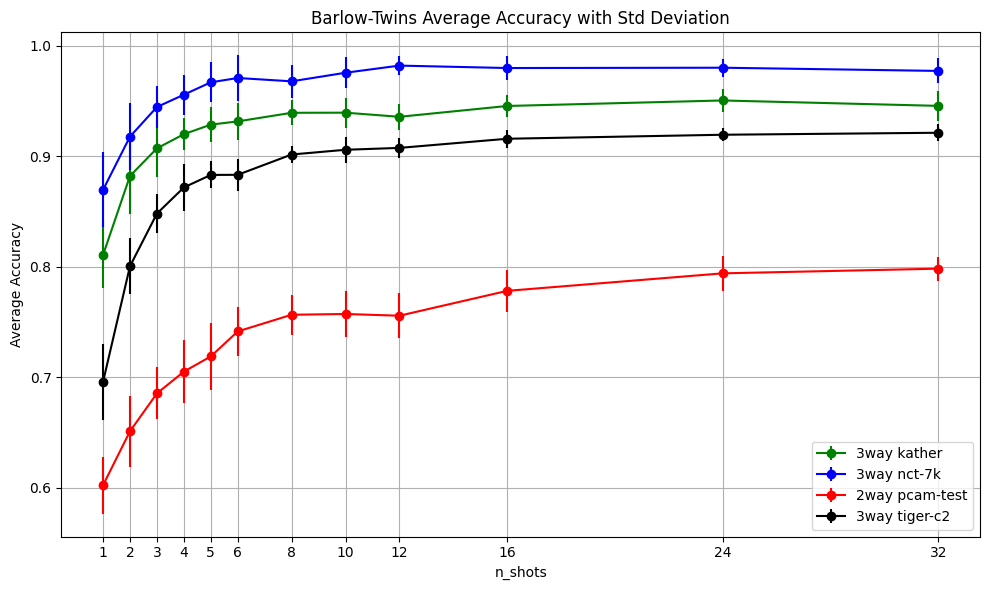

yeah!


In [ ]:
# Extract n_shots and avg_accuracy columns
shots = merged_df_k['n_shots']
avg_acc = merged_df_k['mean']
std_acc = merged_df_k['std']

avg_acc2 = merged_df_nct['mean']
std_acc2 = merged_df_nct['std']

avg_acc3 = merged_df_p['mean']
std_acc3 = merged_df_p['std']

avg_acc4 = merged_df_t2['mean']
std_acc4 = merged_df_t2['std']

# Create the plot
plt.figure(figsize=(10, 6))
plt.errorbar(shots, avg_acc, yerr=std_acc, fmt='-o', color='g', label='3way kather')
plt.errorbar(shots, avg_acc2, yerr=std_acc2, fmt='-o', color='b', label='3way nct-7k')
plt.errorbar(shots, avg_acc3, yerr=std_acc3, fmt='-o', color='r', label='2way pcam-test')
plt.errorbar(shots, avg_acc4, yerr=std_acc4, fmt='-o', color='k', label='3way tiger-c2')
plt.title('Barlow-Twins Average Accuracy with Std Deviation')
plt.xlabel('n_shots')
plt.ylabel('Average Accuracy')
plt.grid(True)
plt.xticks(shots)
plt.legend()
plt.tight_layout()
plot_filename = "barlow-twins_few-shot_inference.png"
plt.savefig(os.path.join(output_directory_k, plot_filename), dpi=600, format='png')

# Show the plot
plt.show()
print("yeah!")

In [ ]:
output_directory_p = Path("/home/rakib/models/paper_benchmarking_ssl_diverse_pathology/inference/pcam/pcam_test/bt/2")
#data_to_test = "/home/rakib/data/TIGER"
data_to_test = Path("/home/rakib/data/pcamv1/pcam_test/")
transform = transforms.Compose([transforms.Resize((96, 96)),
                                transforms.ToTensor()])
testset = torchvision.datasets.ImageFolder(data_to_test, transform=transform)

classes = testset.classes

print(classes)
dataloader = DataLoader(testset, batch_size=100, shuffle=False, drop_last=False)
p2_emb_df = predict_embeddings(dataloader, model, device=device)
p2_emb_dataset = FeaturesDataset.from_dataframe(p2_emb_df)
p2_results_df = evaluate_few_shot_model(p2_emb_dataset, model, device=device, n_way=2)
p2_results_df.sort_values(["n_shots", "accuracy"])

mean_accuracies_p2 = p2_results_df.groupby("n_shots")["accuracy"].mean().reset_index()
mean_accuracies_p2.rename(columns={"accuracy": "mean"}, inplace=True)
std_accuracies_p2 = p2_results_df.groupby("n_shots")["accuracy"].std().reset_index()
std_accuracies_p2.rename(columns={"accuracy": "std"}, inplace=True)
# Merge the two DataFrames based on the 'n_shots' column
merged_df_p2 = pd.merge(mean_accuracies_p2, std_accuracies_p2, on="n_shots")

# Save the average accuracy information in a separate CSV file
#acc_csv_filename = "2way_average_accuracy_pcam-test_bt.csv"
#merged_df_p.to_csv(os.path.join(output_directory_p, acc_csv_filename), index=False)

['Norm', 'Tum']


100%|███████████████████████████| 10/10 [00:00<00:00, 42.19it/s, accuracy=0.558]

n_shots=1, Run=1, Accuracy: 55.85 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.93it/s, accuracy=0.639]

n_shots=2, Run=1, Accuracy: 63.95 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.66it/s, accuracy=0.625]


n_shots=3, Run=1, Accuracy: 62.50 %


100%|██████████████████████████| 10/10 [00:00<00:00, 119.23it/s, accuracy=0.653]


n_shots=4, Run=1, Accuracy: 65.30 %


100%|██████████████████████████| 10/10 [00:00<00:00, 117.56it/s, accuracy=0.707]


n_shots=5, Run=1, Accuracy: 70.65 %


100%|██████████████████████████| 10/10 [00:00<00:00, 116.81it/s, accuracy=0.663]


n_shots=6, Run=1, Accuracy: 66.35 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.12it/s, accuracy=0.706]


n_shots=8, Run=1, Accuracy: 70.60 %


100%|███████████████████████████| 10/10 [00:00<00:00, 119.03it/s, accuracy=0.73]


n_shots=10, Run=1, Accuracy: 72.95 %


100%|██████████████████████████| 10/10 [00:00<00:00, 118.35it/s, accuracy=0.735]


n_shots=12, Run=1, Accuracy: 73.50 %


100%|██████████████████████████| 10/10 [00:00<00:00, 119.12it/s, accuracy=0.738]


n_shots=16, Run=1, Accuracy: 73.75 %


100%|███████████████████████████| 10/10 [00:00<00:00, 122.34it/s, accuracy=0.78]


n_shots=24, Run=1, Accuracy: 78.05 %


100%|██████████████████████████| 10/10 [00:00<00:00, 108.91it/s, accuracy=0.757]


n_shots=32, Run=1, Accuracy: 75.75 %


100%|███████████████████████████| 10/10 [00:00<00:00, 117.32it/s, accuracy=0.56]


n_shots=1, Run=2, Accuracy: 56.05 %


100%|██████████████████████████| 10/10 [00:00<00:00, 120.87it/s, accuracy=0.598]


n_shots=2, Run=2, Accuracy: 59.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 118.06it/s, accuracy=0.632]


n_shots=3, Run=2, Accuracy: 63.20 %


100%|██████████████████████████| 10/10 [00:00<00:00, 119.78it/s, accuracy=0.689]


n_shots=4, Run=2, Accuracy: 68.85 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.02it/s, accuracy=0.671]


n_shots=5, Run=2, Accuracy: 67.15 %


100%|██████████████████████████| 10/10 [00:00<00:00, 110.63it/s, accuracy=0.729]

n_shots=6, Run=2, Accuracy: 72.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.22it/s, accuracy=0.735]

n_shots=8, Run=2, Accuracy: 73.45 %



100%|██████████████████████████| 10/10 [00:00<00:00, 118.70it/s, accuracy=0.746]

n_shots=10, Run=2, Accuracy: 74.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 119.79it/s, accuracy=0.724]


n_shots=12, Run=2, Accuracy: 72.35 %


100%|██████████████████████████| 10/10 [00:00<00:00, 117.80it/s, accuracy=0.771]


n_shots=16, Run=2, Accuracy: 77.15 %


100%|███████████████████████████| 10/10 [00:00<00:00, 118.78it/s, accuracy=0.77]


n_shots=24, Run=2, Accuracy: 77.05 %


100%|███████████████████████████| 10/10 [00:00<00:00, 117.27it/s, accuracy=0.78]


n_shots=32, Run=2, Accuracy: 78.00 %


100%|██████████████████████████| 10/10 [00:00<00:00, 115.58it/s, accuracy=0.568]


n_shots=1, Run=3, Accuracy: 56.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.66it/s, accuracy=0.662]


n_shots=2, Run=3, Accuracy: 66.25 %


100%|██████████████████████████| 10/10 [00:00<00:00, 119.63it/s, accuracy=0.643]


n_shots=3, Run=3, Accuracy: 64.30 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.76it/s, accuracy=0.663]


n_shots=4, Run=3, Accuracy: 66.30 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.50it/s, accuracy=0.706]


n_shots=5, Run=3, Accuracy: 70.55 %


100%|████████████████████████████| 10/10 [00:00<00:00, 119.86it/s, accuracy=0.7]


n_shots=6, Run=3, Accuracy: 70.00 %


100%|██████████████████████████| 10/10 [00:00<00:00, 120.69it/s, accuracy=0.696]


n_shots=8, Run=3, Accuracy: 69.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 118.87it/s, accuracy=0.751]


n_shots=10, Run=3, Accuracy: 75.15 %


100%|██████████████████████████| 10/10 [00:00<00:00, 118.15it/s, accuracy=0.747]


n_shots=12, Run=3, Accuracy: 74.70 %


100%|███████████████████████████| 10/10 [00:00<00:00, 117.49it/s, accuracy=0.74]


n_shots=16, Run=3, Accuracy: 73.95 %


100%|██████████████████████████| 10/10 [00:00<00:00, 117.91it/s, accuracy=0.759]


n_shots=24, Run=3, Accuracy: 75.95 %


100%|███████████████████████████| 10/10 [00:00<00:00, 120.25it/s, accuracy=0.76]


n_shots=32, Run=3, Accuracy: 76.05 %


100%|██████████████████████████| 10/10 [00:00<00:00, 116.12it/s, accuracy=0.566]


n_shots=1, Run=4, Accuracy: 56.55 %


100%|██████████████████████████| 10/10 [00:00<00:00, 119.52it/s, accuracy=0.611]


n_shots=2, Run=4, Accuracy: 61.10 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.24it/s, accuracy=0.679]


n_shots=3, Run=4, Accuracy: 67.90 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.65it/s, accuracy=0.722]


n_shots=4, Run=4, Accuracy: 72.20 %


100%|██████████████████████████| 10/10 [00:00<00:00, 123.07it/s, accuracy=0.691]


n_shots=5, Run=4, Accuracy: 69.05 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.95it/s, accuracy=0.741]


n_shots=6, Run=4, Accuracy: 74.05 %


100%|██████████████████████████| 10/10 [00:00<00:00, 116.68it/s, accuracy=0.707]


n_shots=8, Run=4, Accuracy: 70.70 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.05it/s, accuracy=0.749]

n_shots=10, Run=4, Accuracy: 74.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.20it/s, accuracy=0.705]

n_shots=12, Run=4, Accuracy: 70.45 %



100%|██████████████████████████| 10/10 [00:00<00:00, 122.05it/s, accuracy=0.764]


n_shots=16, Run=4, Accuracy: 76.40 %


100%|██████████████████████████| 10/10 [00:00<00:00, 119.92it/s, accuracy=0.756]


n_shots=24, Run=4, Accuracy: 75.65 %


100%|██████████████████████████| 10/10 [00:00<00:00, 116.37it/s, accuracy=0.797]


n_shots=32, Run=4, Accuracy: 79.75 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.05it/s, accuracy=0.567]


n_shots=1, Run=5, Accuracy: 56.70 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.01it/s, accuracy=0.608]


n_shots=2, Run=5, Accuracy: 60.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 119.53it/s, accuracy=0.616]


n_shots=3, Run=5, Accuracy: 61.55 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.07it/s, accuracy=0.652]


n_shots=4, Run=5, Accuracy: 65.20 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.83it/s, accuracy=0.689]


n_shots=5, Run=5, Accuracy: 68.85 %


100%|██████████████████████████| 10/10 [00:00<00:00, 119.88it/s, accuracy=0.714]


n_shots=6, Run=5, Accuracy: 71.40 %


100%|██████████████████████████| 10/10 [00:00<00:00, 116.14it/s, accuracy=0.677]


n_shots=8, Run=5, Accuracy: 67.70 %


100%|███████████████████████████| 10/10 [00:00<00:00, 117.72it/s, accuracy=0.73]


n_shots=10, Run=5, Accuracy: 72.95 %


100%|██████████████████████████| 10/10 [00:00<00:00, 120.90it/s, accuracy=0.704]


n_shots=12, Run=5, Accuracy: 70.35 %


100%|██████████████████████████| 10/10 [00:00<00:00, 120.84it/s, accuracy=0.772]


n_shots=16, Run=5, Accuracy: 77.20 %


100%|██████████████████████████| 10/10 [00:00<00:00, 118.15it/s, accuracy=0.786]


n_shots=24, Run=5, Accuracy: 78.65 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.58it/s, accuracy=0.757]


n_shots=32, Run=5, Accuracy: 75.70 %


100%|██████████████████████████| 10/10 [00:00<00:00, 118.59it/s, accuracy=0.558]


n_shots=1, Run=6, Accuracy: 55.85 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.17it/s, accuracy=0.663]


n_shots=2, Run=6, Accuracy: 66.35 %


100%|██████████████████████████| 10/10 [00:00<00:00, 123.00it/s, accuracy=0.624]


n_shots=3, Run=6, Accuracy: 62.40 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.05it/s, accuracy=0.706]


n_shots=4, Run=6, Accuracy: 70.60 %


100%|███████████████████████████| 10/10 [00:00<00:00, 107.91it/s, accuracy=0.64]

n_shots=5, Run=6, Accuracy: 64.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.22it/s, accuracy=0.648]

n_shots=6, Run=6, Accuracy: 64.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.39it/s, accuracy=0.719]

n_shots=8, Run=6, Accuracy: 71.85 %



100%|██████████████████████████| 10/10 [00:00<00:00, 118.73it/s, accuracy=0.742]


n_shots=10, Run=6, Accuracy: 74.20 %


100%|███████████████████████████| 10/10 [00:00<00:00, 121.44it/s, accuracy=0.73]


n_shots=12, Run=6, Accuracy: 72.95 %


100%|██████████████████████████| 10/10 [00:00<00:00, 119.86it/s, accuracy=0.772]


n_shots=16, Run=6, Accuracy: 77.20 %


100%|███████████████████████████| 10/10 [00:00<00:00, 119.29it/s, accuracy=0.76]


n_shots=24, Run=6, Accuracy: 76.00 %


100%|██████████████████████████| 10/10 [00:00<00:00, 117.78it/s, accuracy=0.802]


n_shots=32, Run=6, Accuracy: 80.20 %


100%|██████████████████████████| 10/10 [00:00<00:00, 111.92it/s, accuracy=0.603]


n_shots=1, Run=7, Accuracy: 60.30 %


100%|██████████████████████████| 10/10 [00:00<00:00, 121.22it/s, accuracy=0.619]


n_shots=2, Run=7, Accuracy: 61.85 %


100%|██████████████████████████| 10/10 [00:00<00:00, 117.55it/s, accuracy=0.707]


n_shots=3, Run=7, Accuracy: 70.65 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.79it/s, accuracy=0.662]


n_shots=4, Run=7, Accuracy: 66.25 %


100%|██████████████████████████| 10/10 [00:00<00:00, 119.14it/s, accuracy=0.697]


n_shots=5, Run=7, Accuracy: 69.65 %


100%|██████████████████████████| 10/10 [00:00<00:00, 120.62it/s, accuracy=0.668]


n_shots=6, Run=7, Accuracy: 66.85 %


100%|██████████████████████████| 10/10 [00:00<00:00, 110.18it/s, accuracy=0.729]


n_shots=8, Run=7, Accuracy: 72.85 %


100%|████████████████████████████| 10/10 [00:00<00:00, 116.44it/s, accuracy=0.7]


n_shots=10, Run=7, Accuracy: 70.00 %


100%|██████████████████████████| 10/10 [00:00<00:00, 120.51it/s, accuracy=0.707]


n_shots=12, Run=7, Accuracy: 70.65 %


100%|███████████████████████████| 10/10 [00:00<00:00, 118.40it/s, accuracy=0.75]


n_shots=16, Run=7, Accuracy: 75.05 %


100%|██████████████████████████| 10/10 [00:00<00:00, 117.87it/s, accuracy=0.758]


n_shots=24, Run=7, Accuracy: 75.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 119.72it/s, accuracy=0.768]


n_shots=32, Run=7, Accuracy: 76.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.62it/s, accuracy=0.583]


n_shots=1, Run=8, Accuracy: 58.25 %


100%|██████████████████████████| 10/10 [00:00<00:00, 121.76it/s, accuracy=0.615]


n_shots=2, Run=8, Accuracy: 61.50 %


100%|██████████████████████████| 10/10 [00:00<00:00, 116.62it/s, accuracy=0.664]


n_shots=3, Run=8, Accuracy: 66.45 %


100%|███████████████████████████| 10/10 [00:00<00:00, 89.40it/s, accuracy=0.679]

n_shots=4, Run=8, Accuracy: 67.95 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.98it/s, accuracy=0.696]

n_shots=5, Run=8, Accuracy: 69.55 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.60it/s, accuracy=0.729]

n_shots=6, Run=8, Accuracy: 72.85 %



100%|██████████████████████████| 10/10 [00:00<00:00, 117.29it/s, accuracy=0.728]

n_shots=8, Run=8, Accuracy: 72.75 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.05it/s, accuracy=0.709]

n_shots=10, Run=8, Accuracy: 70.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.66it/s, accuracy=0.771]

n_shots=12, Run=8, Accuracy: 77.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.55it/s, accuracy=0.741]

n_shots=16, Run=8, Accuracy: 74.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 109.84it/s, accuracy=0.79]

n_shots=24, Run=8, Accuracy: 79.05 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.48it/s, accuracy=0.789]

n_shots=32, Run=8, Accuracy: 78.95 %



100%|███████████████████████████| 10/10 [00:00<00:00, 103.60it/s, accuracy=0.59]

n_shots=1, Run=9, Accuracy: 58.95 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.00it/s, accuracy=0.588]

n_shots=2, Run=9, Accuracy: 58.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.23it/s, accuracy=0.661]

n_shots=3, Run=9, Accuracy: 66.15 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.97it/s, accuracy=0.653]

n_shots=4, Run=9, Accuracy: 65.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.56it/s, accuracy=0.659]

n_shots=5, Run=9, Accuracy: 65.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.03it/s, accuracy=0.684]

n_shots=6, Run=9, Accuracy: 68.45 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.56it/s, accuracy=0.691]

n_shots=8, Run=9, Accuracy: 69.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.95it/s, accuracy=0.718]

n_shots=10, Run=9, Accuracy: 71.75 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.39it/s, accuracy=0.764]

n_shots=12, Run=9, Accuracy: 76.45 %



100%|██████████████████████████| 10/10 [00:00<00:00, 118.79it/s, accuracy=0.737]

n_shots=16, Run=9, Accuracy: 73.65 %



100%|██████████████████████████| 10/10 [00:00<00:00, 115.60it/s, accuracy=0.785]


n_shots=24, Run=9, Accuracy: 78.55 %


100%|██████████████████████████| 10/10 [00:00<00:00, 116.64it/s, accuracy=0.778]


n_shots=32, Run=9, Accuracy: 77.85 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.10it/s, accuracy=0.583]


n_shots=1, Run=10, Accuracy: 58.25 %


100%|██████████████████████████| 10/10 [00:00<00:00, 118.22it/s, accuracy=0.639]


n_shots=2, Run=10, Accuracy: 63.95 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.26it/s, accuracy=0.689]

n_shots=3, Run=10, Accuracy: 68.85 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.04it/s, accuracy=0.708]

n_shots=4, Run=10, Accuracy: 70.75 %



100%|██████████████████████████| 10/10 [00:00<00:00, 112.93it/s, accuracy=0.686]

n_shots=5, Run=10, Accuracy: 68.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 118.15it/s, accuracy=0.673]


n_shots=6, Run=10, Accuracy: 67.30 %


100%|██████████████████████████| 10/10 [00:00<00:00, 120.55it/s, accuracy=0.719]


n_shots=8, Run=10, Accuracy: 71.85 %


100%|██████████████████████████| 10/10 [00:00<00:00, 121.50it/s, accuracy=0.742]


n_shots=10, Run=10, Accuracy: 74.20 %


100%|██████████████████████████| 10/10 [00:00<00:00, 108.29it/s, accuracy=0.742]


n_shots=12, Run=10, Accuracy: 74.15 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.33it/s, accuracy=0.724]

n_shots=16, Run=10, Accuracy: 72.35 %



100%|███████████████████████████| 10/10 [00:00<00:00, 89.80it/s, accuracy=0.775]

n_shots=24, Run=10, Accuracy: 77.55 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.10it/s, accuracy=0.775]

n_shots=32, Run=10, Accuracy: 77.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.67it/s, accuracy=0.573]

n_shots=1, Run=11, Accuracy: 57.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.94it/s, accuracy=0.656]

n_shots=2, Run=11, Accuracy: 65.65 %



100%|██████████████████████████| 10/10 [00:00<00:00, 116.74it/s, accuracy=0.669]


n_shots=3, Run=11, Accuracy: 66.95 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.02it/s, accuracy=0.664]

n_shots=4, Run=11, Accuracy: 66.45 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.75it/s, accuracy=0.686]

n_shots=5, Run=11, Accuracy: 68.65 %



100%|██████████████████████████| 10/10 [00:00<00:00, 112.67it/s, accuracy=0.726]

n_shots=6, Run=11, Accuracy: 72.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.71it/s, accuracy=0.725]

n_shots=8, Run=11, Accuracy: 72.45 %



100%|██████████████████████████| 10/10 [00:00<00:00, 113.16it/s, accuracy=0.744]

n_shots=10, Run=11, Accuracy: 74.35 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.05it/s, accuracy=0.761]

n_shots=12, Run=11, Accuracy: 76.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.48it/s, accuracy=0.732]

n_shots=16, Run=11, Accuracy: 73.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.44it/s, accuracy=0.785]

n_shots=24, Run=11, Accuracy: 78.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 105.88it/s, accuracy=0.78]

n_shots=32, Run=11, Accuracy: 78.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.65it/s, accuracy=0.594]

n_shots=1, Run=12, Accuracy: 59.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.39it/s, accuracy=0.631]


n_shots=2, Run=12, Accuracy: 63.15 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.96it/s, accuracy=0.628]


n_shots=3, Run=12, Accuracy: 62.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 111.17it/s, accuracy=0.694]

n_shots=4, Run=12, Accuracy: 69.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.96it/s, accuracy=0.686]

n_shots=5, Run=12, Accuracy: 68.65 %



100%|██████████████████████████| 10/10 [00:00<00:00, 112.24it/s, accuracy=0.663]

n_shots=6, Run=12, Accuracy: 66.35 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.75it/s, accuracy=0.728]

n_shots=8, Run=12, Accuracy: 72.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 103.84it/s, accuracy=0.76]

n_shots=10, Run=12, Accuracy: 76.05 %



100%|██████████████████████████| 10/10 [00:00<00:00, 113.19it/s, accuracy=0.752]

n_shots=12, Run=12, Accuracy: 75.25 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.37it/s, accuracy=0.761]

n_shots=16, Run=12, Accuracy: 76.15 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.19it/s, accuracy=0.777]

n_shots=24, Run=12, Accuracy: 77.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 102.86it/s, accuracy=0.783]

n_shots=32, Run=12, Accuracy: 78.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.72it/s, accuracy=0.586]

n_shots=1, Run=13, Accuracy: 58.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 121.43it/s, accuracy=0.631]


n_shots=2, Run=13, Accuracy: 63.10 %


100%|██████████████████████████| 10/10 [00:00<00:00, 116.19it/s, accuracy=0.666]


n_shots=3, Run=13, Accuracy: 66.65 %


100%|██████████████████████████| 10/10 [00:00<00:00, 115.96it/s, accuracy=0.662]

n_shots=4, Run=13, Accuracy: 66.20 %



100%|███████████████████████████| 10/10 [00:00<00:00, 111.91it/s, accuracy=0.67]


n_shots=5, Run=13, Accuracy: 67.05 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.93it/s, accuracy=0.731]


n_shots=6, Run=13, Accuracy: 73.10 %


100%|██████████████████████████| 10/10 [00:00<00:00, 108.96it/s, accuracy=0.682]


n_shots=8, Run=13, Accuracy: 68.25 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.89it/s, accuracy=0.738]

n_shots=10, Run=13, Accuracy: 73.75 %



100%|██████████████████████████| 10/10 [00:00<00:00, 116.23it/s, accuracy=0.738]

n_shots=12, Run=13, Accuracy: 73.75 %



100%|██████████████████████████| 10/10 [00:00<00:00, 113.98it/s, accuracy=0.774]


n_shots=16, Run=13, Accuracy: 77.40 %


100%|██████████████████████████| 10/10 [00:00<00:00, 107.30it/s, accuracy=0.754]

n_shots=24, Run=13, Accuracy: 75.45 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.43it/s, accuracy=0.774]

n_shots=32, Run=13, Accuracy: 77.45 %



100%|███████████████████████████| 10/10 [00:00<00:00, 115.63it/s, accuracy=0.53]


n_shots=1, Run=14, Accuracy: 53.00 %


100%|██████████████████████████| 10/10 [00:00<00:00, 107.07it/s, accuracy=0.554]

n_shots=2, Run=14, Accuracy: 55.45 %



100%|███████████████████████████| 10/10 [00:00<00:00, 111.81it/s, accuracy=0.64]

n_shots=3, Run=14, Accuracy: 64.05 %



100%|██████████████████████████| 10/10 [00:00<00:00, 121.25it/s, accuracy=0.683]


n_shots=4, Run=14, Accuracy: 68.30 %


100%|██████████████████████████| 10/10 [00:00<00:00, 118.04it/s, accuracy=0.671]


n_shots=5, Run=14, Accuracy: 67.10 %


100%|██████████████████████████| 10/10 [00:00<00:00, 121.87it/s, accuracy=0.686]


n_shots=6, Run=14, Accuracy: 68.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.31it/s, accuracy=0.703]


n_shots=8, Run=14, Accuracy: 70.25 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.38it/s, accuracy=0.733]

n_shots=10, Run=14, Accuracy: 73.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.33it/s, accuracy=0.763]

n_shots=12, Run=14, Accuracy: 76.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 101.12it/s, accuracy=0.76]

n_shots=16, Run=14, Accuracy: 76.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 102.71it/s, accuracy=0.769]

n_shots=24, Run=14, Accuracy: 76.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.96it/s, accuracy=0.782]

n_shots=32, Run=14, Accuracy: 78.25 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.85it/s, accuracy=0.564]

n_shots=1, Run=15, Accuracy: 56.35 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.06it/s, accuracy=0.613]

n_shots=2, Run=15, Accuracy: 61.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.62it/s, accuracy=0.654]

n_shots=3, Run=15, Accuracy: 65.40 %



100%|███████████████████████████| 10/10 [00:00<00:00, 107.06it/s, accuracy=0.69]

n_shots=4, Run=15, Accuracy: 68.95 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.75it/s, accuracy=0.703]

n_shots=5, Run=15, Accuracy: 70.25 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.46it/s, accuracy=0.737]

n_shots=6, Run=15, Accuracy: 73.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.27it/s, accuracy=0.676]

n_shots=8, Run=15, Accuracy: 67.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.25it/s, accuracy=0.713]

n_shots=10, Run=15, Accuracy: 71.25 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.08it/s, accuracy=0.745]

n_shots=12, Run=15, Accuracy: 74.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.80it/s, accuracy=0.742]

n_shots=16, Run=15, Accuracy: 74.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 118.65it/s, accuracy=0.781]


n_shots=24, Run=15, Accuracy: 78.10 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.54it/s, accuracy=0.787]


n_shots=32, Run=15, Accuracy: 78.75 %


100%|██████████████████████████| 10/10 [00:00<00:00, 117.08it/s, accuracy=0.583]


n_shots=1, Run=16, Accuracy: 58.25 %


100%|██████████████████████████| 10/10 [00:00<00:00, 110.02it/s, accuracy=0.642]

n_shots=2, Run=16, Accuracy: 64.25 %



100%|██████████████████████████| 10/10 [00:00<00:00, 119.78it/s, accuracy=0.677]


n_shots=3, Run=16, Accuracy: 67.70 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.57it/s, accuracy=0.685]


n_shots=4, Run=16, Accuracy: 68.50 %


100%|██████████████████████████| 10/10 [00:00<00:00, 102.10it/s, accuracy=0.703]

n_shots=5, Run=16, Accuracy: 70.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 118.03it/s, accuracy=0.674]

n_shots=6, Run=16, Accuracy: 67.45 %



100%|██████████████████████████| 10/10 [00:00<00:00, 121.01it/s, accuracy=0.705]


n_shots=8, Run=16, Accuracy: 70.45 %


100%|██████████████████████████| 10/10 [00:00<00:00, 117.15it/s, accuracy=0.759]


n_shots=10, Run=16, Accuracy: 75.95 %


100%|██████████████████████████| 10/10 [00:00<00:00, 119.02it/s, accuracy=0.739]


n_shots=12, Run=16, Accuracy: 73.85 %


100%|██████████████████████████| 10/10 [00:00<00:00, 121.41it/s, accuracy=0.761]


n_shots=16, Run=16, Accuracy: 76.10 %


100%|██████████████████████████| 10/10 [00:00<00:00, 121.48it/s, accuracy=0.742]


n_shots=24, Run=16, Accuracy: 74.15 %


100%|██████████████████████████| 10/10 [00:00<00:00, 119.30it/s, accuracy=0.798]


n_shots=32, Run=16, Accuracy: 79.85 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.74it/s, accuracy=0.581]


n_shots=1, Run=17, Accuracy: 58.05 %


100%|██████████████████████████| 10/10 [00:00<00:00, 117.63it/s, accuracy=0.638]


n_shots=2, Run=17, Accuracy: 63.85 %


100%|██████████████████████████| 10/10 [00:00<00:00, 116.11it/s, accuracy=0.637]


n_shots=3, Run=17, Accuracy: 63.75 %


100%|██████████████████████████| 10/10 [00:00<00:00, 105.17it/s, accuracy=0.643]

n_shots=4, Run=17, Accuracy: 64.35 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.70it/s, accuracy=0.713]

n_shots=5, Run=17, Accuracy: 71.25 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.37it/s, accuracy=0.688]

n_shots=6, Run=17, Accuracy: 68.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.94it/s, accuracy=0.744]

n_shots=8, Run=17, Accuracy: 74.35 %



100%|██████████████████████████| 10/10 [00:00<00:00, 119.12it/s, accuracy=0.723]


n_shots=10, Run=17, Accuracy: 72.25 %


100%|██████████████████████████| 10/10 [00:00<00:00, 119.91it/s, accuracy=0.711]


n_shots=12, Run=17, Accuracy: 71.05 %


100%|██████████████████████████| 10/10 [00:00<00:00, 119.35it/s, accuracy=0.755]


n_shots=16, Run=17, Accuracy: 75.55 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.95it/s, accuracy=0.773]


n_shots=24, Run=17, Accuracy: 77.30 %


100%|██████████████████████████| 10/10 [00:00<00:00, 110.25it/s, accuracy=0.771]

n_shots=32, Run=17, Accuracy: 77.15 %



100%|███████████████████████████| 10/10 [00:00<00:00, 109.20it/s, accuracy=0.58]

n_shots=1, Run=18, Accuracy: 58.00 %



100%|█████████████████████████████| 10/10 [00:00<00:00, 99.72it/s, accuracy=0.6]

n_shots=2, Run=18, Accuracy: 59.95 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.56it/s, accuracy=0.673]

n_shots=3, Run=18, Accuracy: 67.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.71it/s, accuracy=0.658]

n_shots=4, Run=18, Accuracy: 65.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.50it/s, accuracy=0.697]

n_shots=5, Run=18, Accuracy: 69.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.37it/s, accuracy=0.673]

n_shots=6, Run=18, Accuracy: 67.35 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.91it/s, accuracy=0.689]

n_shots=8, Run=18, Accuracy: 68.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.25it/s, accuracy=0.725]

n_shots=10, Run=18, Accuracy: 72.45 %



100%|████████████████████████████| 10/10 [00:00<00:00, 81.58it/s, accuracy=0.71]

n_shots=12, Run=18, Accuracy: 71.00 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.30it/s, accuracy=0.753]

n_shots=16, Run=18, Accuracy: 75.35 %



100%|███████████████████████████| 10/10 [00:00<00:00, 101.21it/s, accuracy=0.78]

n_shots=24, Run=18, Accuracy: 78.05 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.37it/s, accuracy=0.791]

n_shots=32, Run=18, Accuracy: 79.15 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.48it/s, accuracy=0.587]

n_shots=1, Run=19, Accuracy: 58.65 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.22it/s, accuracy=0.639]

n_shots=2, Run=19, Accuracy: 63.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.88it/s, accuracy=0.662]

n_shots=3, Run=19, Accuracy: 66.25 %



100%|███████████████████████████| 10/10 [00:00<00:00, 111.71it/s, accuracy=0.62]

n_shots=4, Run=19, Accuracy: 61.95 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.39it/s, accuracy=0.682]

n_shots=5, Run=19, Accuracy: 68.25 %



100%|████████████████████████████| 10/10 [00:00<00:00, 109.94it/s, accuracy=0.7]

n_shots=6, Run=19, Accuracy: 69.95 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.96it/s, accuracy=0.702]

n_shots=8, Run=19, Accuracy: 70.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.52it/s, accuracy=0.753]

n_shots=10, Run=19, Accuracy: 75.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.15it/s, accuracy=0.721]

n_shots=12, Run=19, Accuracy: 72.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.10it/s, accuracy=0.762]

n_shots=16, Run=19, Accuracy: 76.25 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.71it/s, accuracy=0.765]

n_shots=24, Run=19, Accuracy: 76.55 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.28it/s, accuracy=0.775]

n_shots=32, Run=19, Accuracy: 77.55 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.45it/s, accuracy=0.589]

n_shots=1, Run=20, Accuracy: 58.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.14it/s, accuracy=0.603]

n_shots=2, Run=20, Accuracy: 60.25 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.83it/s, accuracy=0.648]

n_shots=3, Run=20, Accuracy: 64.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 110.16it/s, accuracy=0.64]

n_shots=4, Run=20, Accuracy: 64.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.58it/s, accuracy=0.664]

n_shots=5, Run=20, Accuracy: 66.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.34it/s, accuracy=0.717]

n_shots=6, Run=20, Accuracy: 71.65 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.25it/s, accuracy=0.715]

n_shots=8, Run=20, Accuracy: 71.45 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.87it/s, accuracy=0.743]

n_shots=10, Run=20, Accuracy: 74.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.12it/s, accuracy=0.755]

n_shots=12, Run=20, Accuracy: 75.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.24it/s, accuracy=0.748]

n_shots=16, Run=20, Accuracy: 74.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.99it/s, accuracy=0.761]

n_shots=24, Run=20, Accuracy: 76.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 102.79it/s, accuracy=0.801]

n_shots=32, Run=20, Accuracy: 80.15 %


mean: [0.70322989, 0.53606487, 0.66096631]
std: [0.21716536, 0.26081574, 0.20723464]

In [ ]:
transform = transforms.Compose([transforms.CenterCrop((96, 96)),
                                transforms.Resize((96, 96)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.70322989, 0.53606487, 0.66096631], std=[0.21716536, 0.26081574, 0.20723464])])
testset = torchvision.datasets.ImageFolder(data_to_test, transform=transform)

classes = testset.classes

print(classes)
dataloader = DataLoader(testset, batch_size=100, shuffle=False, drop_last=False)
p3_emb_df = predict_embeddings(dataloader, model, device=device)
p3_emb_dataset = FeaturesDataset.from_dataframe(p3_emb_df)
p3_results_df = evaluate_few_shot_model(p3_emb_dataset, model, device=device, n_way=2)
p3_results_df.sort_values(["n_shots", "accuracy"])

mean_accuracies_p3 = p3_results_df.groupby("n_shots")["accuracy"].mean().reset_index()
mean_accuracies_p3.rename(columns={"accuracy": "mean"}, inplace=True)
std_accuracies_p3 = p3_results_df.groupby("n_shots")["accuracy"].std().reset_index()
std_accuracies_p3.rename(columns={"accuracy": "std"}, inplace=True)
# Merge the two DataFrames based on the 'n_shots' column
merged_df_p3 = pd.merge(mean_accuracies_p3, std_accuracies_p3, on="n_shots")

['Norm', 'Tum']


100%|███████████████████████████| 10/10 [00:00<00:00, 61.85it/s, accuracy=0.503]

n_shots=1, Run=1, Accuracy: 50.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.31it/s, accuracy=0.614]

n_shots=2, Run=1, Accuracy: 61.40 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.53it/s, accuracy=0.629]

n_shots=3, Run=1, Accuracy: 62.95 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.51it/s, accuracy=0.692]

n_shots=4, Run=1, Accuracy: 69.20 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.41it/s, accuracy=0.688]

n_shots=5, Run=1, Accuracy: 68.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.54it/s, accuracy=0.687]

n_shots=6, Run=1, Accuracy: 68.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.41it/s, accuracy=0.736]

n_shots=8, Run=1, Accuracy: 73.55 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.08it/s, accuracy=0.705]

n_shots=10, Run=1, Accuracy: 70.45 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.23it/s, accuracy=0.716]

n_shots=12, Run=1, Accuracy: 71.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.05it/s, accuracy=0.739]

n_shots=16, Run=1, Accuracy: 73.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.49it/s, accuracy=0.795]

n_shots=24, Run=1, Accuracy: 79.55 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.53it/s, accuracy=0.753]

n_shots=32, Run=1, Accuracy: 75.35 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.01it/s, accuracy=0.578]

n_shots=1, Run=2, Accuracy: 57.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.62it/s, accuracy=0.622]

n_shots=2, Run=2, Accuracy: 62.20 %



100%|████████████████████████████| 10/10 [00:00<00:00, 97.09it/s, accuracy=0.62]

n_shots=3, Run=2, Accuracy: 61.95 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.96it/s, accuracy=0.696]

n_shots=4, Run=2, Accuracy: 69.55 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.24it/s, accuracy=0.709]

n_shots=5, Run=2, Accuracy: 70.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.18it/s, accuracy=0.656]

n_shots=6, Run=2, Accuracy: 65.65 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.86it/s, accuracy=0.685]

n_shots=8, Run=2, Accuracy: 68.55 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.57it/s, accuracy=0.731]

n_shots=10, Run=2, Accuracy: 73.05 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.86it/s, accuracy=0.738]

n_shots=12, Run=2, Accuracy: 73.80 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.62it/s, accuracy=0.728]

n_shots=16, Run=2, Accuracy: 72.80 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.00it/s, accuracy=0.785]

n_shots=24, Run=2, Accuracy: 78.55 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.12it/s, accuracy=0.768]

n_shots=32, Run=2, Accuracy: 76.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 92.13it/s, accuracy=0.569]

n_shots=1, Run=3, Accuracy: 56.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.00it/s, accuracy=0.591]

n_shots=2, Run=3, Accuracy: 59.05 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.41it/s, accuracy=0.644]

n_shots=3, Run=3, Accuracy: 64.45 %



100%|███████████████████████████| 10/10 [00:00<00:00, 100.67it/s, accuracy=0.68]

n_shots=4, Run=3, Accuracy: 68.05 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.68it/s, accuracy=0.693]

n_shots=5, Run=3, Accuracy: 69.25 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.08it/s, accuracy=0.676]

n_shots=6, Run=3, Accuracy: 67.60 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.26it/s, accuracy=0.702]

n_shots=8, Run=3, Accuracy: 70.20 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.94it/s, accuracy=0.712]

n_shots=10, Run=3, Accuracy: 71.20 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.96it/s, accuracy=0.714]

n_shots=12, Run=3, Accuracy: 71.35 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.53it/s, accuracy=0.717]

n_shots=16, Run=3, Accuracy: 71.65 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.64it/s, accuracy=0.758]

n_shots=24, Run=3, Accuracy: 75.80 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.31it/s, accuracy=0.773]

n_shots=32, Run=3, Accuracy: 77.35 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.38it/s, accuracy=0.578]

n_shots=1, Run=4, Accuracy: 57.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.93it/s, accuracy=0.588]

n_shots=2, Run=4, Accuracy: 58.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.50it/s, accuracy=0.594]

n_shots=3, Run=4, Accuracy: 59.35 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.65it/s, accuracy=0.688]

n_shots=4, Run=4, Accuracy: 68.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 100.66it/s, accuracy=0.68]

n_shots=5, Run=4, Accuracy: 68.00 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.39it/s, accuracy=0.674]

n_shots=6, Run=4, Accuracy: 67.45 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.42it/s, accuracy=0.738]

n_shots=8, Run=4, Accuracy: 73.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.18it/s, accuracy=0.736]

n_shots=10, Run=4, Accuracy: 73.60 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.02it/s, accuracy=0.742]

n_shots=12, Run=4, Accuracy: 74.15 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.78it/s, accuracy=0.742]

n_shots=16, Run=4, Accuracy: 74.20 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.44it/s, accuracy=0.769]

n_shots=24, Run=4, Accuracy: 76.95 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.73it/s, accuracy=0.803]

n_shots=32, Run=4, Accuracy: 80.35 %



100%|████████████████████████████| 10/10 [00:00<00:00, 92.07it/s, accuracy=0.55]

n_shots=1, Run=5, Accuracy: 55.05 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.83it/s, accuracy=0.627]

n_shots=2, Run=5, Accuracy: 62.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.91it/s, accuracy=0.652]

n_shots=3, Run=5, Accuracy: 65.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 102.51it/s, accuracy=0.696]

n_shots=4, Run=5, Accuracy: 69.55 %



100%|███████████████████████████| 10/10 [00:00<00:00, 101.07it/s, accuracy=0.69]

n_shots=5, Run=5, Accuracy: 69.00 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.87it/s, accuracy=0.691]

n_shots=6, Run=5, Accuracy: 69.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.82it/s, accuracy=0.702]

n_shots=8, Run=5, Accuracy: 70.15 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.27it/s, accuracy=0.693]

n_shots=10, Run=5, Accuracy: 69.25 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.47it/s, accuracy=0.733]

n_shots=12, Run=5, Accuracy: 73.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.90it/s, accuracy=0.754]

n_shots=16, Run=5, Accuracy: 75.45 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.76it/s, accuracy=0.769]

n_shots=24, Run=5, Accuracy: 76.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.93it/s, accuracy=0.773]

n_shots=32, Run=5, Accuracy: 77.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.27it/s, accuracy=0.589]

n_shots=1, Run=6, Accuracy: 58.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.22it/s, accuracy=0.575]

n_shots=2, Run=6, Accuracy: 57.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.47it/s, accuracy=0.639]

n_shots=3, Run=6, Accuracy: 63.95 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.48it/s, accuracy=0.645]

n_shots=4, Run=6, Accuracy: 64.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.97it/s, accuracy=0.652]

n_shots=5, Run=6, Accuracy: 65.25 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.04it/s, accuracy=0.719]

n_shots=6, Run=6, Accuracy: 71.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.05it/s, accuracy=0.702]

n_shots=8, Run=6, Accuracy: 70.20 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.97it/s, accuracy=0.708]

n_shots=10, Run=6, Accuracy: 70.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.80it/s, accuracy=0.672]

n_shots=12, Run=6, Accuracy: 67.25 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.79it/s, accuracy=0.729]

n_shots=16, Run=6, Accuracy: 72.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.48it/s, accuracy=0.763]

n_shots=24, Run=6, Accuracy: 76.35 %



100%|███████████████████████████| 10/10 [00:00<00:00, 89.84it/s, accuracy=0.767]

n_shots=32, Run=6, Accuracy: 76.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 92.03it/s, accuracy=0.591]

n_shots=1, Run=7, Accuracy: 59.05 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.26it/s, accuracy=0.584]

n_shots=2, Run=7, Accuracy: 58.35 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.05it/s, accuracy=0.646]

n_shots=3, Run=7, Accuracy: 64.65 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.86it/s, accuracy=0.699]

n_shots=4, Run=7, Accuracy: 69.85 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.33it/s, accuracy=0.715]

n_shots=5, Run=7, Accuracy: 71.45 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.87it/s, accuracy=0.654]

n_shots=6, Run=7, Accuracy: 65.40 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.60it/s, accuracy=0.713]

n_shots=8, Run=7, Accuracy: 71.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.18it/s, accuracy=0.722]

n_shots=10, Run=7, Accuracy: 72.15 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.41it/s, accuracy=0.725]

n_shots=12, Run=7, Accuracy: 72.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.79it/s, accuracy=0.709]

n_shots=16, Run=7, Accuracy: 70.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.58it/s, accuracy=0.767]

n_shots=24, Run=7, Accuracy: 76.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.90it/s, accuracy=0.781]

n_shots=32, Run=7, Accuracy: 78.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.68it/s, accuracy=0.599]

n_shots=1, Run=8, Accuracy: 59.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.49it/s, accuracy=0.613]

n_shots=2, Run=8, Accuracy: 61.25 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.22it/s, accuracy=0.588]

n_shots=3, Run=8, Accuracy: 58.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.43it/s, accuracy=0.648]

n_shots=4, Run=8, Accuracy: 64.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.47it/s, accuracy=0.696]

n_shots=5, Run=8, Accuracy: 69.60 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.55it/s, accuracy=0.678]

n_shots=6, Run=8, Accuracy: 67.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.12it/s, accuracy=0.682]

n_shots=8, Run=8, Accuracy: 68.25 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.57it/s, accuracy=0.721]

n_shots=10, Run=8, Accuracy: 72.05 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.67it/s, accuracy=0.721]

n_shots=12, Run=8, Accuracy: 72.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.69it/s, accuracy=0.776]

n_shots=16, Run=8, Accuracy: 77.65 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.51it/s, accuracy=0.777]

n_shots=24, Run=8, Accuracy: 77.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.48it/s, accuracy=0.806]

n_shots=32, Run=8, Accuracy: 80.60 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.34it/s, accuracy=0.594]

n_shots=1, Run=9, Accuracy: 59.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.19it/s, accuracy=0.589]

n_shots=2, Run=9, Accuracy: 58.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 92.73it/s, accuracy=0.641]

n_shots=3, Run=9, Accuracy: 64.10 %



100%|████████████████████████████| 10/10 [00:00<00:00, 96.78it/s, accuracy=0.64]

n_shots=4, Run=9, Accuracy: 64.00 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.50it/s, accuracy=0.703]

n_shots=5, Run=9, Accuracy: 70.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 92.14it/s, accuracy=0.708]

n_shots=6, Run=9, Accuracy: 70.80 %



100%|███████████████████████████| 10/10 [00:00<00:00, 92.32it/s, accuracy=0.716]

n_shots=8, Run=9, Accuracy: 71.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.11it/s, accuracy=0.732]

n_shots=10, Run=9, Accuracy: 73.15 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.32it/s, accuracy=0.726]

n_shots=12, Run=9, Accuracy: 72.60 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.72it/s, accuracy=0.745]

n_shots=16, Run=9, Accuracy: 74.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.32it/s, accuracy=0.779]

n_shots=24, Run=9, Accuracy: 77.95 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.04it/s, accuracy=0.777]

n_shots=32, Run=9, Accuracy: 77.70 %



100%|████████████████████████████| 10/10 [00:00<00:00, 95.29it/s, accuracy=0.58]

n_shots=1, Run=10, Accuracy: 57.95 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.16it/s, accuracy=0.595]

n_shots=2, Run=10, Accuracy: 59.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.50it/s, accuracy=0.613]

n_shots=3, Run=10, Accuracy: 61.25 %



100%|███████████████████████████| 10/10 [00:00<00:00, 86.77it/s, accuracy=0.656]

n_shots=4, Run=10, Accuracy: 65.65 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.63it/s, accuracy=0.646]

n_shots=5, Run=10, Accuracy: 64.65 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.08it/s, accuracy=0.695]

n_shots=6, Run=10, Accuracy: 69.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.25it/s, accuracy=0.732]

n_shots=8, Run=10, Accuracy: 73.15 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.42it/s, accuracy=0.724]

n_shots=10, Run=10, Accuracy: 72.35 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.47it/s, accuracy=0.711]

n_shots=12, Run=10, Accuracy: 71.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.65it/s, accuracy=0.739]

n_shots=16, Run=10, Accuracy: 73.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.23it/s, accuracy=0.768]

n_shots=24, Run=10, Accuracy: 76.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.69it/s, accuracy=0.752]

n_shots=32, Run=10, Accuracy: 75.20 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.80it/s, accuracy=0.589]

n_shots=1, Run=11, Accuracy: 58.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.10it/s, accuracy=0.571]

n_shots=2, Run=11, Accuracy: 57.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.48it/s, accuracy=0.649]

n_shots=3, Run=11, Accuracy: 64.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.90it/s, accuracy=0.669]

n_shots=4, Run=11, Accuracy: 66.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 82.97it/s, accuracy=0.711]

n_shots=5, Run=11, Accuracy: 71.05 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.90it/s, accuracy=0.681]

n_shots=6, Run=11, Accuracy: 68.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.54it/s, accuracy=0.649]

n_shots=8, Run=11, Accuracy: 64.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.94it/s, accuracy=0.708]

n_shots=10, Run=11, Accuracy: 70.80 %



100%|████████████████████████████| 10/10 [00:00<00:00, 99.38it/s, accuracy=0.72]

n_shots=12, Run=11, Accuracy: 71.95 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.20it/s, accuracy=0.731]

n_shots=16, Run=11, Accuracy: 73.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 81.00it/s, accuracy=0.755]

n_shots=24, Run=11, Accuracy: 75.50 %



100%|████████████████████████████| 10/10 [00:00<00:00, 92.78it/s, accuracy=0.78]

n_shots=32, Run=11, Accuracy: 78.05 %



100%|████████████████████████████| 10/10 [00:00<00:00, 95.62it/s, accuracy=0.58]

n_shots=1, Run=12, Accuracy: 58.00 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.58it/s, accuracy=0.599]

n_shots=2, Run=12, Accuracy: 59.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.63it/s, accuracy=0.695]

n_shots=3, Run=12, Accuracy: 69.45 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.62it/s, accuracy=0.663]

n_shots=4, Run=12, Accuracy: 66.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.62it/s, accuracy=0.731]

n_shots=5, Run=12, Accuracy: 73.05 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.93it/s, accuracy=0.651]

n_shots=6, Run=12, Accuracy: 65.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.76it/s, accuracy=0.734]

n_shots=8, Run=12, Accuracy: 73.40 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.50it/s, accuracy=0.703]

n_shots=10, Run=12, Accuracy: 70.25 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.75it/s, accuracy=0.767]

n_shots=12, Run=12, Accuracy: 76.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.47it/s, accuracy=0.768]

n_shots=16, Run=12, Accuracy: 76.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.85it/s, accuracy=0.734]

n_shots=24, Run=12, Accuracy: 73.40 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.25it/s, accuracy=0.798]

n_shots=32, Run=12, Accuracy: 79.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.80it/s, accuracy=0.561]

n_shots=1, Run=13, Accuracy: 56.15 %



100%|████████████████████████████| 10/10 [00:00<00:00, 98.68it/s, accuracy=0.64]

n_shots=2, Run=13, Accuracy: 64.00 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.55it/s, accuracy=0.637]

n_shots=3, Run=13, Accuracy: 63.75 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.60it/s, accuracy=0.651]

n_shots=4, Run=13, Accuracy: 65.15 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.46it/s, accuracy=0.689]

n_shots=5, Run=13, Accuracy: 68.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.03it/s, accuracy=0.741]

n_shots=6, Run=13, Accuracy: 74.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.03it/s, accuracy=0.717]

n_shots=8, Run=13, Accuracy: 71.65 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.11it/s, accuracy=0.706]

n_shots=10, Run=13, Accuracy: 70.60 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.44it/s, accuracy=0.751]

n_shots=12, Run=13, Accuracy: 75.15 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.76it/s, accuracy=0.754]

n_shots=16, Run=13, Accuracy: 75.40 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.15it/s, accuracy=0.766]

n_shots=24, Run=13, Accuracy: 76.65 %



100%|███████████████████████████| 10/10 [00:00<00:00, 91.62it/s, accuracy=0.798]

n_shots=32, Run=13, Accuracy: 79.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.82it/s, accuracy=0.587]

n_shots=1, Run=14, Accuracy: 58.70 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.96it/s, accuracy=0.623]

n_shots=2, Run=14, Accuracy: 62.25 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.93it/s, accuracy=0.626]

n_shots=3, Run=14, Accuracy: 62.65 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.69it/s, accuracy=0.641]

n_shots=4, Run=14, Accuracy: 64.15 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.28it/s, accuracy=0.696]

n_shots=5, Run=14, Accuracy: 69.55 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.49it/s, accuracy=0.712]

n_shots=6, Run=14, Accuracy: 71.20 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.32it/s, accuracy=0.682]

n_shots=8, Run=14, Accuracy: 68.25 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.17it/s, accuracy=0.707]

n_shots=10, Run=14, Accuracy: 70.65 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.22it/s, accuracy=0.737]

n_shots=12, Run=14, Accuracy: 73.65 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.89it/s, accuracy=0.748]

n_shots=16, Run=14, Accuracy: 74.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.04it/s, accuracy=0.774]

n_shots=24, Run=14, Accuracy: 77.40 %



100%|████████████████████████████| 10/10 [00:00<00:00, 98.21it/s, accuracy=0.77]

n_shots=32, Run=14, Accuracy: 77.00 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.11it/s, accuracy=0.599]

n_shots=1, Run=15, Accuracy: 59.85 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.51it/s, accuracy=0.635]

n_shots=2, Run=15, Accuracy: 63.55 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.43it/s, accuracy=0.675]

n_shots=3, Run=15, Accuracy: 67.55 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.06it/s, accuracy=0.645]

n_shots=4, Run=15, Accuracy: 64.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.66it/s, accuracy=0.659]

n_shots=5, Run=15, Accuracy: 65.95 %



100%|███████████████████████████| 10/10 [00:00<00:00, 101.27it/s, accuracy=0.68]

n_shots=6, Run=15, Accuracy: 68.00 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.07it/s, accuracy=0.684]

n_shots=8, Run=15, Accuracy: 68.40 %



100%|███████████████████████████| 10/10 [00:00<00:00, 88.76it/s, accuracy=0.728]

n_shots=10, Run=15, Accuracy: 72.75 %



100%|█████████████████████████████| 10/10 [00:00<00:00, 94.43it/s, accuracy=0.7]

n_shots=12, Run=15, Accuracy: 69.95 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.67it/s, accuracy=0.754]

n_shots=16, Run=15, Accuracy: 75.40 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.57it/s, accuracy=0.795]

n_shots=24, Run=15, Accuracy: 79.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.40it/s, accuracy=0.772]

n_shots=32, Run=15, Accuracy: 77.20 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.36it/s, accuracy=0.519]

n_shots=1, Run=16, Accuracy: 51.95 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.08it/s, accuracy=0.627]

n_shots=2, Run=16, Accuracy: 62.70 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.16it/s, accuracy=0.612]

n_shots=3, Run=16, Accuracy: 61.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 102.46it/s, accuracy=0.649]

n_shots=4, Run=16, Accuracy: 64.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.74it/s, accuracy=0.651]

n_shots=5, Run=16, Accuracy: 65.15 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.94it/s, accuracy=0.692]

n_shots=6, Run=16, Accuracy: 69.15 %



100%|███████████████████████████| 10/10 [00:00<00:00, 91.70it/s, accuracy=0.727]

n_shots=8, Run=16, Accuracy: 72.70 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.53it/s, accuracy=0.718]

n_shots=10, Run=16, Accuracy: 71.80 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.89it/s, accuracy=0.755]

n_shots=12, Run=16, Accuracy: 75.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.73it/s, accuracy=0.745]

n_shots=16, Run=16, Accuracy: 74.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.72it/s, accuracy=0.754]

n_shots=24, Run=16, Accuracy: 75.45 %



100%|████████████████████████████| 10/10 [00:00<00:00, 93.86it/s, accuracy=0.78]

n_shots=32, Run=16, Accuracy: 78.00 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.85it/s, accuracy=0.551]

n_shots=1, Run=17, Accuracy: 55.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.92it/s, accuracy=0.605]

n_shots=2, Run=17, Accuracy: 60.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.06it/s, accuracy=0.661]

n_shots=3, Run=17, Accuracy: 66.15 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.79it/s, accuracy=0.638]

n_shots=4, Run=17, Accuracy: 63.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.43it/s, accuracy=0.666]

n_shots=5, Run=17, Accuracy: 66.60 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.95it/s, accuracy=0.681]

n_shots=6, Run=17, Accuracy: 68.15 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.22it/s, accuracy=0.701]

n_shots=8, Run=17, Accuracy: 70.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.13it/s, accuracy=0.704]

n_shots=10, Run=17, Accuracy: 70.40 %



100%|████████████████████████████| 10/10 [00:00<00:00, 99.01it/s, accuracy=0.69]

n_shots=12, Run=17, Accuracy: 68.95 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.40it/s, accuracy=0.768]

n_shots=16, Run=17, Accuracy: 76.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.40it/s, accuracy=0.769]

n_shots=24, Run=17, Accuracy: 76.95 %



100%|█████████████████████████████| 10/10 [00:00<00:00, 88.94it/s, accuracy=0.8]

n_shots=32, Run=17, Accuracy: 80.05 %



100%|███████████████████████████| 10/10 [00:00<00:00, 90.56it/s, accuracy=0.555]

n_shots=1, Run=18, Accuracy: 55.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.24it/s, accuracy=0.614]

n_shots=2, Run=18, Accuracy: 61.40 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.90it/s, accuracy=0.648]

n_shots=3, Run=18, Accuracy: 64.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.77it/s, accuracy=0.631]

n_shots=4, Run=18, Accuracy: 63.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.67it/s, accuracy=0.657]

n_shots=5, Run=18, Accuracy: 65.70 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.58it/s, accuracy=0.676]

n_shots=6, Run=18, Accuracy: 67.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.26it/s, accuracy=0.685]

n_shots=8, Run=18, Accuracy: 68.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.76it/s, accuracy=0.748]

n_shots=10, Run=18, Accuracy: 74.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.88it/s, accuracy=0.725]

n_shots=12, Run=18, Accuracy: 72.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.16it/s, accuracy=0.765]

n_shots=16, Run=18, Accuracy: 76.55 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.59it/s, accuracy=0.789]

n_shots=24, Run=18, Accuracy: 78.95 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.14it/s, accuracy=0.781]

n_shots=32, Run=18, Accuracy: 78.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.49it/s, accuracy=0.588]

n_shots=1, Run=19, Accuracy: 58.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.88it/s, accuracy=0.633]

n_shots=2, Run=19, Accuracy: 63.35 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.38it/s, accuracy=0.663]

n_shots=3, Run=19, Accuracy: 66.35 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.41it/s, accuracy=0.676]

n_shots=4, Run=19, Accuracy: 67.65 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.05it/s, accuracy=0.713]

n_shots=5, Run=19, Accuracy: 71.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.34it/s, accuracy=0.679]

n_shots=6, Run=19, Accuracy: 67.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.24it/s, accuracy=0.694]

n_shots=8, Run=19, Accuracy: 69.35 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.01it/s, accuracy=0.728]

n_shots=10, Run=19, Accuracy: 72.80 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.90it/s, accuracy=0.758]

n_shots=12, Run=19, Accuracy: 75.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.83it/s, accuracy=0.744]

n_shots=16, Run=19, Accuracy: 74.35 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.87it/s, accuracy=0.793]

n_shots=24, Run=19, Accuracy: 79.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.98it/s, accuracy=0.778]

n_shots=32, Run=19, Accuracy: 77.80 %



100%|███████████████████████████| 10/10 [00:00<00:00, 92.75it/s, accuracy=0.582]

n_shots=1, Run=20, Accuracy: 58.15 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.41it/s, accuracy=0.617]

n_shots=2, Run=20, Accuracy: 61.65 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.72it/s, accuracy=0.681]

n_shots=3, Run=20, Accuracy: 68.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.30it/s, accuracy=0.635]

n_shots=4, Run=20, Accuracy: 63.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.75it/s, accuracy=0.663]

n_shots=5, Run=20, Accuracy: 66.35 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.91it/s, accuracy=0.708]

n_shots=6, Run=20, Accuracy: 70.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.46it/s, accuracy=0.704]

n_shots=8, Run=20, Accuracy: 70.35 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.88it/s, accuracy=0.706]

n_shots=10, Run=20, Accuracy: 70.60 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.71it/s, accuracy=0.721]

n_shots=12, Run=20, Accuracy: 72.05 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.27it/s, accuracy=0.708]

n_shots=16, Run=20, Accuracy: 70.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.45it/s, accuracy=0.769]

n_shots=24, Run=20, Accuracy: 76.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.04it/s, accuracy=0.757]

n_shots=32, Run=20, Accuracy: 75.75 %


In [ ]:
transform = transforms.Compose([transforms.CenterCrop((96, 96)),
                                transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.70322989, 0.53606487, 0.66096631], std=[0.21716536, 0.26081574, 0.20723464])])
testset = torchvision.datasets.ImageFolder(data_to_test, transform=transform)

classes = testset.classes

print(classes)
dataloader = DataLoader(testset, batch_size=100, shuffle=False, drop_last=False)
p4_emb_df = predict_embeddings(dataloader, model, device=device)
p4_emb_dataset = FeaturesDataset.from_dataframe(p4_emb_df)
p4_results_df = evaluate_few_shot_model(p4_emb_dataset, model, device=device, n_way=2)
p4_results_df.sort_values(["n_shots", "accuracy"])

mean_accuracies_p4 = p4_results_df.groupby("n_shots")["accuracy"].mean().reset_index()
mean_accuracies_p4.rename(columns={"accuracy": "mean"}, inplace=True)
std_accuracies_p4 = p4_results_df.groupby("n_shots")["accuracy"].std().reset_index()
std_accuracies_p4.rename(columns={"accuracy": "std"}, inplace=True)
# Merge the two DataFrames based on the 'n_shots' column
merged_df_p4 = pd.merge(mean_accuracies_p4, std_accuracies_p4, on="n_shots")

['Norm', 'Tum']


100%|███████████████████████████| 10/10 [00:00<00:00, 82.66it/s, accuracy=0.598]

n_shots=1, Run=1, Accuracy: 59.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.77it/s, accuracy=0.669]

n_shots=2, Run=1, Accuracy: 66.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 71.85it/s, accuracy=0.696]

n_shots=3, Run=1, Accuracy: 69.55 %



100%|████████████████████████████| 10/10 [00:00<00:00, 92.51it/s, accuracy=0.73]

n_shots=4, Run=1, Accuracy: 73.00 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.92it/s, accuracy=0.722]

n_shots=5, Run=1, Accuracy: 72.15 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.33it/s, accuracy=0.703]

n_shots=6, Run=1, Accuracy: 70.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.11it/s, accuracy=0.734]

n_shots=8, Run=1, Accuracy: 73.40 %



100%|███████████████████████████| 10/10 [00:00<00:00, 92.97it/s, accuracy=0.741]

n_shots=10, Run=1, Accuracy: 74.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 68.94it/s, accuracy=0.742]

n_shots=12, Run=1, Accuracy: 74.20 %



100%|███████████████████████████| 10/10 [00:00<00:00, 89.89it/s, accuracy=0.781]

n_shots=16, Run=1, Accuracy: 78.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.05it/s, accuracy=0.778]

n_shots=24, Run=1, Accuracy: 77.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 85.54it/s, accuracy=0.832]

n_shots=32, Run=1, Accuracy: 83.15 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.04it/s, accuracy=0.607]

n_shots=1, Run=2, Accuracy: 60.70 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.88it/s, accuracy=0.662]

n_shots=2, Run=2, Accuracy: 66.25 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.53it/s, accuracy=0.725]

n_shots=3, Run=2, Accuracy: 72.45 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.55it/s, accuracy=0.708]

n_shots=4, Run=2, Accuracy: 70.80 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.93it/s, accuracy=0.712]

n_shots=5, Run=2, Accuracy: 71.20 %



100%|███████████████████████████| 10/10 [00:00<00:00, 90.54it/s, accuracy=0.721]

n_shots=6, Run=2, Accuracy: 72.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.20it/s, accuracy=0.708]

n_shots=8, Run=2, Accuracy: 70.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 88.90it/s, accuracy=0.747]

n_shots=10, Run=2, Accuracy: 74.70 %



100%|███████████████████████████| 10/10 [00:00<00:00, 87.50it/s, accuracy=0.767]

n_shots=12, Run=2, Accuracy: 76.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 91.28it/s, accuracy=0.766]

n_shots=16, Run=2, Accuracy: 76.65 %



100%|███████████████████████████| 10/10 [00:00<00:00, 91.77it/s, accuracy=0.779]

n_shots=24, Run=2, Accuracy: 77.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 91.63it/s, accuracy=0.811]

n_shots=32, Run=2, Accuracy: 81.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.63it/s, accuracy=0.594]

n_shots=1, Run=3, Accuracy: 59.40 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.21it/s, accuracy=0.642]

n_shots=2, Run=3, Accuracy: 64.25 %



100%|███████████████████████████| 10/10 [00:00<00:00, 88.15it/s, accuracy=0.651]

n_shots=3, Run=3, Accuracy: 65.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 89.91it/s, accuracy=0.717]

n_shots=4, Run=3, Accuracy: 71.70 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.17it/s, accuracy=0.736]

n_shots=5, Run=3, Accuracy: 73.55 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.64it/s, accuracy=0.725]

n_shots=6, Run=3, Accuracy: 72.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.44it/s, accuracy=0.755]

n_shots=8, Run=3, Accuracy: 75.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 88.48it/s, accuracy=0.793]

n_shots=10, Run=3, Accuracy: 79.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 92.63it/s, accuracy=0.779]

n_shots=12, Run=3, Accuracy: 77.95 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.20it/s, accuracy=0.756]

n_shots=16, Run=3, Accuracy: 75.60 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.26it/s, accuracy=0.815]

n_shots=24, Run=3, Accuracy: 81.45 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.96it/s, accuracy=0.818]

n_shots=32, Run=3, Accuracy: 81.80 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.11it/s, accuracy=0.641]

n_shots=1, Run=4, Accuracy: 64.15 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.92it/s, accuracy=0.682]

n_shots=2, Run=4, Accuracy: 68.20 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.13it/s, accuracy=0.673]

n_shots=3, Run=4, Accuracy: 67.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.25it/s, accuracy=0.672]

n_shots=4, Run=4, Accuracy: 67.25 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.17it/s, accuracy=0.717]

n_shots=5, Run=4, Accuracy: 71.70 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.45it/s, accuracy=0.726]

n_shots=6, Run=4, Accuracy: 72.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.49it/s, accuracy=0.775]

n_shots=8, Run=4, Accuracy: 77.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.76it/s, accuracy=0.742]

n_shots=10, Run=4, Accuracy: 74.15 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.93it/s, accuracy=0.745]

n_shots=12, Run=4, Accuracy: 74.45 %



100%|███████████████████████████| 10/10 [00:00<00:00, 90.29it/s, accuracy=0.721]

n_shots=16, Run=4, Accuracy: 72.05 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.04it/s, accuracy=0.811]

n_shots=24, Run=4, Accuracy: 81.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 92.43it/s, accuracy=0.807]

n_shots=32, Run=4, Accuracy: 80.70 %



100%|█████████████████████████████| 10/10 [00:00<00:00, 96.60it/s, accuracy=0.6]

n_shots=1, Run=5, Accuracy: 60.00 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.93it/s, accuracy=0.663]

n_shots=2, Run=5, Accuracy: 66.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.54it/s, accuracy=0.666]

n_shots=3, Run=5, Accuracy: 66.60 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.79it/s, accuracy=0.728]

n_shots=4, Run=5, Accuracy: 72.80 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.86it/s, accuracy=0.742]

n_shots=5, Run=5, Accuracy: 74.20 %



100%|████████████████████████████| 10/10 [00:00<00:00, 99.89it/s, accuracy=0.72]

n_shots=6, Run=5, Accuracy: 72.00 %



100%|███████████████████████████| 10/10 [00:00<00:00, 100.26it/s, accuracy=0.74]

n_shots=8, Run=5, Accuracy: 74.00 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.60it/s, accuracy=0.758]

n_shots=10, Run=5, Accuracy: 75.80 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.80it/s, accuracy=0.763]

n_shots=12, Run=5, Accuracy: 76.35 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.94it/s, accuracy=0.819]

n_shots=16, Run=5, Accuracy: 81.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 92.39it/s, accuracy=0.803]

n_shots=24, Run=5, Accuracy: 80.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.38it/s, accuracy=0.785]

n_shots=32, Run=5, Accuracy: 78.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.77it/s, accuracy=0.573]

n_shots=1, Run=6, Accuracy: 57.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.46it/s, accuracy=0.697]

n_shots=2, Run=6, Accuracy: 69.70 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.89it/s, accuracy=0.667]

n_shots=3, Run=6, Accuracy: 66.70 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.12it/s, accuracy=0.676]

n_shots=4, Run=6, Accuracy: 67.65 %



100%|████████████████████████████| 10/10 [00:00<00:00, 93.44it/s, accuracy=0.71]

n_shots=5, Run=6, Accuracy: 71.00 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.09it/s, accuracy=0.728]

n_shots=6, Run=6, Accuracy: 72.80 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.57it/s, accuracy=0.773]

n_shots=8, Run=6, Accuracy: 77.35 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.17it/s, accuracy=0.777]

n_shots=10, Run=6, Accuracy: 77.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 91.76it/s, accuracy=0.782]

n_shots=12, Run=6, Accuracy: 78.25 %



100%|████████████████████████████| 10/10 [00:00<00:00, 94.78it/s, accuracy=0.78]

n_shots=16, Run=6, Accuracy: 78.00 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.87it/s, accuracy=0.788]

n_shots=24, Run=6, Accuracy: 78.80 %



100%|████████████████████████████| 10/10 [00:00<00:00, 95.54it/s, accuracy=0.81]

n_shots=32, Run=6, Accuracy: 81.00 %



100%|███████████████████████████| 10/10 [00:00<00:00, 90.69it/s, accuracy=0.618]

n_shots=1, Run=7, Accuracy: 61.80 %



100%|███████████████████████████| 10/10 [00:00<00:00, 100.00it/s, accuracy=0.67]

n_shots=2, Run=7, Accuracy: 67.00 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.65it/s, accuracy=0.679]

n_shots=3, Run=7, Accuracy: 67.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.86it/s, accuracy=0.679]

n_shots=4, Run=7, Accuracy: 67.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.95it/s, accuracy=0.723]

n_shots=5, Run=7, Accuracy: 72.25 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.79it/s, accuracy=0.736]

n_shots=6, Run=7, Accuracy: 73.55 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.72it/s, accuracy=0.727]

n_shots=8, Run=7, Accuracy: 72.65 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.83it/s, accuracy=0.748]

n_shots=10, Run=7, Accuracy: 74.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.75it/s, accuracy=0.754]

n_shots=12, Run=7, Accuracy: 75.40 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.03it/s, accuracy=0.789]

n_shots=16, Run=7, Accuracy: 78.95 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.69it/s, accuracy=0.772]

n_shots=24, Run=7, Accuracy: 77.20 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.20it/s, accuracy=0.781]

n_shots=32, Run=7, Accuracy: 78.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 91.94it/s, accuracy=0.609]

n_shots=1, Run=8, Accuracy: 60.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.03it/s, accuracy=0.679]

n_shots=2, Run=8, Accuracy: 67.95 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.76it/s, accuracy=0.692]

n_shots=3, Run=8, Accuracy: 69.15 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.01it/s, accuracy=0.665]

n_shots=4, Run=8, Accuracy: 66.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 92.36it/s, accuracy=0.736]

n_shots=5, Run=8, Accuracy: 73.55 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.30it/s, accuracy=0.733]

n_shots=6, Run=8, Accuracy: 73.25 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.62it/s, accuracy=0.726]

n_shots=8, Run=8, Accuracy: 72.60 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.45it/s, accuracy=0.767]

n_shots=10, Run=8, Accuracy: 76.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.25it/s, accuracy=0.792]

n_shots=12, Run=8, Accuracy: 79.20 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.94it/s, accuracy=0.768]

n_shots=16, Run=8, Accuracy: 76.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 90.18it/s, accuracy=0.798]

n_shots=24, Run=8, Accuracy: 79.80 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.54it/s, accuracy=0.814]

n_shots=32, Run=8, Accuracy: 81.35 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.40it/s, accuracy=0.586]

n_shots=1, Run=9, Accuracy: 58.60 %



100%|████████████████████████████| 10/10 [00:00<00:00, 97.06it/s, accuracy=0.67]

n_shots=2, Run=9, Accuracy: 67.00 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.29it/s, accuracy=0.706]

n_shots=3, Run=9, Accuracy: 70.55 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.74it/s, accuracy=0.706]

n_shots=4, Run=9, Accuracy: 70.55 %



100%|████████████████████████████| 10/10 [00:00<00:00, 99.42it/s, accuracy=0.69]

n_shots=5, Run=9, Accuracy: 68.95 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.38it/s, accuracy=0.731]

n_shots=6, Run=9, Accuracy: 73.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.09it/s, accuracy=0.766]

n_shots=8, Run=9, Accuracy: 76.60 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.77it/s, accuracy=0.717]

n_shots=10, Run=9, Accuracy: 71.70 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.32it/s, accuracy=0.791]

n_shots=12, Run=9, Accuracy: 79.15 %



100%|███████████████████████████| 10/10 [00:00<00:00, 92.58it/s, accuracy=0.798]

n_shots=16, Run=9, Accuracy: 79.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.59it/s, accuracy=0.799]

n_shots=24, Run=9, Accuracy: 79.90 %



100%|█████████████████████████████| 10/10 [00:00<00:00, 94.48it/s, accuracy=0.8]

n_shots=32, Run=9, Accuracy: 80.05 %



100%|████████████████████████████| 10/10 [00:00<00:00, 93.04it/s, accuracy=0.62]

n_shots=1, Run=10, Accuracy: 62.00 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.08it/s, accuracy=0.658]

n_shots=2, Run=10, Accuracy: 65.80 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.28it/s, accuracy=0.601]

n_shots=3, Run=10, Accuracy: 60.05 %



100%|███████████████████████████| 10/10 [00:00<00:00, 91.95it/s, accuracy=0.701]

n_shots=4, Run=10, Accuracy: 70.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.32it/s, accuracy=0.709]

n_shots=5, Run=10, Accuracy: 70.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.77it/s, accuracy=0.735]

n_shots=6, Run=10, Accuracy: 73.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.91it/s, accuracy=0.777]

n_shots=8, Run=10, Accuracy: 77.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.97it/s, accuracy=0.744]

n_shots=10, Run=10, Accuracy: 74.40 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.13it/s, accuracy=0.762]

n_shots=12, Run=10, Accuracy: 76.25 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.03it/s, accuracy=0.797]

n_shots=16, Run=10, Accuracy: 79.75 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.00it/s, accuracy=0.791]

n_shots=24, Run=10, Accuracy: 79.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.71it/s, accuracy=0.792]

n_shots=32, Run=10, Accuracy: 79.25 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.73it/s, accuracy=0.616]

n_shots=1, Run=11, Accuracy: 61.60 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.76it/s, accuracy=0.631]

n_shots=2, Run=11, Accuracy: 63.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.98it/s, accuracy=0.674]

n_shots=3, Run=11, Accuracy: 67.45 %



100%|███████████████████████████| 10/10 [00:00<00:00, 92.88it/s, accuracy=0.713]

n_shots=4, Run=11, Accuracy: 71.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.14it/s, accuracy=0.696]

n_shots=5, Run=11, Accuracy: 69.55 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.61it/s, accuracy=0.704]

n_shots=6, Run=11, Accuracy: 70.40 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.53it/s, accuracy=0.779]

n_shots=8, Run=11, Accuracy: 77.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.04it/s, accuracy=0.772]

n_shots=10, Run=11, Accuracy: 77.25 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.79it/s, accuracy=0.771]

n_shots=12, Run=11, Accuracy: 77.15 %



100%|███████████████████████████| 10/10 [00:00<00:00, 91.07it/s, accuracy=0.797]

n_shots=16, Run=11, Accuracy: 79.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.22it/s, accuracy=0.783]

n_shots=24, Run=11, Accuracy: 78.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.22it/s, accuracy=0.791]

n_shots=32, Run=11, Accuracy: 79.15 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.98it/s, accuracy=0.618]

n_shots=1, Run=12, Accuracy: 61.75 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.56it/s, accuracy=0.667]

n_shots=2, Run=12, Accuracy: 66.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.53it/s, accuracy=0.707]

n_shots=3, Run=12, Accuracy: 70.70 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.84it/s, accuracy=0.747]

n_shots=4, Run=12, Accuracy: 74.70 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.80it/s, accuracy=0.717]

n_shots=5, Run=12, Accuracy: 71.65 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.00it/s, accuracy=0.727]

n_shots=6, Run=12, Accuracy: 72.65 %



100%|███████████████████████████| 10/10 [00:00<00:00, 100.51it/s, accuracy=0.72]

n_shots=8, Run=12, Accuracy: 71.95 %



100%|███████████████████████████| 10/10 [00:00<00:00, 92.83it/s, accuracy=0.797]

n_shots=10, Run=12, Accuracy: 79.70 %



100%|███████████████████████████| 10/10 [00:00<00:00, 91.78it/s, accuracy=0.765]

n_shots=12, Run=12, Accuracy: 76.50 %



100%|████████████████████████████| 10/10 [00:00<00:00, 96.10it/s, accuracy=0.81]

n_shots=16, Run=12, Accuracy: 81.05 %



100%|███████████████████████████| 10/10 [00:00<00:00, 92.58it/s, accuracy=0.789]

n_shots=24, Run=12, Accuracy: 78.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.01it/s, accuracy=0.819]

n_shots=32, Run=12, Accuracy: 81.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 89.81it/s, accuracy=0.625]

n_shots=1, Run=13, Accuracy: 62.45 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.73it/s, accuracy=0.689]

n_shots=2, Run=13, Accuracy: 68.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 92.53it/s, accuracy=0.722]

n_shots=3, Run=13, Accuracy: 72.20 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.68it/s, accuracy=0.707]

n_shots=4, Run=13, Accuracy: 70.65 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.84it/s, accuracy=0.756]

n_shots=5, Run=13, Accuracy: 75.60 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.64it/s, accuracy=0.702]

n_shots=6, Run=13, Accuracy: 70.15 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.58it/s, accuracy=0.751]

n_shots=8, Run=13, Accuracy: 75.10 %



100%|████████████████████████████| 10/10 [00:00<00:00, 95.18it/s, accuracy=0.76]

n_shots=10, Run=13, Accuracy: 76.05 %



100%|███████████████████████████| 10/10 [00:00<00:00, 90.21it/s, accuracy=0.738]

n_shots=12, Run=13, Accuracy: 73.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.61it/s, accuracy=0.786]

n_shots=16, Run=13, Accuracy: 78.60 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.02it/s, accuracy=0.774]

n_shots=24, Run=13, Accuracy: 77.40 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.29it/s, accuracy=0.805]

n_shots=32, Run=13, Accuracy: 80.50 %



100%|████████████████████████████| 10/10 [00:00<00:00, 96.54it/s, accuracy=0.58]

n_shots=1, Run=14, Accuracy: 57.95 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.80it/s, accuracy=0.669]

n_shots=2, Run=14, Accuracy: 66.95 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.18it/s, accuracy=0.701]

n_shots=3, Run=14, Accuracy: 70.05 %



100%|███████████████████████████| 10/10 [00:00<00:00, 92.02it/s, accuracy=0.666]

n_shots=4, Run=14, Accuracy: 66.65 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.28it/s, accuracy=0.712]

n_shots=5, Run=14, Accuracy: 71.20 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.58it/s, accuracy=0.758]

n_shots=6, Run=14, Accuracy: 75.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 92.99it/s, accuracy=0.774]

n_shots=8, Run=14, Accuracy: 77.40 %



100%|████████████████████████████| 10/10 [00:00<00:00, 96.09it/s, accuracy=0.75]

n_shots=10, Run=14, Accuracy: 74.95 %



100%|███████████████████████████| 10/10 [00:00<00:00, 92.93it/s, accuracy=0.795]

n_shots=12, Run=14, Accuracy: 79.55 %



100%|███████████████████████████| 10/10 [00:00<00:00, 91.38it/s, accuracy=0.805]

n_shots=16, Run=14, Accuracy: 80.55 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.33it/s, accuracy=0.792]

n_shots=24, Run=14, Accuracy: 79.20 %



100%|████████████████████████████| 10/10 [00:00<00:00, 91.14it/s, accuracy=0.78]

n_shots=32, Run=14, Accuracy: 78.05 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.62it/s, accuracy=0.589]

n_shots=1, Run=15, Accuracy: 58.85 %



100%|████████████████████████████| 10/10 [00:00<00:00, 94.76it/s, accuracy=0.67]

n_shots=2, Run=15, Accuracy: 67.05 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.49it/s, accuracy=0.712]

n_shots=3, Run=15, Accuracy: 71.15 %



100%|███████████████████████████| 10/10 [00:00<00:00, 92.51it/s, accuracy=0.672]

n_shots=4, Run=15, Accuracy: 67.25 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.89it/s, accuracy=0.731]

n_shots=5, Run=15, Accuracy: 73.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.07it/s, accuracy=0.761]

n_shots=6, Run=15, Accuracy: 76.15 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.14it/s, accuracy=0.729]

n_shots=8, Run=15, Accuracy: 72.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.01it/s, accuracy=0.784]

n_shots=10, Run=15, Accuracy: 78.40 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.81it/s, accuracy=0.774]

n_shots=12, Run=15, Accuracy: 77.40 %



100%|████████████████████████████| 10/10 [00:00<00:00, 92.86it/s, accuracy=0.78]

n_shots=16, Run=15, Accuracy: 78.05 %



100%|███████████████████████████| 10/10 [00:00<00:00, 90.90it/s, accuracy=0.814]

n_shots=24, Run=15, Accuracy: 81.35 %



100%|█████████████████████████████| 10/10 [00:00<00:00, 87.63it/s, accuracy=0.8]

n_shots=32, Run=15, Accuracy: 80.05 %



100%|███████████████████████████| 10/10 [00:00<00:00, 92.32it/s, accuracy=0.564]

n_shots=1, Run=16, Accuracy: 56.35 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.27it/s, accuracy=0.714]

n_shots=2, Run=16, Accuracy: 71.40 %



100%|███████████████████████████| 10/10 [00:00<00:00, 92.97it/s, accuracy=0.658]

n_shots=3, Run=16, Accuracy: 65.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.86it/s, accuracy=0.714]

n_shots=4, Run=16, Accuracy: 71.35 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.70it/s, accuracy=0.752]

n_shots=5, Run=16, Accuracy: 75.25 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.67it/s, accuracy=0.694]

n_shots=6, Run=16, Accuracy: 69.35 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.84it/s, accuracy=0.728]

n_shots=8, Run=16, Accuracy: 72.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.41it/s, accuracy=0.792]

n_shots=10, Run=16, Accuracy: 79.25 %



100%|███████████████████████████| 10/10 [00:00<00:00, 88.37it/s, accuracy=0.745]

n_shots=12, Run=16, Accuracy: 74.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.90it/s, accuracy=0.798]

n_shots=16, Run=16, Accuracy: 79.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.36it/s, accuracy=0.804]

n_shots=24, Run=16, Accuracy: 80.40 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.84it/s, accuracy=0.776]

n_shots=32, Run=16, Accuracy: 77.60 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.70it/s, accuracy=0.564]

n_shots=1, Run=17, Accuracy: 56.35 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.98it/s, accuracy=0.651]

n_shots=2, Run=17, Accuracy: 65.15 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.16it/s, accuracy=0.698]

n_shots=3, Run=17, Accuracy: 69.80 %



100%|████████████████████████████| 10/10 [00:00<00:00, 97.65it/s, accuracy=0.73]

n_shots=4, Run=17, Accuracy: 72.95 %



100%|███████████████████████████| 10/10 [00:00<00:00, 88.99it/s, accuracy=0.743]

n_shots=5, Run=17, Accuracy: 74.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.58it/s, accuracy=0.695]

n_shots=6, Run=17, Accuracy: 69.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 92.55it/s, accuracy=0.754]

n_shots=8, Run=17, Accuracy: 75.45 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.12it/s, accuracy=0.725]

n_shots=10, Run=17, Accuracy: 72.45 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.84it/s, accuracy=0.761]

n_shots=12, Run=17, Accuracy: 76.15 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.72it/s, accuracy=0.802]

n_shots=16, Run=17, Accuracy: 80.20 %



100%|███████████████████████████| 10/10 [00:00<00:00, 86.38it/s, accuracy=0.807]

n_shots=24, Run=17, Accuracy: 80.70 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.54it/s, accuracy=0.797]

n_shots=32, Run=17, Accuracy: 79.70 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.24it/s, accuracy=0.601]

n_shots=1, Run=18, Accuracy: 60.05 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.84it/s, accuracy=0.673]

n_shots=2, Run=18, Accuracy: 67.35 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.16it/s, accuracy=0.695]

n_shots=3, Run=18, Accuracy: 69.45 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.39it/s, accuracy=0.729]

n_shots=4, Run=18, Accuracy: 72.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 90.12it/s, accuracy=0.702]

n_shots=5, Run=18, Accuracy: 70.20 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.40it/s, accuracy=0.757]

n_shots=6, Run=18, Accuracy: 75.75 %



100%|████████████████████████████| 10/10 [00:00<00:00, 92.17it/s, accuracy=0.77]

n_shots=8, Run=18, Accuracy: 77.05 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.50it/s, accuracy=0.746]

n_shots=10, Run=18, Accuracy: 74.55 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.56it/s, accuracy=0.771]

n_shots=12, Run=18, Accuracy: 77.15 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.59it/s, accuracy=0.805]

n_shots=16, Run=18, Accuracy: 80.55 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.72it/s, accuracy=0.741]

n_shots=24, Run=18, Accuracy: 74.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.94it/s, accuracy=0.809]

n_shots=32, Run=18, Accuracy: 80.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.66it/s, accuracy=0.625]

n_shots=1, Run=19, Accuracy: 62.50 %



100%|████████████████████████████| 10/10 [00:00<00:00, 99.34it/s, accuracy=0.68]

n_shots=2, Run=19, Accuracy: 68.05 %



100%|███████████████████████████| 10/10 [00:00<00:00, 87.97it/s, accuracy=0.698]

n_shots=3, Run=19, Accuracy: 69.75 %



100%|████████████████████████████| 10/10 [00:00<00:00, 94.66it/s, accuracy=0.66]

n_shots=4, Run=19, Accuracy: 66.00 %



100%|███████████████████████████| 10/10 [00:00<00:00, 99.54it/s, accuracy=0.742]

n_shots=5, Run=19, Accuracy: 74.15 %



100%|████████████████████████████| 10/10 [00:00<00:00, 93.75it/s, accuracy=0.76]

n_shots=6, Run=19, Accuracy: 76.05 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.22it/s, accuracy=0.762]

n_shots=8, Run=19, Accuracy: 76.20 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.59it/s, accuracy=0.803]

n_shots=10, Run=19, Accuracy: 80.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.34it/s, accuracy=0.783]

n_shots=12, Run=19, Accuracy: 78.35 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.69it/s, accuracy=0.793]

n_shots=16, Run=19, Accuracy: 79.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.67it/s, accuracy=0.796]

n_shots=24, Run=19, Accuracy: 79.65 %



100%|███████████████████████████| 10/10 [00:00<00:00, 92.90it/s, accuracy=0.803]

n_shots=32, Run=19, Accuracy: 80.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.92it/s, accuracy=0.619]

n_shots=1, Run=20, Accuracy: 61.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.12it/s, accuracy=0.589]

n_shots=2, Run=20, Accuracy: 58.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.73it/s, accuracy=0.693]

n_shots=3, Run=20, Accuracy: 69.25 %



100%|███████████████████████████| 10/10 [00:00<00:00, 97.61it/s, accuracy=0.724]

n_shots=4, Run=20, Accuracy: 72.40 %



100%|███████████████████████████| 10/10 [00:00<00:00, 94.40it/s, accuracy=0.715]

n_shots=5, Run=20, Accuracy: 71.45 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.90it/s, accuracy=0.746]

n_shots=6, Run=20, Accuracy: 74.55 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.70it/s, accuracy=0.764]

n_shots=8, Run=20, Accuracy: 76.40 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.08it/s, accuracy=0.758]

n_shots=10, Run=20, Accuracy: 75.85 %



100%|████████████████████████████| 10/10 [00:00<00:00, 96.83it/s, accuracy=0.77]

n_shots=12, Run=20, Accuracy: 77.00 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.48it/s, accuracy=0.781]

n_shots=16, Run=20, Accuracy: 78.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 93.61it/s, accuracy=0.792]

n_shots=24, Run=20, Accuracy: 79.25 %



100%|███████████████████████████| 10/10 [00:00<00:00, 92.32it/s, accuracy=0.814]

n_shots=32, Run=20, Accuracy: 81.35 %


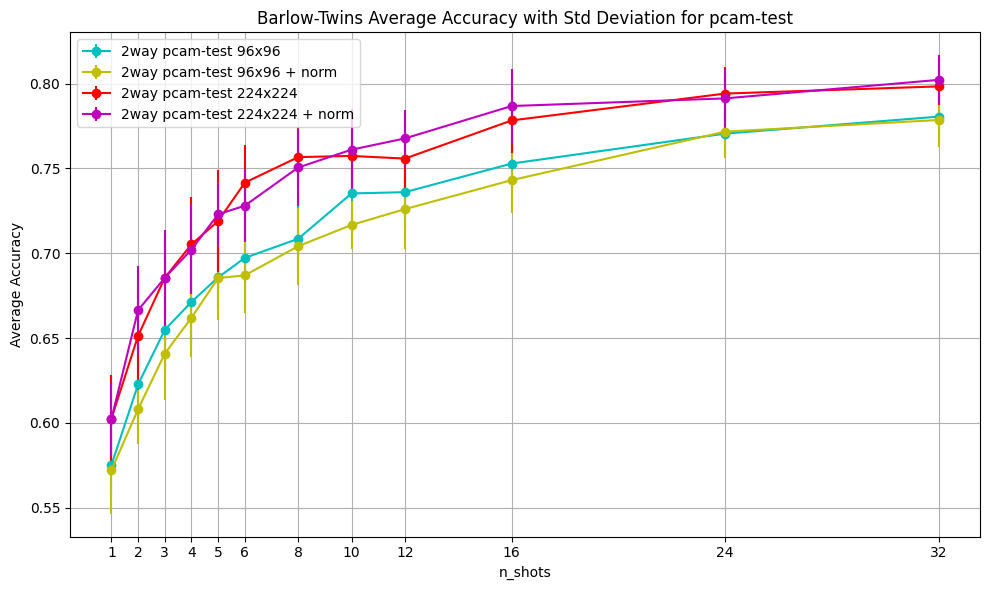

In [ ]:
# Extract n_shots and avg_accuracy columns
shots = merged_df_k['n_shots']

avg_acc3 = merged_df_p['mean']
std_acc3 = merged_df_p['std']

avg_acc5 = merged_df_p2['mean']
std_acc5 = merged_df_p2['std']

avg_acc6 = merged_df_p3['mean']
std_acc6 = merged_df_p3['std']

avg_acc7 = merged_df_p4['mean']
std_acc7 = merged_df_p4['std']

# Create the plot
plt.figure(figsize=(10, 6))

plt.errorbar(shots, avg_acc5, yerr=std_acc5, fmt='-o', color='c', label='2way pcam-test 96x96')
plt.errorbar(shots, avg_acc6, yerr=std_acc6, fmt='-o', color='y', label='2way pcam-test 96x96 + norm')
plt.errorbar(shots, avg_acc3, yerr=std_acc3, fmt='-o', color='r', label='2way pcam-test 224x224')
plt.errorbar(shots, avg_acc7, yerr=std_acc7, fmt='-o', color='m', label='2way pcam-test 224x224 + norm')

plt.title('Barlow-Twins Average Accuracy with Std Deviation for pcam-test')
plt.xlabel('n_shots')
plt.ylabel('Average Accuracy')
plt.grid(True)
plt.xticks(shots)
plt.legend()
plt.tight_layout()
plot_filename = "barlow-twins_few-shot_inference_pcam-test-3.png"
plt.savefig(os.path.join(output_directory_k, plot_filename), dpi=600, format='png')

In [ ]:
transform = transforms.Compose([transforms.CenterCrop((96, 96)),
                                transforms.Resize((224, 224)),
                                transforms.ToTensor(),])
                                #transforms.Normalize(mean=[0.70322989, 0.53606487, 0.66096631], std=[0.21716536, 0.26081574, 0.20723464])])
testset = torchvision.datasets.ImageFolder(data_to_test, transform=transform)

classes = testset.classes

print(classes)
dataloader = DataLoader(testset, batch_size=100, shuffle=False, drop_last=False)
p4_emb_df = predict_embeddings(dataloader, model, device=device)
p4_emb_dataset = FeaturesDataset.from_dataframe(p4_emb_df)
p4_results_df = evaluate_few_shot_model(p4_emb_dataset, model, device=device, n_way=2)
p4_results_df.sort_values(["n_shots", "accuracy"])

mean_accuracies_p4 = p4_results_df.groupby("n_shots")["accuracy"].mean().reset_index()
mean_accuracies_p4.rename(columns={"accuracy": "mean"}, inplace=True)
std_accuracies_p4 = p4_results_df.groupby("n_shots")["accuracy"].std().reset_index()
std_accuracies_p4.rename(columns={"accuracy": "std"}, inplace=True)
# Merge the two DataFrames based on the 'n_shots' column
merged_df_p4 = pd.merge(mean_accuracies_p4, std_accuracies_p4, on="n_shots")

In [ ]:
import os
import torch
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from my_module import predict_embeddings, evaluate_few_shot_model

def plot_results(data_directories, model, output_directory):
    colors = ['c', 'y', 'r', 'm']
    labels = ['2way pcam-test 96x96', '2way pcam-test 96x96 + norm', '2way pcam-test 224x224', '2way pcam-test 224x224 + norm']
    transforms_list = [
        transforms.Compose([
            transforms.CenterCrop((96, 96)),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.70322989, 0.53606487, 0.66096631], std=[0.21716536, 0.26081574, 0.20723464])
        ]),
        transforms.Compose([
            transforms.CenterCrop((96, 96)),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.70322989, 0.53606487, 0.66096631], std=[0.21716536, 0.26081574, 0.20723464])
        ]),
        transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ]),
        transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.70322989, 0.53606487, 0.66096631], std=[0.21716536, 0.26081574, 0.20723464])
        ])
    ]

    plt.figure(figsize=(10, 6))

    for idx, data_directory in enumerate(data_directories):
        transform = transforms_list[idx]

        testset = torchvision.datasets.ImageFolder(data_directory, transform=transform)
        dataloader = DataLoader(testset, batch_size=100, shuffle=False, drop_last=False)
        embeddings_df = predict_embeddings(dataloader, model)
        features_dataset = FeaturesDataset.from_dataframe(embeddings_df)
        results_df = evaluate_few_shot_model(features_dataset, model)

        mean_accuracies = results_df.groupby("n_shots")["accuracy"].mean().reset_index()
        std_accuracies = results_df.groupby("n_shots")["accuracy"].std().reset_index()

        plt.errorbar(mean_accuracies['n_shots'], mean_accuracies['accuracy'], yerr=std_accuracies['accuracy'], fmt='-o', color=colors[idx], label=labels[idx])

    plt.title('Barlow-Twins Average Accuracy with Std Deviation for pcam-test')
    plt.xlabel('n_shots')
    plt.ylabel('Average Accuracy')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plot_filename = "barlow-twins_few-shot_inference_pcam-test.png"
    plt.savefig(os.path.join(output_directory, plot_filename), dpi=600, format='png')

# Example usage:
data_directories = ["data_directory_1", "data_directory_2", "data_directory_3", "data_directory_4"]
model = your_model  # Provide your model
output_directory = "output_directory"
plot_results(data_directories, model, output_directory)


In [ ]:
tsne = TSNE(n_components=2, random_state=0)
embeddings_tsne = tsne.fit_transform(embeddings)

output_path_tsne = os.path.join(output_directory, "tsne_ibot_kather.png")

# In the above tsne plot, there are numeric labels. I want to visualize them using class name

string_labels = [classes[int(label)] for label in data_labels]
create_scatter_plot(embeddings_tsne, string_labels, output_path_tsne, "Feature Output of Model")
# KMeans

kmeans1 = KMeans(n_clusters=8, init='k-means++', n_init=20, random_state=10)
k_result1 = kmeans1.fit_predict(embeddings)
psudo1 = np.zeros_like(k_result1)
for i in range(8):
    mask1 = (k_result1 == i)
    psudo1[mask1] = mode(data_labels[mask1])[0]
output_path_k = os.path.join(output_directory, "kmeans_ibot_kather.csv")
k_performance_values = evaluate_clustering(data_labels, psudo1, output_path_k)
print("KMeans Performance Values:", k_performance_values)
# Plot confusion matrix and visualize for KMeans
k_cm = confusion_matrix(data_labels, psudo1)
output_path_k_cf = os.path.join(output_directory, "kmeans_cf_ibot_kather.png")
plot_and_save_confusion_matrix(k_cm, testset.classes, output_path_k_cf)

output_path_km_plot = os.path.join(output_directory, "kmeans_ibot_kather.png")
create_scatter_plot(embeddings_tsne, psudo1, output_path_km_plot, "KMeans Model")